## Combination of Models 

In [2]:
# Import packages 
import os 
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
os.chdir('/Users/kaushalk/Desktop/open_projects/Telengana_Crop_Health/')
# Add the 'src' directory to the Python path
from src.process_data import compute_indices_for_df, prepare_model_data
from src.utils import prepare_indeces_data_stats
from src.visualize import plot_numerical_distributions, plot_confusion_matrix

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

## Data Collection & Prepration 

In [4]:
# Define file paths
qtr_file = 'data/Model/Input/train_monthly_indeces.csv'
indices_file = 'data/processed/training_s2_indices_v1.csv'

subs_months = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 
               'M15', 'M16', 'M17', 'M18', 'M19', 'M20', 'M21', 'M22', 'M23']
# Prepare the training data
train_df = prepare_indeces_data_stats(
                                    qtr_file, 
                                    indices_file,
                                    target_substrings=subs_months
                                    )

/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1193: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1303: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/ana

In [6]:
# Load:
#loaded_list = pd.read_pickle("top_features.pkl").tolist()
#loaded_list[:30]

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7888 entries, 0 to 7887
Data columns (total 61 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FarmID                      7888 non-null   int64  
 1   Crop                        7888 non-null   int64  
 2   CropCoveredArea             7888 non-null   int64  
 3   CHeight                     7888 non-null   int64  
 4   CNext                       7888 non-null   int64  
 5   CLast                       7888 non-null   int64  
 6   CTransp                     7888 non-null   int64  
 7   IrriType                    7888 non-null   int64  
 8   IrriSource                  7888 non-null   int64  
 9   IrriCount                   7888 non-null   int64  
 10  WaterCov                    7888 non-null   int64  
 11  ExpYield                    7888 non-null   int64  
 12  Season                      7888 non-null   int64  
 13  NDVI                        7871 

In [10]:
train_df = train_df.groupby("Crop").apply(
    lambda group: group.fillna(group.mean(numeric_only=True))
).reset_index(drop=True)
# Drop columns 
remove_col = ['FarmID', 'MSAVI', 'NDVI', 'SAVI', 'LCI', 'LSWI', 'NDWI', 'GNDVI', 
           'CNext', 'CLast', 'CTransp', 'Season', 'IrriType', 'IrriSource', 'IrriCount']
cols_to_inds = [col for col in train_df.columns if '_LSWI_' in col or '_LCI_' in col or '_MoistureIndex_' in col]
drop_cols = remove_col+cols_to_inds

train_data = train_df.copy()
train_data.drop(columns=drop_cols, inplace=True)
#train_data = train_data[loaded_list[:50]]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7888 entries, 0 to 7887
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Crop                7888 non-null   int64  
 1   CropCoveredArea     7888 non-null   int64  
 2   CHeight             7888 non-null   int64  
 3   WaterCov            7888 non-null   int64  
 4   ExpYield            7888 non-null   int64  
 5   EVI                 7888 non-null   float64
 6   MoistureIndex       7888 non-null   float64
 7   NDRE                7888 non-null   float64
 8   TDays               7888 non-null   int64  
 9   M_NDRE_mean         7888 non-null   float64
 10  M_NDRE_std          7888 non-null   float64
 11  M_NDRE_skew         7888 non-null   float64
 12  M_NDRE_kurtosis     7888 non-null   float64
 13  M_NDRE_diff1_mean   7888 non-null   float64
 14  M_NDRE_diff2_mean   7888 non-null   float64
 15  M_EVI_mean          7888 non-null   float64
 16  M_EVI_

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/234870511.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby("Crop").apply(


In [1090]:
train_data.describe().round(3).T

count     mean      std     min      25%      50%  \
Crop                7888.0    3.109    1.779   0.000    2.000    3.000   
CropCoveredArea     7888.0   77.419   14.480  40.000   66.000   79.000   
CHeight             7888.0   87.449   50.309  20.000   54.000   76.000   
WaterCov            7888.0   57.154   22.861  20.000   41.000   51.000   
ExpYield            7888.0   15.694    5.647   5.000   11.000   15.000   
EVI                 7888.0    0.254    0.153  -0.306    0.148    0.245   
MoistureIndex       7888.0    0.081    0.125  -0.164   -0.016    0.062   
NDRE                7888.0    0.020    0.014  -0.067    0.012    0.018   
TDays               7888.0  193.235  124.405   1.000  108.000  153.000   
M_NDRE_mean         7888.0    0.022    0.008  -0.026    0.017    0.022   
M_NDRE_std          7888.0    0.010    0.005   0.000    0.007    0.010   
M_NDRE_skew         7888.0    0.184    0.620  -2.725   -0.197    0.148   
M_NDRE_kurtosis     7888.0   -0.847    0.909  -2.000   -1.500   -1.012   
M_NDRE_diff1_mean   7888.0   -0.001    0.005  -0.081   -0.003   -0.000   
M_NDRE_diff2_mean   7888.0   -0.000    0.010  -0.326   -0.003   -0.000   
M_EVI_mean          7888.0    0.241    0.069  -0.011    0.195    0.236   
M_EVI_std           7888.0    0.101    0.048   0.000    0.069    0.096   
M_EVI_skew          7888.0    0.119    0.601  -2.013   -0.269    0.080   
M_EVI_kurtosis      7888.0   -0.896    0.862  -2.000   -1.500   -1.057   
M_EVI_diff1_mean    7888.0    0.011    0.050  -0.475   -0.011    0.005   
M_EVI_diff2_mean    7888.0   -0.010    0.085  -1.172   -0.033   -0.006   
M_GNDVI_mean        7888.0    0.173    0.038   0.019    0.150    0.171   
M_GNDVI_std         7888.0    0.074    0.031   0.000    0.053    0.076   
M_GNDVI_skew        7888.0    0.099    0.563  -1.868   -0.260    0.067   
M_GNDVI_kurtosis    7888.0   -0.992    0.708  -2.000   -1.500   -1.099   
M_GNDVI_diff1_mean  7888.0    0.005    0.035  -0.262   -0.011    0.002   
M_GNDVI_diff2_mean  7888.0   -0.011    0.061  -0.481   -0.029   -0.006   
target              7888.0    0.344    0.819   0.000    0.000    0.000   

                        75%      max  
Crop                  5.000    6.000  
CropCoveredArea      89.000  100.000  
CHeight             100.000  250.000  
WaterCov             82.000  100.000  
ExpYield             20.000   30.000  
EVI                   0.331    1.000  
MoistureIndex         0.162    0.637  
NDRE                  0.026    0.192  
TDays               258.000  693.000  
M_NDRE_mean           0.027    0.094  
M_NDRE_std            0.013    0.096  
M_NDRE_skew           0.613    3.122  
M_NDRE_kurtosis      -0.549    9.662  
M_NDRE_diff1_mean     0.001    0.044  
M_NDRE_diff2_mean     0.003    0.066  
M_EVI_mean            0.280    0.604  
M_EVI_std             0.126    0.416  
M_EVI_skew            0.513    2.842  
M_EVI_kurtosis       -0.608    8.225  
M_EVI_diff1_mean      0.029    0.589  
M_EVI_diff2_mean      0.018    0.601  
M_GNDVI_mean          0.194    0.402  
M_GNDVI_std           0.093    0.229  
M_GNDVI_skew          0.479    2.406  
M_GNDVI_kurtosis     -0.694    5.442  
M_GNDVI_diff1_mean    0.018    0.325  
M_GNDVI_diff2_mean    0.010    0.418  
target                0.000    3.000

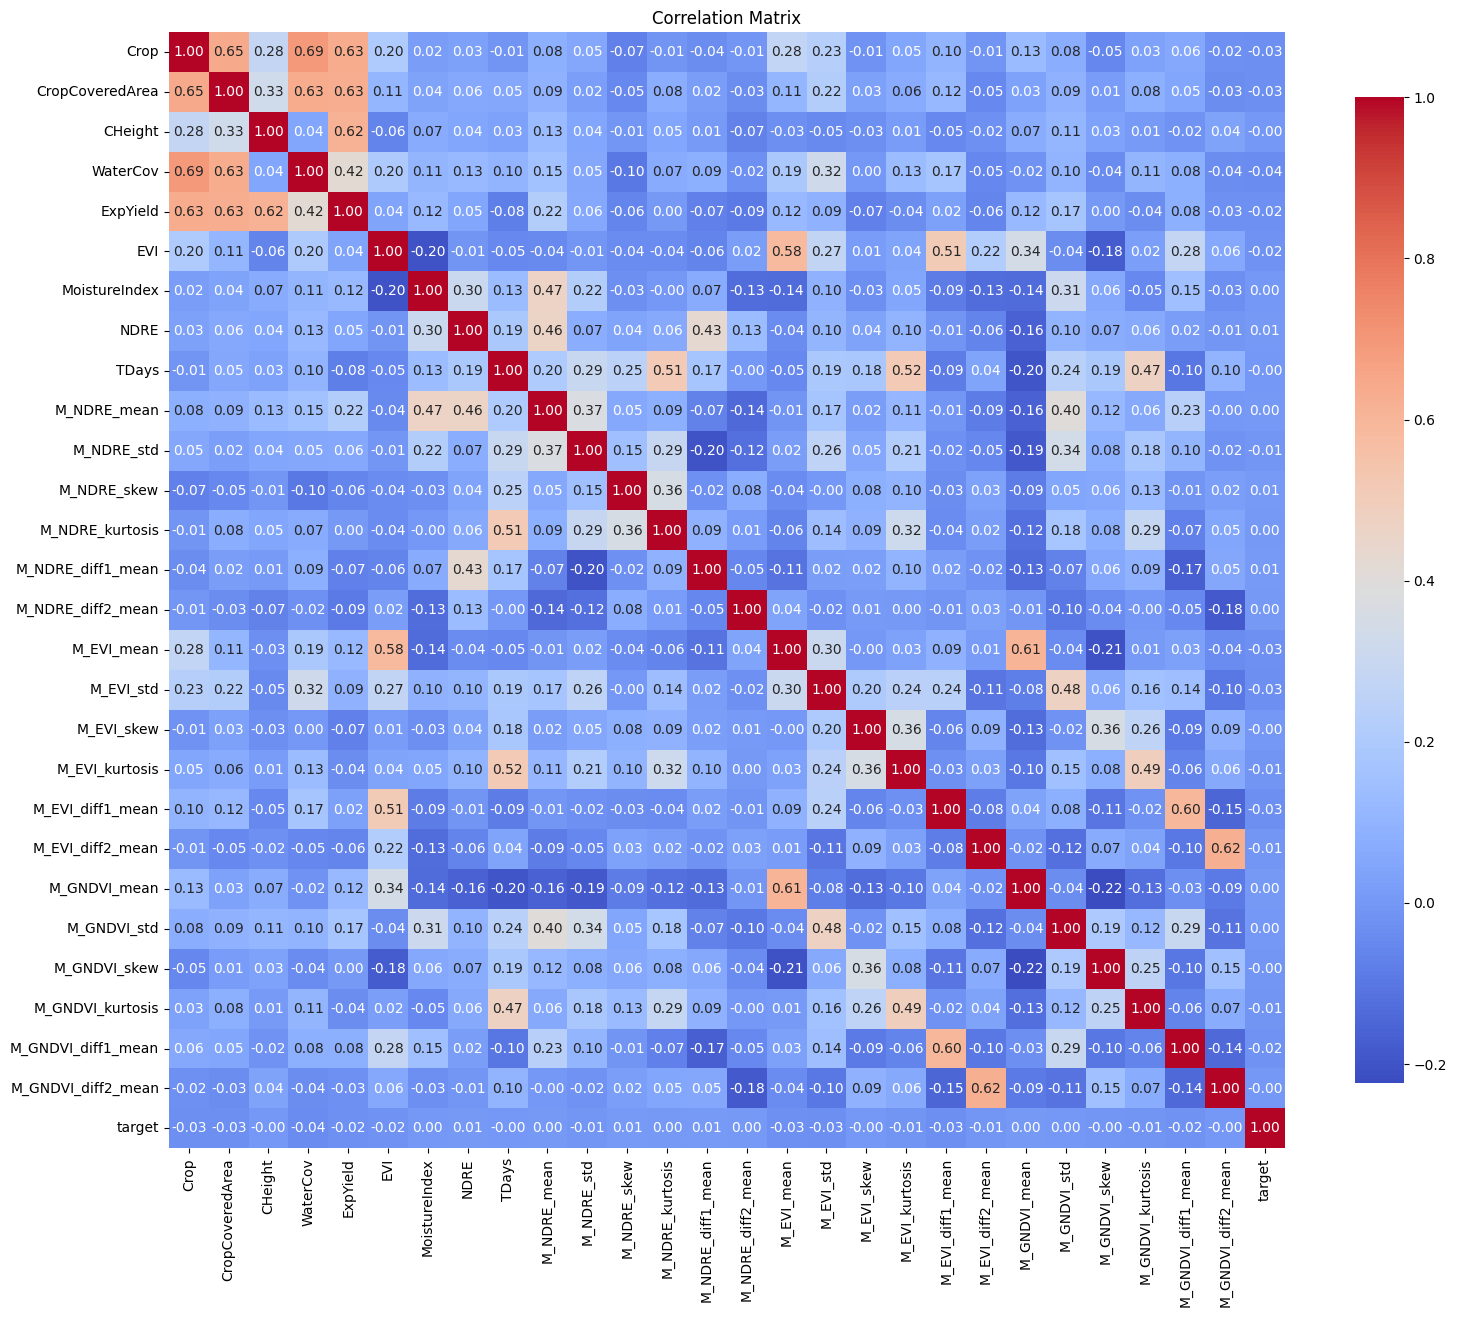

In [243]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train' is your DataFrame
correlation_matrix = train_data.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

In [53]:
# categorical data transformation 
data = pd.read_csv(indices_file, index_col=0)
category_mapper = {label: idx for idx, label in enumerate(data['category'].unique()) if pd.notna(label)}
idx_to_category_mapper = {idx: label for idx, label in enumerate(data['category'].unique()) if pd.notna(label)}
category_mapper

{'Healthy': 0, 'Diseased': 1, 'Pests': 2, 'Stressed': 3}

In [454]:
scaler = StandardScaler()

X = train_data.drop(columns='target')
X_scaled = scaler.fit_transform(X)
y = train_data['target'].astype(int)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, 
                                                      stratify=y, random_state=42)

# Split scaled train dataset
X_train_scaled, X_valid_scaled, y_train_scaled, y_valid_scaled = train_test_split(X_scaled, y, test_size=0.2, 
                                                      stratify=y, random_state=42)
X_train.shape, X_valid.shape

((5916, 27), (1972, 27))

## Main Model

In [378]:
best_params = {'learning_rate': 0.098,
 'num_leaves': 28,
 'max_depth': 20,
 'reg_alpha': 0.2}
 #'min_child_samples': 21,
 #'subsample': 0.6489226330510621,
 #'colsample_bytree': 0.5914533639572044,
 #'reg_alpha': 0.19273250893770352,
 #'reg_lambda': 0.16854761987778938}

In [380]:
lgbm_base = LGBMClassifier(
    objective='multiclass',
    class_weight='balanced',
    **best_params,
    random_state=42,)
lgbm_base.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5994
[LightGBM] [Info] Number of data points in the train set: 5916, number of used features: 27
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


LGBMClassifier(class_weight='balanced', learning_rate=0.098, max_depth=20,
               num_leaves=28, objective='multiclass', random_state=42,
               reg_alpha=0.2)

In [382]:
# Predict on the validation set
y_pred = lgbm_base.predict(X_valid)

# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.82      0.90      0.86      1627
    Diseased       0.06      0.04      0.05       118
       Pests       0.04      0.02      0.03       121
    Stressed       0.03      0.01      0.01       106

    accuracy                           0.74      1972
   macro avg       0.24      0.24      0.24      1972
weighted avg       0.68      0.74      0.71      1972


Weighted F1 Score: 0.7115048633205558


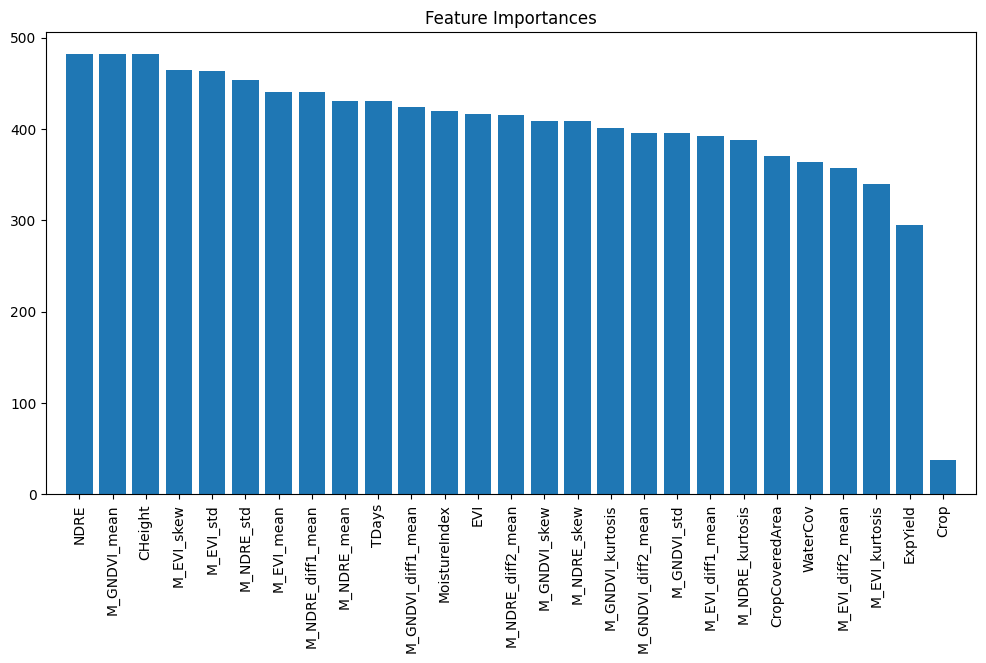

In [384]:
# Get feature importances
importances = lgbm_base.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

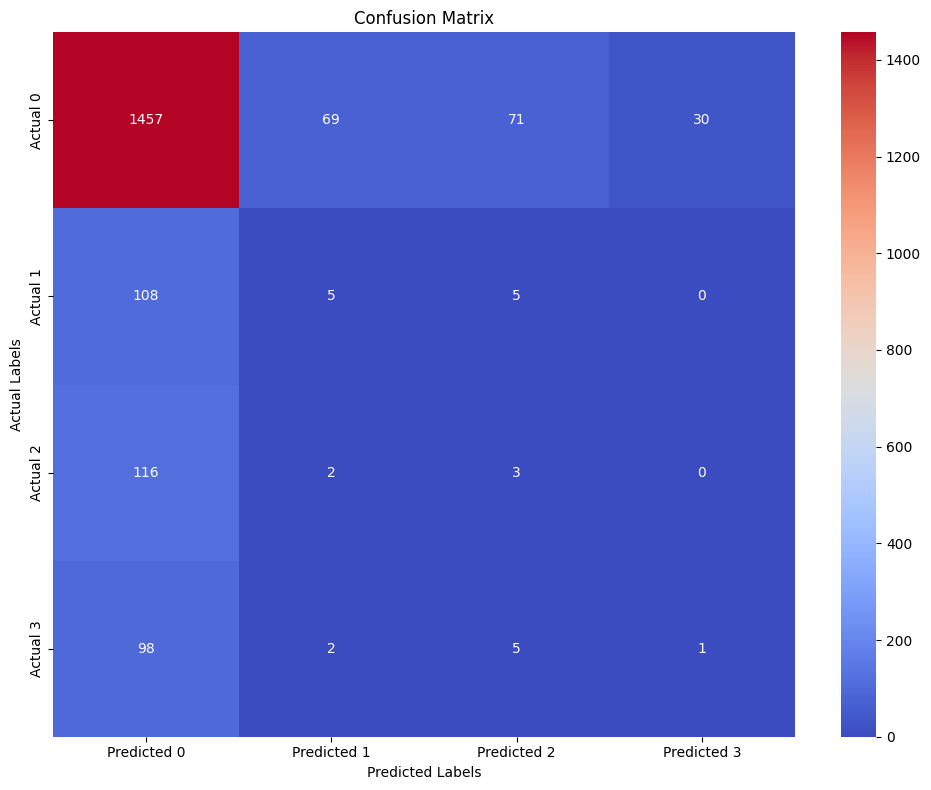

In [386]:
plot_confusion_matrix(y_valid, y_pred)

### Model Tuning 

In [84]:
import numpy as np
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, balanced_accuracy_score

def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y_train)),
        'metric': 'multi_logloss',  # Log loss is still used internally
        'boosting_type': 'gbdt',
        'class_weight': 'balanced',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 8, 50),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_cv_train, X_cv_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_cv_train, y_cv_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = LGBMClassifier(**params)
        model.fit(X_cv_train, y_cv_train, eval_set=[(X_cv_valid, y_cv_valid)], 
                  callbacks=[early_stopping(stopping_rounds=20), log_evaluation(10)])
        
        y_pred = model.predict(X_cv_valid)
        
        # Calculate Weighted F1 and Balanced Accuracy
        f1 = f1_score(y_cv_valid, y_pred, average='weighted')
        bal_acc = balanced_accuracy_score(y_cv_valid, y_pred)
        
        # Custom scoring: weighted sum of F1-score and balanced accuracy
        final_score = (0.6 * f1) + (0.4 * bal_acc)  # Adjust weights as needed
        
        scores.append(final_score)
    
    return np.mean(scores)

In [86]:
# Run Optuna optimization
import optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-02-07 22:47:07,408] A new study created in memory with name: no-name-bb385df1-37ed-454a-a8b7-ef1bfb831a1c
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.26755
[20]	valid_0's multi_logloss: 1.17359
[30]	valid_0's multi_logloss: 1.08831
[40]	valid_0's multi_logloss: 1.01626
[50]	valid_0's multi_logloss: 0.954287
[60]	valid_0's multi_logloss: 0.902961
[70]	valid_0's multi_logloss: 0.863259
[80]	valid_0's multi_logloss: 0.833708
[90]	valid_0's multi_logloss: 0.80981
[100]	valid_0's multi_logloss: 0.795864
Did not meet early stopping. Best iteration is:


[I 2025-02-07 22:47:10,255] Trial 0 finished with value: 0.5401812432608932 and parameters: {'learning_rate': 0.07556669586474533, 'num_leaves': 35, 'max_depth': 16, 'min_child_samples': 44, 'subsample': 0.862430537535244, 'colsample_bytree': 0.6627186077610109, 'reg_alpha': 0.20095660858206427, 'reg_lambda': 0.031770546986060744}. Best is trial 0 with value: 0.5401812432608932.


[80]	valid_0's multi_logloss: 0.81922
[90]	valid_0's multi_logloss: 0.796359
[100]	valid_0's multi_logloss: 0.779167
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.779167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.27265


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[20]	valid_0's multi_logloss: 1.18379
[30]	valid_0's multi_logloss: 1.10592
[40]	valid_0's multi_logloss: 1.03466
[50]	valid_0's multi_logloss: 0.974611
[60]	valid_0's multi_logloss: 0.924691
[70]	valid_0's multi_logloss: 0.883093
[80]	valid_0's multi_logloss: 0.846837
[90]	valid_0's multi_logloss: 0.817941
[100]	valid_0's multi_logloss: 0.793283
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.793283
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 roun

[I 2025-02-07 22:47:14,368] Trial 1 finished with value: 0.540275960787926 and parameters: {'learning_rate': 0.04399211368269106, 'num_leaves': 50, 'max_depth': 33, 'min_child_samples': 26, 'subsample': 0.5621777965610961, 'colsample_bytree': 0.8391983599328106, 'reg_alpha': 0.12954487149536276, 'reg_lambda': 0.027253731032802805}. Best is trial 1 with value: 0.540275960787926.


[80]	valid_0's multi_logloss: 0.844614
[90]	valid_0's multi_logloss: 0.814403
[100]	valid_0's multi_logloss: 0.792517
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.792517
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[10]	valid_0's multi_logloss: 1.27713
[20]	valid_0's multi_logloss: 1.18211
[30]	valid_0's multi_logloss: 1.1006
[40]	valid_0's multi_logloss: 1.02946
[50]	valid_0's multi_logloss: 0.970381
[60]	valid_0's multi_logloss: 0.928847
[70]	valid_0's multi_logloss: 0.889902
[80]	valid_0's multi_logloss: 0.85638
[90]	valid_0's multi_logloss: 0.830284
[100]	valid_0's multi_logloss: 0.80877
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.80877
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validatio

[I 2025-02-07 22:47:17,107] Trial 2 finished with value: 0.5376605104611043 and parameters: {'learning_rate': 0.06986084410467022, 'num_leaves': 34, 'max_depth': 30, 'min_child_samples': 7, 'subsample': 0.9344125396487206, 'colsample_bytree': 0.7968371017862784, 'reg_alpha': 0.04401501606536206, 'reg_lambda': 0.04606759856315017}. Best is trial 1 with value: 0.540275960787926.


[70]	valid_0's multi_logloss: 0.876454
[80]	valid_0's multi_logloss: 0.84337
[90]	valid_0's multi_logloss: 0.819178
[100]	valid_0's multi_logloss: 0.801153
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.801153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[10]	valid_0's multi_logloss: 1.30014
[20]	valid_0's multi_logloss: 1.22158
[30]	valid_0's multi_logloss: 1.15471
[40]	valid_0's multi_logloss: 1.09567
[50]	valid_0's multi_logloss: 1.04366
[60]	valid_0's multi_logloss: 1.00005
[70]	valid_0's multi_logloss: 0.959806
[80]	valid_0's multi_logloss: 0.924177
[90]	valid_0's multi_logloss: 0.89281
[100]	valid_0's multi_logloss: 0.868081
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.868081
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validati

[I 2025-02-07 22:47:19,353] Trial 3 finished with value: 0.5364439091236657 and parameters: {'learning_rate': 0.07565305726569843, 'num_leaves': 26, 'max_depth': 30, 'min_child_samples': 39, 'subsample': 0.813481212856799, 'colsample_bytree': 0.9334212706757052, 'reg_alpha': 0.01984765847548765, 'reg_lambda': 0.33707614710054284}. Best is trial 1 with value: 0.540275960787926.


[70]	valid_0's multi_logloss: 0.933883
[80]	valid_0's multi_logloss: 0.901153
[90]	valid_0's multi_logloss: 0.871866
[100]	valid_0's multi_logloss: 0.846107
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.846107
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[10]	valid_0's multi_logloss: 1.23119
[20]	valid_0's multi_logloss: 1.09805
[30]	valid_0's multi_logloss: 0.996611
[40]	valid_0's multi_logloss: 0.917835
[50]	valid_0's multi_logloss: 0.858434
[60]	valid_0's multi_logloss: 0.820196
[70]	valid_0's multi_logloss: 0.792905
[80]	valid_0's multi_logloss: 0.778851
[90]	valid_0's multi_logloss: 0.770574
[100]	valid_0's multi_logloss: 0.770148
Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.768455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until vali

[I 2025-02-07 22:47:22,177] Trial 4 finished with value: 0.5405325891189475 and parameters: {'learning_rate': 0.09971683191360961, 'num_leaves': 37, 'max_depth': 31, 'min_child_samples': 23, 'subsample': 0.5515017939070366, 'colsample_bytree': 0.7266514477551631, 'reg_alpha': 0.08866442606710961, 'reg_lambda': 0.03174321829362059}. Best is trial 4 with value: 0.5405325891189475.


[100]	valid_0's multi_logloss: 0.77486
Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.772936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.36296
[20]	valid_0's multi_logloss: 1.3444
[30]	valid_0's multi_logloss: 1.32984
[40]	valid_0's multi_logloss: 1.31712
[50]	valid_0's multi_logloss: 1.3035
[60]	valid_0's multi_logloss: 1.29032
[70]	valid_0's multi_logloss: 1.27759
[80]	valid_0's multi_logloss: 1.26683
[90]	v

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[100]	valid_0's multi_logloss: 1.24636
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.24636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.36741
[20]	valid_0's multi_logloss: 1.34966
[30]	valid_0's multi_logloss: 1.33466
[40]	valid_0's multi_logloss: 1.31901
[50]	valid_0's multi_logloss: 1.30464
[60]	valid_0's multi_logloss: 1.29091
[70]	valid_0's multi_logloss: 1.27848
[80]	valid_0's multi_logloss: 1.26451
[90]

[I 2025-02-07 22:47:23,229] Trial 5 finished with value: 0.4156615532118081 and parameters: {'learning_rate': 0.03439754278123687, 'num_leaves': 11, 'max_depth': 43, 'min_child_samples': 49, 'subsample': 0.5015712582441613, 'colsample_bytree': 0.8334745044621737, 'reg_alpha': 0.20707600157603306, 'reg_lambda': 0.08323012393096565}. Best is trial 4 with value: 0.5405325891189475.


[90]	valid_0's multi_logloss: 1.25377
[100]	valid_0's multi_logloss: 1.24087
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.24087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.33427
[20]	valid_0's multi_logloss: 1.28851


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[30]	valid_0's multi_logloss: 1.24795
[40]	valid_0's multi_logloss: 1.20936
[50]	valid_0's multi_logloss: 1.17229
[60]	valid_0's multi_logloss: 1.136
[70]	valid_0's multi_logloss: 1.10153
[80]	valid_0's multi_logloss: 1.06813
[90]	valid_0's multi_logloss: 1.03676
[100]	valid_0's multi_logloss: 1.00807
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.00807
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.33495
[20]	v

[I 2025-02-07 22:47:26,681] Trial 6 finished with value: 0.5234870124360886 and parameters: {'learning_rate': 0.021169441550127323, 'num_leaves': 50, 'max_depth': 39, 'min_child_samples': 44, 'subsample': 0.8235705423560153, 'colsample_bytree': 0.5716182827326177, 'reg_alpha': 0.08466644291537795, 'reg_lambda': 0.2611589972750456}. Best is trial 4 with value: 0.5405325891189475.


[100]	valid_0's multi_logloss: 1.00695
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.00695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.37406
[20]	valid_0's multi_logloss: 1.36391
[30]	valid_0's multi_logloss: 1.35598
[40]	valid_0's multi_logloss: 1.34872
[50]	valid_0's multi_logloss: 1.34098
[60]	valid_0's multi_logloss: 1.33403
[70]	valid_0's multi_logloss: 1.32866


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[80]	valid_0's multi_logloss: 1.32228
[90]	valid_0's multi_logloss: 1.31576
[100]	valid_0's multi_logloss: 1.30984
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.30984
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.37328
[20]	valid_0's multi_logloss: 1.36197
[30]	valid_0's multi_logloss: 1.35401
[40]	valid_0's multi_logloss: 1.34702
[50]	valid_0's multi_logloss: 1.33962
[60]	valid_0's multi_logloss: 1.33188
[70]

[I 2025-02-07 22:47:27,736] Trial 7 finished with value: 0.37988627243151696 and parameters: {'learning_rate': 0.02054810966461193, 'num_leaves': 9, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.5787772399194968, 'colsample_bytree': 0.9646298366050823, 'reg_alpha': 0.9146974482641514, 'reg_lambda': 0.02714821568114623}. Best is trial 4 with value: 0.5405325891189475.


[100]	valid_0's multi_logloss: 1.30576
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.30576
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.35809
[20]	valid_0's multi_logloss: 1.33083
[30]	valid_0's multi_logloss: 1.30553


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[40]	valid_0's multi_logloss: 1.28401
[50]	valid_0's multi_logloss: 1.26436
[60]	valid_0's multi_logloss: 1.24369
[70]	valid_0's multi_logloss: 1.22236
[80]	valid_0's multi_logloss: 1.20316
[90]	valid_0's multi_logloss: 1.18283
[100]	valid_0's multi_logloss: 1.16478
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.16478
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.35362
[20]	valid_0's multi_logloss: 1.3243
[30]	

[I 2025-02-07 22:47:30,115] Trial 8 finished with value: 0.47843330320835875 and parameters: {'learning_rate': 0.018003929184879523, 'num_leaves': 29, 'max_depth': 17, 'min_child_samples': 17, 'subsample': 0.6519976352225431, 'colsample_bytree': 0.6016286330609291, 'reg_alpha': 0.12218248259214143, 'reg_lambda': 0.07787578762313517}. Best is trial 4 with value: 0.5405325891189475.


[100]	valid_0's multi_logloss: 1.15795
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.15795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.33679
[20]	valid_0's multi_logloss: 1.29584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's multi_logloss: 1.25588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's multi_logloss: 1.22085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's multi_logloss: 1.18519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-02-07 22:47:32,503] Trial 9 finished with value: 0.5186386323907396 and parameters: {'learning_rate': 0.02682191897306701, 'num_leaves': 38, 'max_depth': 9, 'min_child_samples': 35, 'subsample': 0.728913931687285, 'colsample_bytree': 0.5237247974665856, 'reg_alpha': 0.08999574386216704, 'reg_lambda': 0.05322587383800128}. Best is trial 4 with value: 0.5405325891189475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's multi_logloss: 1.09178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[30]	valid_0's multi_logloss: 1.15894
[40]	valid_0's multi_logloss: 1.09623
[50]	valid_0's multi_logloss: 1.04752
[60]	valid_0's multi_logloss: 0.995469
[70]	valid_0's multi_logloss: 0.951778
[80]	valid_0's multi_logloss: 0.921724
[90]	valid_0's multi_logloss: 0.894813
[100]	valid_0's multi_logloss: 0.869401
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.869401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.2954

[I 2025-02-07 22:47:34,528] Trial 10 finished with value: 0.5349911747932453 and parameters: {'learning_rate': 0.09874125160196215, 'num_leaves': 21, 'max_depth': 50, 'min_child_samples': 12, 'subsample': 0.7060396571085157, 'colsample_bytree': 0.7012092441109754, 'reg_alpha': 0.010528681249072643, 'reg_lambda': 0.010695991529231933}. Best is trial 4 with value: 0.5405325891189475.


[80]	valid_0's multi_logloss: 0.899698
[90]	valid_0's multi_logloss: 0.872653
[100]	valid_0's multi_logloss: 0.848764
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.848764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.26818


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[20]	valid_0's multi_logloss: 1.17339
[30]	valid_0's multi_logloss: 1.09533
[40]	valid_0's multi_logloss: 1.02539
[50]	valid_0's multi_logloss: 0.966034
[60]	valid_0's multi_logloss: 0.914628
[70]	valid_0's multi_logloss: 0.872321
[80]	valid_0's multi_logloss: 0.836613
[90]	valid_0's multi_logloss: 0.810526
[100]	valid_0's multi_logloss: 0.788909
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.788909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 roun

[I 2025-02-07 22:47:38,833] Trial 11 finished with value: 0.540041060381876 and parameters: {'learning_rate': 0.0474856439480977, 'num_leaves': 49, 'max_depth': 27, 'min_child_samples': 28, 'subsample': 0.5151963534689867, 'colsample_bytree': 0.8642853988825789, 'reg_alpha': 0.4658393330701019, 'reg_lambda': 0.012966475164730167}. Best is trial 4 with value: 0.5405325891189475.


[90]	valid_0's multi_logloss: 0.804393
[100]	valid_0's multi_logloss: 0.780937
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.780937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[10]	valid_0's multi_logloss: 1.27921
[20]	valid_0's multi_logloss: 1.19241
[30]	valid_0's multi_logloss: 1.1136
[40]	valid_0's multi_logloss: 1.04552
[50]	valid_0's multi_logloss: 0.984438
[60]	valid_0's multi_logloss: 0.931343
[70]	valid_0's multi_logloss: 0.886444
[80]	valid_0's multi_logloss: 0.849623
[90]	valid_0's multi_logloss: 0.824
[100]	valid_0's multi_logloss: 0.803306
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.803306
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validatio

[I 2025-02-07 22:47:42,628] Trial 12 finished with value: 0.5435636314083119 and parameters: {'learning_rate': 0.0537453835361882, 'num_leaves': 42, 'max_depth': -1, 'min_child_samples': 27, 'subsample': 0.6269701828996204, 'colsample_bytree': 0.7549412594843496, 'reg_alpha': 0.03338653618849602, 'reg_lambda': 0.163540806661318}. Best is trial 12 with value: 0.5435636314083119.


[100]	valid_0's multi_logloss: 0.798182
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.798182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.21348
[20]	valid_0's multi_logloss: 1.07187
[30]	valid_0's multi_logloss: 0.960089


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[40]	valid_0's multi_logloss: 0.879755
[50]	valid_0's multi_logloss: 0.825616
[60]	valid_0's multi_logloss: 0.791369
[70]	valid_0's multi_logloss: 0.770452
[80]	valid_0's multi_logloss: 0.76312
[90]	valid_0's multi_logloss: 0.765726
Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.763028
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.20975
[20]	valid_0's multi_logloss: 1.06781
[30]	valid_0's multi_logloss: 0.963314
[40]	valid_0

[I 2025-02-07 22:47:45,342] Trial 13 finished with value: 0.5416959464854066 and parameters: {'learning_rate': 0.09882637702564948, 'num_leaves': 43, 'max_depth': 0, 'min_child_samples': 32, 'subsample': 0.6370108211975906, 'colsample_bytree': 0.7277692902353736, 'reg_alpha': 0.03994784753505409, 'reg_lambda': 0.7039380756770592}. Best is trial 12 with value: 0.5435636314083119.


[70]	valid_0's multi_logloss: 0.767458
[80]	valid_0's multi_logloss: 0.764203
[90]	valid_0's multi_logloss: 0.764993
[100]	valid_0's multi_logloss: 0.769768
Did not meet early stopping. Best iteration is:
[84]	valid_0's multi_logloss: 0.762221
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[10]	valid_0's multi_logloss: 1.26596
[20]	valid_0's multi_logloss: 1.17332
[30]	valid_0's multi_logloss: 1.08721
[40]	valid_0's multi_logloss: 1.013
[50]	valid_0's multi_logloss: 0.949761
[60]	valid_0's multi_logloss: 0.899813
[70]	valid_0's multi_logloss: 0.860422
[80]	valid_0's multi_logloss: 0.829488
[90]	valid_0's multi_logloss: 0.805414
[100]	valid_0's multi_logloss: 0.790878
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.790878
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validat

[I 2025-02-07 22:47:48,348] Trial 14 finished with value: 0.53893401240676 and parameters: {'learning_rate': 0.06155401118645706, 'num_leaves': 43, 'max_depth': -1, 'min_child_samples': 32, 'subsample': 0.6279263430842809, 'colsample_bytree': 0.7643231594726505, 'reg_alpha': 0.03318369302944446, 'reg_lambda': 0.8708217283592449}. Best is trial 12 with value: 0.5435636314083119.


[100]	valid_0's multi_logloss: 0.781325
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.781325
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[Light

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-07 22:47:48,728] Trial 15 finished with value: 0.30675608161671936 and parameters: {'learning_rate': 0.08678501485810393, 'num_leaves': 43, 'max_depth': 1, 'min_child_samples': 34, 'subsample': 0.6610836846258541, 'colsample_bytree': 0.6516745636178358, 'reg_alpha': 0.04123664035360822, 'reg_lambda': 0.21257986321015485}. Best is trial 12 with value: 0.5435636314083119.
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-07 22:47:50,908] Trial 16 finished with value: 0.5166850569753212 and parameters: {'learning_rate': 0.05652541544278385, 'num_leaves': 43, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.6193061384935488, 'colsample_bytree': 0.8977731011412804, 'reg_alpha': 0.01759411690148266, 'reg_lambda': 0.7616989309695369}. Best is trial 12 with value: 0.5435636314083119.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's multi_logloss: 1.0613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[20]	valid_0's multi_logloss: 1.29842
[30]	valid_0's multi_logloss: 1.2622
[40]	valid_0's multi_logloss: 1.2274
[50]	valid_0's multi_logloss: 1.19739
[60]	valid_0's multi_logloss: 1.16529
[70]	valid_0's multi_logloss: 1.14054
[80]	valid_0's multi_logloss: 1.11622
[90]	valid_0's multi_logloss: 1.09253
[100]	valid_0's multi_logloss: 1.07023
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.07023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	v

[I 2025-02-07 22:47:52,583] Trial 17 finished with value: 0.4954625592934079 and parameters: {'learning_rate': 0.044293821791973026, 'num_leaves': 20, 'max_depth': 19, 'min_child_samples': 29, 'subsample': 0.7639583813817337, 'colsample_bytree': 0.7766294335311686, 'reg_alpha': 0.026770215549683632, 'reg_lambda': 0.15098166921042794}. Best is trial 12 with value: 0.5435636314083119.


[90]	valid_0's multi_logloss: 1.08134
[100]	valid_0's multi_logloss: 1.05854
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.05854
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation score

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-07 22:47:53,312] Trial 18 finished with value: 0.47281875937842377 and parameters: {'learning_rate': 0.08770362150046632, 'num_leaves': 45, 'max_depth': 4, 'min_child_samples': 39, 'subsample': 0.6802471309002942, 'colsample_bytree': 0.673186114604188, 'reg_alpha': 0.056444532342351056, 'reg_lambda': 0.42289376482999014}. Best is trial 12 with value: 0.5435636314083119.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's multi_logloss: 1.11531
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.11531
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[L

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[10]	valid_0's multi_logloss: 1.29736
[20]	valid_0's multi_logloss: 1.22248
[30]	valid_0's multi_logloss: 1.15314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's multi_logloss: 1.08937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's multi_logloss: 1.03181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's multi_logloss: 0.98445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's multi_logloss: 0.944027
[80]	valid_0's multi_logloss: 0.906611
[90]	valid_0's multi_logloss: 0.877437
[100]	valid_0's multi_logloss: 0.853004
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.853004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of da

[I 2025-02-07 22:47:55,287] Trial 19 finished with value: 0.5366057366686116 and parameters: {'learning_rate': 0.06534939352689136, 'num_leaves': 31, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.762221061028529, 'colsample_bytree': 0.6230060512374846, 'reg_alpha': 0.01695179302198492, 'reg_lambda': 0.517609495323636}. Best is trial 12 with value: 0.5435636314083119.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's multi_logloss: 0.97096
[70]	valid_0's multi_logloss: 0.927196
[80]	valid_0's multi_logloss: 0.893538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's multi_logloss: 0.86311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's multi_logloss: 0.840997
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.840997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from scor

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[10]	valid_0's multi_logloss: 1.31463
[20]	valid_0's multi_logloss: 1.25338
[30]	valid_0's multi_logloss: 1.20226
[40]	valid_0's multi_logloss: 1.15208
[50]	valid_0's multi_logloss: 1.10354
[60]	valid_0's multi_logloss: 1.05914
[70]	valid_0's multi_logloss: 1.01614
[80]	valid_0's multi_logloss: 0.978344
[90]	valid_0's multi_logloss: 0.945043
[100]	valid_0's multi_logloss: 0.91602
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.91602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation

[I 2025-02-07 22:47:58,005] Trial 20 finished with value: 0.5299843569932239 and parameters: {'learning_rate': 0.03587768909723864, 'num_leaves': 39, 'max_depth': 22, 'min_child_samples': 38, 'subsample': 0.9919383532551127, 'colsample_bytree': 0.7192200283432734, 'reg_alpha': 0.011077718474285772, 'reg_lambda': 0.16691864875446483}. Best is trial 12 with value: 0.5435636314083119.


[80]	valid_0's multi_logloss: 0.973328
[90]	valid_0's multi_logloss: 0.938985
[100]	valid_0's multi_logloss: 0.910294
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.910294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.22737


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[20]	valid_0's multi_logloss: 1.09582
[30]	valid_0's multi_logloss: 0.995697
[40]	valid_0's multi_logloss: 0.917537
[50]	valid_0's multi_logloss: 0.856415
[60]	valid_0's multi_logloss: 0.815292
[70]	valid_0's multi_logloss: 0.789435
[80]	valid_0's multi_logloss: 0.773408
[90]	valid_0's multi_logloss: 0.76864
[100]	valid_0's multi_logloss: 0.770981
Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.768056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 roun

[I 2025-02-07 22:48:00,527] Trial 21 finished with value: 0.5415332720364845 and parameters: {'learning_rate': 0.09563872204849169, 'num_leaves': 39, 'max_depth': 37, 'min_child_samples': 23, 'subsample': 0.5734635702516292, 'colsample_bytree': 0.7284269443667124, 'reg_alpha': 0.06593145334710691, 'reg_lambda': 0.12336591650517433}. Best is trial 12 with value: 0.5435636314083119.


[60]	valid_0's multi_logloss: 0.812265
[70]	valid_0's multi_logloss: 0.791261
[80]	valid_0's multi_logloss: 0.777461
[90]	valid_0's multi_logloss: 0.77033
[100]	valid_0's multi_logloss: 0.771237
Did not meet early stopping. Best iteration is:
[92]	valid_0's multi_logloss: 0.768871


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.22838
[20]	valid_0's multi_logloss: 1.09768
[30]	valid_0's multi_logloss: 0.994989
[40]	valid_0's multi_logloss: 0.909829
[50]	valid_0's multi_logloss: 0.852448
[60]	valid_0's multi_logloss: 0.814516
[70]	valid_0's multi_logloss: 0.791507
[80]	valid_0's multi_logloss: 0.773368
[90]	valid_0's multi_logloss: 0.769319
[100]	valid_0's multi_logloss: 0.767853
Did not meet early stopping. Best iteration i

[I 2025-02-07 22:48:03,198] Trial 22 finished with value: 0.5446697614069527 and parameters: {'learning_rate': 0.08934746537057325, 'num_leaves': 40, 'max_depth': 38, 'min_child_samples': 25, 'subsample': 0.593485865757849, 'colsample_bytree': 0.7540462701954127, 'reg_alpha': 0.06252593179009527, 'reg_lambda': 0.12208092272186512}. Best is trial 22 with value: 0.5446697614069527.


[70]	valid_0's multi_logloss: 0.769407
[80]	valid_0's multi_logloss: 0.753143
[90]	valid_0's multi_logloss: 0.747814
[100]	valid_0's multi_logloss: 0.74933
Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.746949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[10]	valid_0's multi_logloss: 1.21569
[20]	valid_0's multi_logloss: 1.08139
[30]	valid_0's multi_logloss: 0.969269
[40]	valid_0's multi_logloss: 0.890302
[50]	valid_0's multi_logloss: 0.83663
[60]	valid_0's multi_logloss: 0.797114
[70]	valid_0's multi_logloss: 0.776316
[80]	valid_0's multi_logloss: 0.766007
[90]	valid_0's multi_logloss: 0.764592
[100]	valid_0's multi_logloss: 0.768519
Did not meet early stopping. Best iteration is:
[84]	valid_0's multi_logloss: 0.763552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until valid

[I 2025-02-07 22:48:06,063] Trial 23 finished with value: 0.5410043394975592 and parameters: {'learning_rate': 0.08821806566080193, 'num_leaves': 46, 'max_depth': 49, 'min_child_samples': 30, 'subsample': 0.5953410271140475, 'colsample_bytree': 0.7936497701739864, 'reg_alpha': 0.027417634645933782, 'reg_lambda': 0.5697766219455901}. Best is trial 22 with value: 0.5446697614069527.


[90]	valid_0's multi_logloss: 0.750699
[100]	valid_0's multi_logloss: 0.75732
Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.749611
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scor

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's multi_logloss: 1.17224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-02-07 22:48:06,846] Trial 24 finished with value: 0.46242399574084425 and parameters: {'learning_rate': 0.08077646233513118, 'num_leaves': 41, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.6932267264836676, 'colsample_bytree': 0.8113075136148072, 'reg_alpha': 0.05108271324017122, 'reg_lambda': 0.27656625791885325}. Best is trial 22 with value: 0.5446697614069527.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[30]	valid_0's multi_logloss: 1.08477
[40]	valid_0's multi_logloss: 1.00843
[50]	valid_0's multi_logloss: 0.945136
[60]	valid_0's multi_logloss: 0.895501
[70]	valid_0's multi_logloss: 0.849516
[80]	valid_0's multi_logloss: 0.817278
[90]	valid_0's multi_logloss: 0.793982
[100]	valid_0's multi_logloss: 0.776799
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.776799
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.257

[I 2025-02-07 22:48:10,092] Trial 25 finished with value: 0.5412564288817567 and parameters: {'learning_rate': 0.05562798099606047, 'num_leaves': 46, 'max_depth': 43, 'min_child_samples': 12, 'subsample': 0.6166367839602485, 'colsample_bytree': 0.7490801993524777, 'reg_alpha': 0.18655710916454812, 'reg_lambda': 0.11960670281399917}. Best is trial 22 with value: 0.5446697614069527.


[90]	valid_0's multi_logloss: 0.789203
[100]	valid_0's multi_logloss: 0.769515
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.769515
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.25914
[20]	valid_0's multi_logloss: 1.15983


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[30]	valid_0's multi_logloss: 1.07726
[40]	valid_0's multi_logloss: 1.00369
[50]	valid_0's multi_logloss: 0.947615
[60]	valid_0's multi_logloss: 0.897644
[70]	valid_0's multi_logloss: 0.859191
[80]	valid_0's multi_logloss: 0.82692
[90]	valid_0's multi_logloss: 0.805576
[100]	valid_0's multi_logloss: 0.788812
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.788812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.2642

[I 2025-02-07 22:48:12,417] Trial 26 finished with value: 0.5409018413866101 and parameters: {'learning_rate': 0.08041204193697063, 'num_leaves': 34, 'max_depth': -1, 'min_child_samples': 32, 'subsample': 0.5452836817817651, 'colsample_bytree': 0.6852925168119908, 'reg_alpha': 0.03452776815044381, 'reg_lambda': 0.19711157918089744}. Best is trial 22 with value: 0.5446697614069527.


[70]	valid_0's multi_logloss: 0.846139
[80]	valid_0's multi_logloss: 0.816907
[90]	valid_0's multi_logloss: 0.796035
[100]	valid_0's multi_logloss: 0.778263
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.778263
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[10]	valid_0's multi_logloss: 1.27841
[20]	valid_0's multi_logloss: 1.19021
[30]	valid_0's multi_logloss: 1.1154
[40]	valid_0's multi_logloss: 1.05054
[50]	valid_0's multi_logloss: 0.99823
[60]	valid_0's multi_logloss: 0.952928
[70]	valid_0's multi_logloss: 0.908896
[80]	valid_0's multi_logloss: 0.876233
[90]	valid_0's multi_logloss: 0.850427
[100]	valid_0's multi_logloss: 0.829093
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.829093
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validat

[I 2025-02-07 22:48:14,282] Trial 27 finished with value: 0.5342524202056806 and parameters: {'learning_rate': 0.09191971459250288, 'num_leaves': 25, 'max_depth': 24, 'min_child_samples': 26, 'subsample': 0.6437297832283482, 'colsample_bytree': 0.8609264922868453, 'reg_alpha': 0.02402344875209947, 'reg_lambda': 0.06220851252765751}. Best is trial 22 with value: 0.5446697614069527.


[100]	valid_0's multi_logloss: 0.818228
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.818228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28441
[20]	valid_0's multi_logloss: 1.205
[30]	valid_0's multi_logloss: 1.13244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's multi_logloss: 1.07085


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[50]	valid_0's multi_logloss: 1.01707
[60]	valid_0's multi_logloss: 0.967326
[70]	valid_0's multi_logloss: 0.927491
[80]	valid_0's multi_logloss: 0.890666
[90]	valid_0's multi_logloss: 0.860754
[100]	valid_0's multi_logloss: 0.837059
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.837059
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28786
[20]	valid_0's multi_logloss: 1.19738
[30]	valid_0's multi_logloss: 1.1170

[I 2025-02-07 22:48:16,396] Trial 28 finished with value: 0.5369397419433846 and parameters: {'learning_rate': 0.06365768082882813, 'num_leaves': 32, 'max_depth': 13, 'min_child_samples': 20, 'subsample': 0.7320918429557365, 'colsample_bytree': 0.7580308179187274, 'reg_alpha': 0.07061987404677247, 'reg_lambda': 0.39677615129552984}. Best is trial 22 with value: 0.5446697614069527.


[80]	valid_0's multi_logloss: 0.885715
[90]	valid_0's multi_logloss: 0.855152
[100]	valid_0's multi_logloss: 0.829691
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.829691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-07 22:48:17,926] Trial 29 finished with value: 0.5312824002868568 and parameters: {'learning_rate': 0.07239957073728437, 'num_leaves': 36, 'max_depth': 7, 'min_child_samples': 42, 'subsample': 0.7959254119196283, 'colsample_bytree': 0.6408661930017828, 'reg_alpha': 0.18195326708654969, 'reg_lambda': 0.0189466560386704}. Best is trial 22 with value: 0.5446697614069527.
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-02-07 22:48:18,433] Trial 30 finished with value: 0.40741304825288055 and parameters: {'learning_rate': 0.08410517442660254, 'num_leaves': 41, 'max_depth': 3, 'min_child_samples': 50, 'subsample': 0.5334883300652822, 'colsample_bytree': 0.5784499534159641, 'reg_alpha': 0.3097580276546009, 'reg_lambda': 0.9975239340234077}. Best is trial 22 with value: 0.5446697614069527.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's multi_logloss: 1.34797
[LightGBM] [Warning] No further splits with positive gain, bes

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[30]	valid_0's multi_logloss: 0.993824
[40]	valid_0's multi_logloss: 0.917658
[50]	valid_0's multi_logloss: 0.862878
[60]	valid_0's multi_logloss: 0.819331
[70]	valid_0's multi_logloss: 0.791497
[80]	valid_0's multi_logloss: 0.777407
[90]	valid_0's multi_logloss: 0.771529
[100]	valid_0's multi_logloss: 0.771242
Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.770286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.22

[I 2025-02-07 22:48:20,896] Trial 31 finished with value: 0.5402159574162081 and parameters: {'learning_rate': 0.09389450657735271, 'num_leaves': 39, 'max_depth': 36, 'min_child_samples': 24, 'subsample': 0.588040753504962, 'colsample_bytree': 0.7286991801297596, 'reg_alpha': 0.06215355832981548, 'reg_lambda': 0.11922658668151685}. Best is trial 22 with value: 0.5446697614069527.


[80]	valid_0's multi_logloss: 0.75851
[90]	valid_0's multi_logloss: 0.756841
[100]	valid_0's multi_logloss: 0.757131
Did not meet early stopping. Best iteration is:
[86]	valid_0's multi_logloss: 0.755695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.2014


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[20]	valid_0's multi_logloss: 1.0535
[30]	valid_0's multi_logloss: 0.944914
[40]	valid_0's multi_logloss: 0.865978
[50]	valid_0's multi_logloss: 0.812575
[60]	valid_0's multi_logloss: 0.78187
[70]	valid_0's multi_logloss: 0.766841
[80]	valid_0's multi_logloss: 0.759119
[90]	valid_0's multi_logloss: 0.763683
Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.758639
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.19609
[20]	valid_0'

[I 2025-02-07 22:48:23,717] Trial 32 finished with value: 0.5404533971326935 and parameters: {'learning_rate': 0.0947366728993797, 'num_leaves': 47, 'max_depth': 42, 'min_child_samples': 31, 'subsample': 0.600976458704459, 'colsample_bytree': 0.6844565291420962, 'reg_alpha': 0.11901374893674639, 'reg_lambda': 0.10683570060916227}. Best is trial 22 with value: 0.5446697614069527.
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28752
[20]	valid_0's multi_logloss: 1.20714
[30]	valid_0's multi_logloss: 1.1329
[40]	valid_0's multi_logloss: 1.06495
[50]	valid_0's multi_logloss: 1.00316
[60]	valid_0's multi_logloss: 0.952088
[70]	valid_0's multi_logloss: 0.910282
[80]	valid_0's multi_logloss: 0.874616
[90]	valid_0's multi_logloss: 0.844108
[100]	valid_0's multi_logloss: 0.819342
Did not meet early stopping. Best iteration is:
[

[I 2025-02-07 22:48:26,464] Trial 33 finished with value: 0.5404383840652238 and parameters: {'learning_rate': 0.049448423775315914, 'num_leaves': 41, 'max_depth': 35, 'min_child_samples': 35, 'subsample': 0.5701517775795775, 'colsample_bytree': 0.8148740387073522, 'reg_alpha': 0.04019797409600348, 'reg_lambda': 0.07670029633303356}. Best is trial 22 with value: 0.5446697614069527.


[90]	valid_0's multi_logloss: 0.837727
[100]	valid_0's multi_logloss: 0.812176
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.812176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.26349


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[20]	valid_0's multi_logloss: 1.15689
[30]	valid_0's multi_logloss: 1.06841
[40]	valid_0's multi_logloss: 0.995793
[50]	valid_0's multi_logloss: 0.9391
[60]	valid_0's multi_logloss: 0.893859
[70]	valid_0's multi_logloss: 0.854863
[80]	valid_0's multi_logloss: 0.825697
[90]	valid_0's multi_logloss: 0.802427
[100]	valid_0's multi_logloss: 0.786973
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.786973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 round

[I 2025-02-07 22:48:29,107] Trial 34 finished with value: 0.5390010812435828 and parameters: {'learning_rate': 0.07648344906556075, 'num_leaves': 36, 'max_depth': 39, 'min_child_samples': 13, 'subsample': 0.6813737687724576, 'colsample_bytree': 0.7459476232661708, 'reg_alpha': 0.06853840553445356, 'reg_lambda': 0.14295867669909737}. Best is trial 22 with value: 0.5446697614069527.


[100]	valid_0's multi_logloss: 0.766516
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.766516
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.24785
[20]	valid_0's multi_logloss: 1.12903
[30]	valid_0's multi_logloss: 1.0376


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[40]	valid_0's multi_logloss: 0.959709
[50]	valid_0's multi_logloss: 0.901516
[60]	valid_0's multi_logloss: 0.859372
[70]	valid_0's multi_logloss: 0.823775
[80]	valid_0's multi_logloss: 0.804375
[90]	valid_0's multi_logloss: 0.792303
[100]	valid_0's multi_logloss: 0.785409
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.785409
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.22932
[20]	valid_0's multi_logloss: 1.10

[I 2025-02-07 22:48:31,212] Trial 35 finished with value: 0.5419979262052228 and parameters: {'learning_rate': 0.09824439726428418, 'num_leaves': 33, 'max_depth': 26, 'min_child_samples': 25, 'subsample': 0.5591911044147629, 'colsample_bytree': 0.7093607700987461, 'reg_alpha': 0.049958357774229675, 'reg_lambda': 0.04220015836247298}. Best is trial 22 with value: 0.5446697614069527.


[60]	valid_0's multi_logloss: 0.84639
[70]	valid_0's multi_logloss: 0.815562
[80]	valid_0's multi_logloss: 0.794295
[90]	valid_0's multi_logloss: 0.784284
[100]	valid_0's multi_logloss: 0.780596
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.780596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[10]	valid_0's multi_logloss: 1.2813
[20]	valid_0's multi_logloss: 1.18677
[30]	valid_0's multi_logloss: 1.11147
[40]	valid_0's multi_logloss: 1.04804
[50]	valid_0's multi_logloss: 0.996947
[60]	valid_0's multi_logloss: 0.947012
[70]	valid_0's multi_logloss: 0.90593
[80]	valid_0's multi_logloss: 0.875069
[90]	valid_0's multi_logloss: 0.843484
[100]	valid_0's multi_logloss: 0.819457
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.819457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validat

[I 2025-02-07 22:48:33,305] Trial 36 finished with value: 0.5359157861471064 and parameters: {'learning_rate': 0.06896785452305454, 'num_leaves': 32, 'max_depth': 28, 'min_child_samples': 27, 'subsample': 0.5334561903999238, 'colsample_bytree': 0.7025552529029138, 'reg_alpha': 0.044146672026360585, 'reg_lambda': 0.03902807432938736}. Best is trial 22 with value: 0.5446697614069527.


[90]	valid_0's multi_logloss: 0.83291
[100]	valid_0's multi_logloss: 0.808737
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.808737
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.26653
[20]	valid_0's multi_logloss: 1.17758
[30]	valid_0's multi_logloss: 1.1015


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[40]	valid_0's multi_logloss: 1.03115
[50]	valid_0's multi_logloss: 0.973313
[60]	valid_0's multi_logloss: 0.927907
[70]	valid_0's multi_logloss: 0.893618
[80]	valid_0's multi_logloss: 0.868134
[90]	valid_0's multi_logloss: 0.845855
[100]	valid_0's multi_logloss: 0.827643
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.827643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.26326
[20]	valid_0's multi_logloss: 1.157

[I 2025-02-07 22:48:35,197] Trial 37 finished with value: 0.539295868810165 and parameters: {'learning_rate': 0.09119653594287948, 'num_leaves': 27, 'max_depth': 32, 'min_child_samples': 20, 'subsample': 0.8928398964566111, 'colsample_bytree': 0.8421231080629871, 'reg_alpha': 0.01350153848739512, 'reg_lambda': 0.021864381490982035}. Best is trial 22 with value: 0.5446697614069527.
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.31722
[20]	valid_0's multi_logloss: 1.26028
[30]	valid_0's multi_logloss: 1.21163
[40]	valid_0's multi_logloss: 1.16571
[50]	valid_0's multi_logloss: 1.12128
[60]	valid_0's multi_logloss: 1.08018
[70]	valid_0's multi_logloss: 1.04452
[80]	valid_0's multi_logloss: 1.01187
[90]	valid_0's multi_logloss: 0.98188
[100]	valid_0's multi_logloss: 0.952152
Did not meet early stopping. Best iteration is:
[100

[I 2025-02-07 22:48:37,474] Trial 38 finished with value: 0.5314445948863797 and parameters: {'learning_rate': 0.03723457962525196, 'num_leaves': 34, 'max_depth': 22, 'min_child_samples': 25, 'subsample': 0.6370462806797097, 'colsample_bytree': 0.7887256272162804, 'reg_alpha': 0.023447598919259623, 'reg_lambda': 0.04058449625510436}. Best is trial 22 with value: 0.5446697614069527.


[90]	valid_0's multi_logloss: 0.966743
[100]	valid_0's multi_logloss: 0.936259
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.936259
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.35621


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[20]	valid_0's multi_logloss: 1.32826
[30]	valid_0's multi_logloss: 1.30458
[40]	valid_0's multi_logloss: 1.28157
[50]	valid_0's multi_logloss: 1.26033
[60]	valid_0's multi_logloss: 1.23907
[70]	valid_0's multi_logloss: 1.22031
[80]	valid_0's multi_logloss: 1.20086
[90]	valid_0's multi_logloss: 1.18177
[100]	valid_0's multi_logloss: 1.16398
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.16398
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]

[I 2025-02-07 22:48:40,701] Trial 39 finished with value: 0.48519768431264476 and parameters: {'learning_rate': 0.010100229565031996, 'num_leaves': 48, 'max_depth': 15, 'min_child_samples': 16, 'subsample': 0.5568868438280211, 'colsample_bytree': 0.8952599750149389, 'reg_alpha': 0.03380415590445188, 'reg_lambda': 0.06548557721144002}. Best is trial 22 with value: 0.5446697614069527.


[90]	valid_0's multi_logloss: 1.18003
[100]	valid_0's multi_logloss: 1.16007
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.16007
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.26177
[20]	valid_0's multi_logloss: 1.15398


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[30]	valid_0's multi_logloss: 1.06476
[40]	valid_0's multi_logloss: 0.991176
[50]	valid_0's multi_logloss: 0.936842
[60]	valid_0's multi_logloss: 0.890345
[70]	valid_0's multi_logloss: 0.852568
[80]	valid_0's multi_logloss: 0.823227
[90]	valid_0's multi_logloss: 0.803925
[100]	valid_0's multi_logloss: 0.792412
Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.792287
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.256

[I 2025-02-07 22:48:42,758] Trial 40 finished with value: 0.5416682522507014 and parameters: {'learning_rate': 0.09709101947461468, 'num_leaves': 29, 'max_depth': 46, 'min_child_samples': 22, 'subsample': 0.6103633166695459, 'colsample_bytree': 0.6559916748249653, 'reg_alpha': 0.0979642333403202, 'reg_lambda': 0.2861282463647932}. Best is trial 22 with value: 0.5446697614069527.


[90]	valid_0's multi_logloss: 0.798846
[100]	valid_0's multi_logloss: 0.783037
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.783037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.26745
[20]	valid_0's multi_logloss: 1.16273
[30]	valid_0's multi_logloss: 1.0708


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[40]	valid_0's multi_logloss: 0.996834
[50]	valid_0's multi_logloss: 0.937387
[60]	valid_0's multi_logloss: 0.890116
[70]	valid_0's multi_logloss: 0.852237
[80]	valid_0's multi_logloss: 0.824202
[90]	valid_0's multi_logloss: 0.803572
[100]	valid_0's multi_logloss: 0.791999
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.791999
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.25897
[20]	valid_0's multi_logloss: 1.15

[I 2025-02-07 22:48:45,017] Trial 41 finished with value: 0.539924271768294 and parameters: {'learning_rate': 0.09840515392506599, 'num_leaves': 30, 'max_depth': 47, 'min_child_samples': 5, 'subsample': 0.6061357778323287, 'colsample_bytree': 0.6249469447013698, 'reg_alpha': 0.1010333939310152, 'reg_lambda': 0.29662801425297936}. Best is trial 22 with value: 0.5446697614069527.


[90]	valid_0's multi_logloss: 0.796047
[100]	valid_0's multi_logloss: 0.784559
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.784559
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28395
[20]	valid_0's multi_logloss: 1.19303
[30]	valid_0's multi_logloss: 1.12275
[40]	valid_0's multi_logloss: 1.05562


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[50]	valid_0's multi_logloss: 0.997662
[60]	valid_0's multi_logloss: 0.948408
[70]	valid_0's multi_logloss: 0.909016
[80]	valid_0's multi_logloss: 0.880862
[90]	valid_0's multi_logloss: 0.854751
[100]	valid_0's multi_logloss: 0.829012
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.829012
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28202
[20]	valid_0's multi_logloss: 1.18752
[30]	valid_0's multi_logloss: 1.102

[I 2025-02-07 22:48:46,675] Trial 42 finished with value: 0.5369529164509743 and parameters: {'learning_rate': 0.09912878733129261, 'num_leaves': 24, 'max_depth': 45, 'min_child_samples': 22, 'subsample': 0.6621810427976836, 'colsample_bytree': 0.7025772544270045, 'reg_alpha': 0.14779106430760652, 'reg_lambda': 0.22830538769366893}. Best is trial 22 with value: 0.5446697614069527.


[60]	valid_0's multi_logloss: 0.936586
[70]	valid_0's multi_logloss: 0.893609
[80]	valid_0's multi_logloss: 0.861043
[90]	valid_0's multi_logloss: 0.835525
[100]	valid_0's multi_logloss: 0.813174
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.813174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.30051


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[20]	valid_0's multi_logloss: 1.23171
[30]	valid_0's multi_logloss: 1.1663
[40]	valid_0's multi_logloss: 1.11419
[50]	valid_0's multi_logloss: 1.06515
[60]	valid_0's multi_logloss: 1.01826
[70]	valid_0's multi_logloss: 0.979359
[80]	valid_0's multi_logloss: 0.946122
[90]	valid_0's multi_logloss: 0.913232
[100]	valid_0's multi_logloss: 0.884241
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.884241
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


[I 2025-02-07 22:48:48,101] Trial 43 finished with value: 0.5286769474920546 and parameters: {'learning_rate': 0.08077273410489298, 'num_leaves': 22, 'max_depth': 41, 'min_child_samples': 28, 'subsample': 0.5057003473837628, 'colsample_bytree': 0.6735900335853953, 'reg_alpha': 0.051656124177246236, 'reg_lambda': 0.09013888069722019}. Best is trial 22 with value: 0.5446697614069527.


[80]	valid_0's multi_logloss: 0.941271
[90]	valid_0's multi_logloss: 0.910185
[100]	valid_0's multi_logloss: 0.884978
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.884978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.31091
[20]	valid_0's multi_logloss: 1.25606
[30]	valid_0's multi_logloss: 1.20217
[40]	valid_0's multi_logloss: 1.1545
[50]	valid_0's multi_logloss: 1.11052


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[60]	valid_0's multi_logloss: 1.0703
[70]	valid_0's multi_logloss: 1.03123
[80]	valid_0's multi_logloss: 0.995528
[90]	valid_0's multi_logloss: 0.966986
[100]	valid_0's multi_logloss: 0.94011
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.94011
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.31217
[20]	valid_0's multi_logloss: 1.2521
[30]	valid_0's multi_logloss: 1.19165
[40]	valid_0's multi_logloss: 1.13674
[50]

[I 2025-02-07 22:48:49,304] Trial 44 finished with value: 0.5270367247863195 and parameters: {'learning_rate': 0.08780770013294419, 'num_leaves': 19, 'max_depth': 46, 'min_child_samples': 22, 'subsample': 0.5824456294151316, 'colsample_bytree': 0.5111720492369528, 'reg_alpha': 0.08160296667043805, 'reg_lambda': 0.6033700753901561}. Best is trial 22 with value: 0.5446697614069527.


[20]	valid_0's multi_logloss: 1.25241
[30]	valid_0's multi_logloss: 1.20306
[40]	valid_0's multi_logloss: 1.15551
[50]	valid_0's multi_logloss: 1.10709
[60]	valid_0's multi_logloss: 1.05996
[70]	valid_0's multi_logloss: 1.0222
[80]	valid_0's multi_logloss: 0.985758
[90]	valid_0's multi_logloss: 0.953844
[100]	valid_0's multi_logloss: 0.924193
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.924193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[10]	valid_0's multi_logloss: 1.26879
[20]	valid_0's multi_logloss: 1.17185
[30]	valid_0's multi_logloss: 1.08726
[40]	valid_0's multi_logloss: 1.01745
[50]	valid_0's multi_logloss: 0.963742
[60]	valid_0's multi_logloss: 0.916188
[70]	valid_0's multi_logloss: 0.875134
[80]	valid_0's multi_logloss: 0.839577
[90]	valid_0's multi_logloss: 0.817027
[100]	valid_0's multi_logloss: 0.800625
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.800625
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until valid

[I 2025-02-07 22:48:51,064] Trial 45 finished with value: 0.5369143723206858 and parameters: {'learning_rate': 0.09991136445895853, 'num_leaves': 28, 'max_depth': 34, 'min_child_samples': 33, 'subsample': 0.7063716088974269, 'colsample_bytree': 0.6554349077054988, 'reg_alpha': 0.10426680727377981, 'reg_lambda': 0.36092620367910333}. Best is trial 22 with value: 0.5446697614069527.


[60]	valid_0's multi_logloss: 0.891726
[70]	valid_0's multi_logloss: 0.852608
[80]	valid_0's multi_logloss: 0.824522
[90]	valid_0's multi_logloss: 0.806625
[100]	valid_0's multi_logloss: 0.788616
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.788616
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[10]	valid_0's multi_logloss: 1.22092
[20]	valid_0's multi_logloss: 1.08456
[30]	valid_0's multi_logloss: 0.977845
[40]	valid_0's multi_logloss: 0.900267
[50]	valid_0's multi_logloss: 0.846336
[60]	valid_0's multi_logloss: 0.808071
[70]	valid_0's multi_logloss: 0.786692
[80]	valid_0's multi_logloss: 0.776681
[90]	valid_0's multi_logloss: 0.774675
[100]	valid_0's multi_logloss: 0.778981
Did not meet early stopping. Best iteration is:
[84]	valid_0's multi_logloss: 0.773977
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until vali

[I 2025-02-07 22:48:53,716] Trial 46 finished with value: 0.5407513378535127 and parameters: {'learning_rate': 0.09167102851883789, 'num_leaves': 44, 'max_depth': 27, 'min_child_samples': 37, 'subsample': 0.6300961702423407, 'colsample_bytree': 0.7411086936449022, 'reg_alpha': 0.14528495299321767, 'reg_lambda': 0.1886992232989389}. Best is trial 22 with value: 0.5446697614069527.


[90]	valid_0's multi_logloss: 0.752965
[100]	valid_0's multi_logloss: 0.755766
Did not meet early stopping. Best iteration is:
[92]	valid_0's multi_logloss: 0.752318
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.34475
[20]	valid_0's multi_logloss: 1.31558
[30]	valid_0's multi_logloss: 1.29083
[40]	valid_0's multi_logloss: 1.26677


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[50]	valid_0's multi_logloss: 1.24211
[60]	valid_0's multi_logloss: 1.21826
[70]	valid_0's multi_logloss: 1.19599
[80]	valid_0's multi_logloss: 1.175
[90]	valid_0's multi_logloss: 1.15624
[100]	valid_0's multi_logloss: 1.13613
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.13613
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10580
[LightGBM] [Info] Number of data points in the train set: 4733, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.34563
[20]	valid_0's multi_logloss: 1.31904
[30]	valid_0's multi_logloss: 1.28716
[40]	v

[I 2025-02-07 22:48:54,886] Trial 47 finished with value: 0.4741232824772384 and parameters: {'learning_rate': 0.05121455382194136, 'num_leaves': 14, 'max_depth': 30, 'min_child_samples': 30, 'subsample': 0.5533186200300786, 'colsample_bytree': 0.9864711421463023, 'reg_alpha': 0.04486328431762469, 'reg_lambda': 0.4809101026305223}. Best is trial 22 with value: 0.5446697614069527.


[40]	valid_0's multi_logloss: 1.2593
[50]	valid_0's multi_logloss: 1.23277
[60]	valid_0's multi_logloss: 1.20956
[70]	valid_0's multi_logloss: 1.18928
[80]	valid_0's multi_logloss: 1.16918
[90]	valid_0's multi_logloss: 1.14578
[100]	valid_0's multi_logloss: 1.12579
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.12579


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28964
[20]	valid_0's multi_logloss: 1.20526
[30]	valid_0's multi_logloss: 1.12619
[40]	valid_0's multi_logloss: 1.05946
[50]	valid_0's multi_logloss: 0.997869
[60]	valid_0's multi_logloss: 0.951404
[70]	valid_0's multi_logloss: 0.910325
[80]	valid_0's multi_logloss: 0.87459
[90]	valid_0's multi_logloss: 0.847353
[100]	valid_0's multi_logloss: 0.824068
Did not meet early stopping. Best iteration is:


[I 2025-02-07 22:48:57,165] Trial 48 finished with value: 0.539572264967594 and parameters: {'learning_rate': 0.060155472991763465, 'num_leaves': 37, 'max_depth': 18, 'min_child_samples': 24, 'subsample': 0.5252209662446949, 'colsample_bytree': 0.5989163479653815, 'reg_alpha': 0.07568227963312796, 'reg_lambda': 0.7284709790025762}. Best is trial 22 with value: 0.5446697614069527.


[90]	valid_0's multi_logloss: 0.842305
[100]	valid_0's multi_logloss: 0.817112
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.817112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10577
[LightGBM] [Info] Number of data points in the train set: 4732, number of used features: 45
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.25808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_16557/3180297327.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-07 22:48:59,019] Trial 49 finished with value: 0.5351281642518629 and parameters: {'learning_rate': 0.08503912024313152, 'num_leaves': 34, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.6621174062218561, 'colsample_bytree': 0.7144438635160566, 'reg_alpha': 0.03154996524701712, 'reg_lambda': 0.31539106227364555}. Best is trial 22 with value: 0.5446697614069527.


[90]	valid_0's multi_logloss: 0.821372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's multi_logloss: 0.808274
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.808274


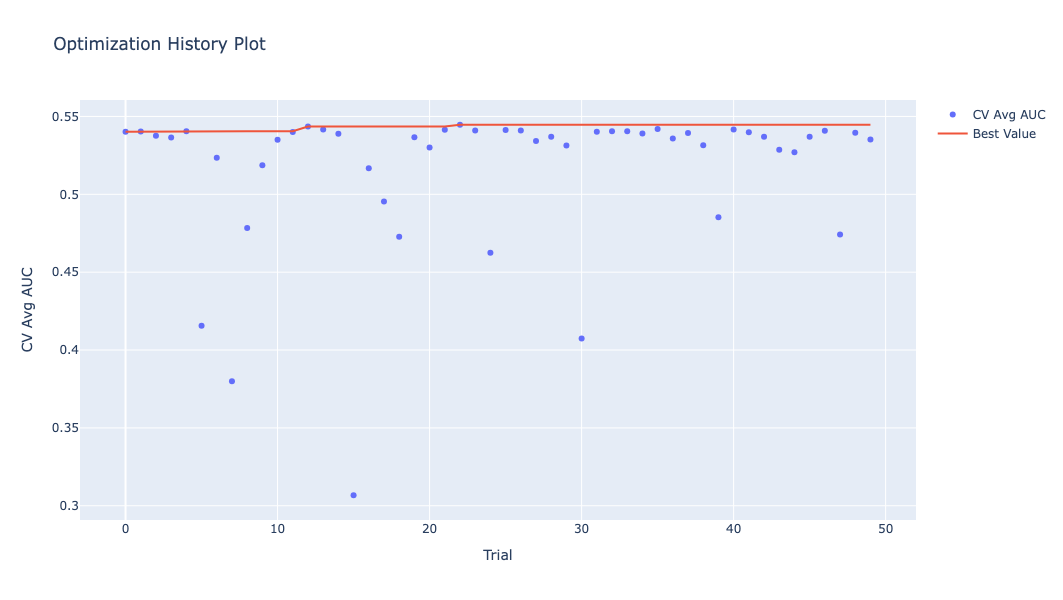

In [88]:
fig = optuna.visualization.plot_optimization_history(study, target_name='CV Avg AUC')

fig.update_layout(
    autosize=True,
    width=800,
    height=600
)
fig.show()

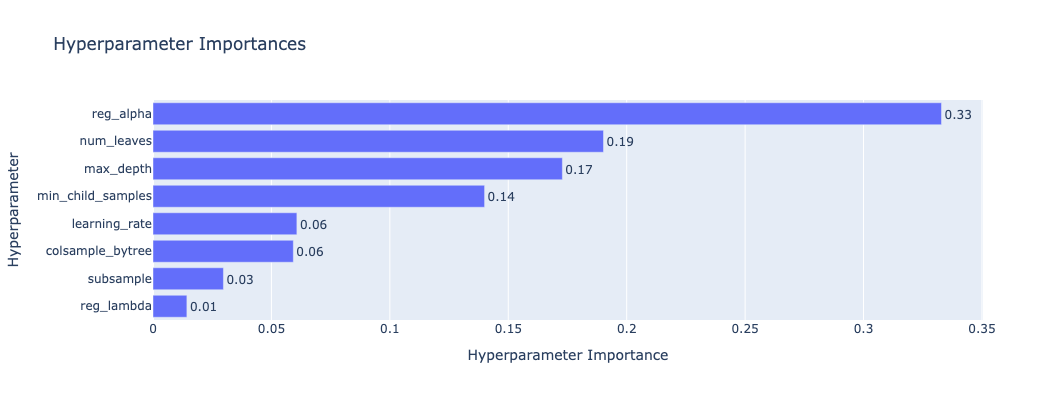

In [90]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(
    autosize=True,
    width=900,
    height=400
)
fig.show()

In [92]:
study.best_params

{'learning_rate': 0.08934746537057325,
 'num_leaves': 40,
 'max_depth': 38,
 'min_child_samples': 25,
 'subsample': 0.593485865757849,
 'colsample_bytree': 0.7540462701954127,
 'reg_alpha': 0.06252593179009527,
 'reg_lambda': 0.12208092272186512}

## Test & Submission

In [68]:
# Define file paths
mnth_tfile = 'data/Model/Input/test_monthly_ind.csv'
indices_tfile = 'data/processed/test_s2_indices_v1.csv'

# Prepare the training data

test_df = prepare_indeces_data_stats(mnth_tfile, 
                           indices_tfile,
                           target_substrings=subs_months
                            )

In [70]:
test_df.head()

FarmID  Crop  CropCoveredArea  CHeight  CNext  CLast  CTransp  IrriType  \
0    85197     5               81       99      0      4        3         1   
1   779677     5               91       63      0      4        3         1   
2  1331840     5               94       89      4      0        3         1   
3   483053     5               83       78      4      0        3         1   
4   542945     5               82       53      0      4        3         1   

   IrriSource  IrriCount  ...  M_EVI_skew  M_EVI_kurtosis  M_EVI_diff1_mean  \
0           1          5  ...    0.403722       -1.132788          0.044605   
1           0          5  ...    0.388855       -1.433908         -0.001694   
2           0          5  ...   -0.416167       -1.532865          0.062531   
3           0          5  ...   -0.113300        0.343152          0.011234   
4           0          6  ...    0.066045       -1.567548          0.010443   

   M_EVI_diff2_mean  M_GNDVI_mean  M_GNDVI_std  M_GNDVI_skew  \
0         -0.030048      0.186491     0.043646      0.717114   
1         -0.084133      0.141266     0.059670      0.284417   
2         -0.011607      0.170957     0.088769      0.106991   
3         -0.001906      0.181044     0.082068     -0.117572   
4          0.008099      0.161938     0.080863      0.516295   

   M_GNDVI_kurtosis  M_GNDVI_diff1_mean  M_GNDVI_diff2_mean  
0         -0.484445            0.005995           -0.002344  
1         -1.196408           -0.012590           -0.030697  
2         -1.535296            0.011477           -0.028255  
3         -0.501586            0.006138           -0.004202  
4         -0.049600            0.001214            0.008882  

[5 rows x 60 columns]

In [ ]:
test_df

In [72]:
test_df = test_df.groupby("Crop").apply(
    lambda group: group.fillna(group.mean(numeric_only=True))
).reset_index(drop=True)
test_data = test_df.copy()
test_df.drop(columns=drop_cols, inplace=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2718 entries, 0 to 2717
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Crop                2718 non-null   int64  
 1   CropCoveredArea     2718 non-null   int64  
 2   CHeight             2718 non-null   int64  
 3   WaterCov            2718 non-null   int64  
 4   ExpYield            2718 non-null   int64  
 5   EVI                 2718 non-null   float64
 6   MoistureIndex       2718 non-null   float64
 7   NDRE                2718 non-null   float64
 8   TDays               2718 non-null   int64  
 9   M_NDRE_mean         2718 non-null   float64
 10  M_NDRE_std          2718 non-null   float64
 11  M_NDRE_skew         2718 non-null   float64
 12  M_NDRE_kurtosis     2718 non-null   float64
 13  M_NDRE_diff1_mean   2718 non-null   float64
 14  M_NDRE_diff2_mean   2718 non-null   float64
 15  M_EVI_mean          2718 non-null   float64
 16  M_EVI_

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/495172366.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df = test_df.groupby("Crop").apply(


In [388]:
# Predict submission
lg_predictions = lgbm_base.predict(test_df)
lg_predictions

array([0, 0, 0, ..., 0, 0, 2])

In [390]:
t_data = pd.read_csv(indices_tfile, index_col=0)
t_data['Target'] = lg_predictions
t_data['Target'] = t_data['Target'].astype(int).map(idx_to_category_mapper)
subm_df = t_data[['FarmID', 'Target']]

In [392]:
subm_df.groupby('Target').count()

FarmID
Target          
Diseased      92
Healthy     2467
Pests        109
Stressed      50

In [216]:
subm_df.to_csv('data/sub_files/submission_02-08-01.csv', index=0)

In [198]:
pd.read_csv('data/sub_files/submission_02-07-02.csv').groupby('Target').count()

FarmID
Target          
Diseased     117
Healthy     2424
Pests        108
Stressed      69

## Combine feature from DL Model

In [3790]:
## Prepare train data 
train_ppdf = pd.read_csv('data/Model/Output/train_dl_pp_final.csv')
train_ppdf['FarmID'] = np.floor(train_ppdf['FarmID']).astype('Int64')
train_ppdf.head()

pred_unet_class0  pred_unet_class1  pred_unet_class2  pred_unet_class3  \
0          2.571013        -10.104138         -5.063758         -1.657581   
1          1.590992         -6.124532          3.385296         -8.901178   
2          1.874303         -5.257841         -2.439030         -4.272598   
3          4.419312          9.964759        -21.583000        -18.197083   
4          2.876708          7.848897        -13.083205        -15.682995   

    FarmID  pred_fpn_class0  pred_fpn_class1  pred_fpn_class2  pred_fpn_class3  
0   519505         3.344641        -8.588180        -1.300341        -0.061923  
1   479848         1.694597         0.829491        -1.370704        -6.064185  
2   470755         1.348324         4.441256        -3.328059        -6.470018  
3   718074         3.115439         4.534279       -12.785300        -0.921584  
4  1326579         4.489948         4.837416        -1.840473       -20.759056

In [3792]:
skewed_features = ['CropCoveredArea', 'CHeight', 'WaterCov', 'ExpYield', 'TDays']
for col in skewed_features:
    train_df[col] = np.log1p(train_df[col])

In [3794]:
sel_cols = [x for x in train_df.iloc[:, :24].columns] + ['M_NDRE_skew', 'M_NDRE_diff1_mean',
                                                        'M_EVI_skew',
                                                        'M_NDRE_diff2_mean',] #'M_GNDVI_mean',

sel_cols

['FarmID',
 'Crop',
 'CropCoveredArea',
 'CHeight',
 'CNext',
 'CLast',
 'CTransp',
 'IrriType',
 'IrriSource',
 'IrriCount',
 'WaterCov',
 'ExpYield',
 'Season',
 'NDVI',
 'EVI',
 'NDWI',
 'GNDVI',
 'SAVI',
 'MSAVI',
 'MoistureIndex',
 'NDRE',
 'LCI',
 'LSWI',
 'TDays',
 'M_NDRE_skew',
 'M_NDRE_diff1_mean',
 'M_EVI_skew',
 'M_NDRE_diff2_mean']

In [3850]:
sampl_data = train_df[sel_cols]
sampl_data['Irri_WaterCov'] = sampl_data['IrriCount'] * sampl_data['WaterCov']
sampl_data['WSI'] = (sampl_data['NDWI'] - sampl_data['NDVI']) / (sampl_data['NDWI'] + sampl_data['NDVI'])
sampl_data['target'] = train_df.target

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/1145380620.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/1145380620.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/1145380620.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [3852]:
sampl_data[sampl_data.FarmID == 346638]

FarmID  Crop  CropCoveredArea   CHeight  CNext  CLast  CTransp  \
5465  346638     5         0.525328  0.525969      0      4        3   

      IrriType  IrriSource  IrriCount  ...      LCI      LSWI     TDays  \
5465         1           1          6  ...  0.04744  0.086725  0.739241   

      M_NDRE_skew  M_NDRE_diff1_mean  M_EVI_skew  M_NDRE_diff2_mean  \
5465    -0.821364           0.000656      0.6913           0.005868   

      Irri_WaterCov       WSI  target  
5465       3.164204  4.632168       3  

[1 rows x 31 columns]

In [3854]:
data = pd.merge(sampl_data, train_ppdf, on='FarmID', how='left').dropna()
data.head()

FarmID  Crop  CropCoveredArea   CHeight  CNext  CLast  CTransp  IrriType  \
0   611567     0         0.514493  0.512708      9      2        1         0   
1  1327144     0         0.519589  0.502262      2      9        2         2   
2  1327145     0         0.513171  0.512232      9      2        1         0   
3  1327146     0         0.517233  0.510193      9      2        1         0   
4  1327147     0         0.518949  0.500561      2      9        1         2   

   IrriSource  IrriCount  ...         WSI  target  pred_unet_class0  \
0           1          3  ...   12.517053       0          0.834375   
1           0          2  ...  138.144861       0          0.346720   
2           0          1  ...   16.254846       0          1.539843   
3           1          1  ...    5.003883       0          1.003087   
4           0          2  ...    1.914862       2          0.986942   

   pred_unet_class1  pred_unet_class2  pred_unet_class3  pred_fpn_class0  \
0          0.237049         -8.038364         -1.277213         0.366770   
1         -3.509510         -4.424952          2.972900         0.289890   
2         -1.860930         -2.840431         -5.578372         0.326113   
3         -6.794990          0.789208         -2.369851         0.459388   
4         -7.665469          3.617991         -4.585178         0.467798   

   pred_fpn_class1  pred_fpn_class2  pred_fpn_class3  
0         1.490754        -0.168932        -3.339961  
1        -0.331947        -0.746270        -0.059356  
2         0.225882        -1.741639         0.506834  
3        -1.442240         0.458167        -0.652451  
4        -2.043315         0.727488        -0.255157  

[5 rows x 39 columns]

In [3856]:
drp_col = ['MSAVI', 'SAVI', 'NDWI', 'NDVI', 'GNDVI', 'LCI', 'LSWI',
           'CNext', 'CLast', 'CTransp', 'Season', 'IrriType', 'IrriSource',
           'Season', 'IrriCount', ] # 'Crop', 'Season', 'IrriCount'

data.drop(columns=drp_col, inplace=True)

In [3858]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7866 entries, 0 to 7887
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   FarmID             7866 non-null   int64  
 1   Crop               7866 non-null   int64  
 2   CropCoveredArea    7866 non-null   float64
 3   CHeight            7866 non-null   float64
 4   WaterCov           7866 non-null   float64
 5   ExpYield           7866 non-null   float64
 6   EVI                7866 non-null   float64
 7   MoistureIndex      7866 non-null   float64
 8   NDRE               7866 non-null   float64
 9   TDays              7866 non-null   float64
 10  M_NDRE_skew        7866 non-null   float64
 11  M_NDRE_diff1_mean  7866 non-null   float64
 12  M_EVI_skew         7866 non-null   float64
 13  M_NDRE_diff2_mean  7866 non-null   float64
 14  Irri_WaterCov      7866 non-null   float64
 15  WSI                7866 non-null   float64
 16  target             7866 non-n

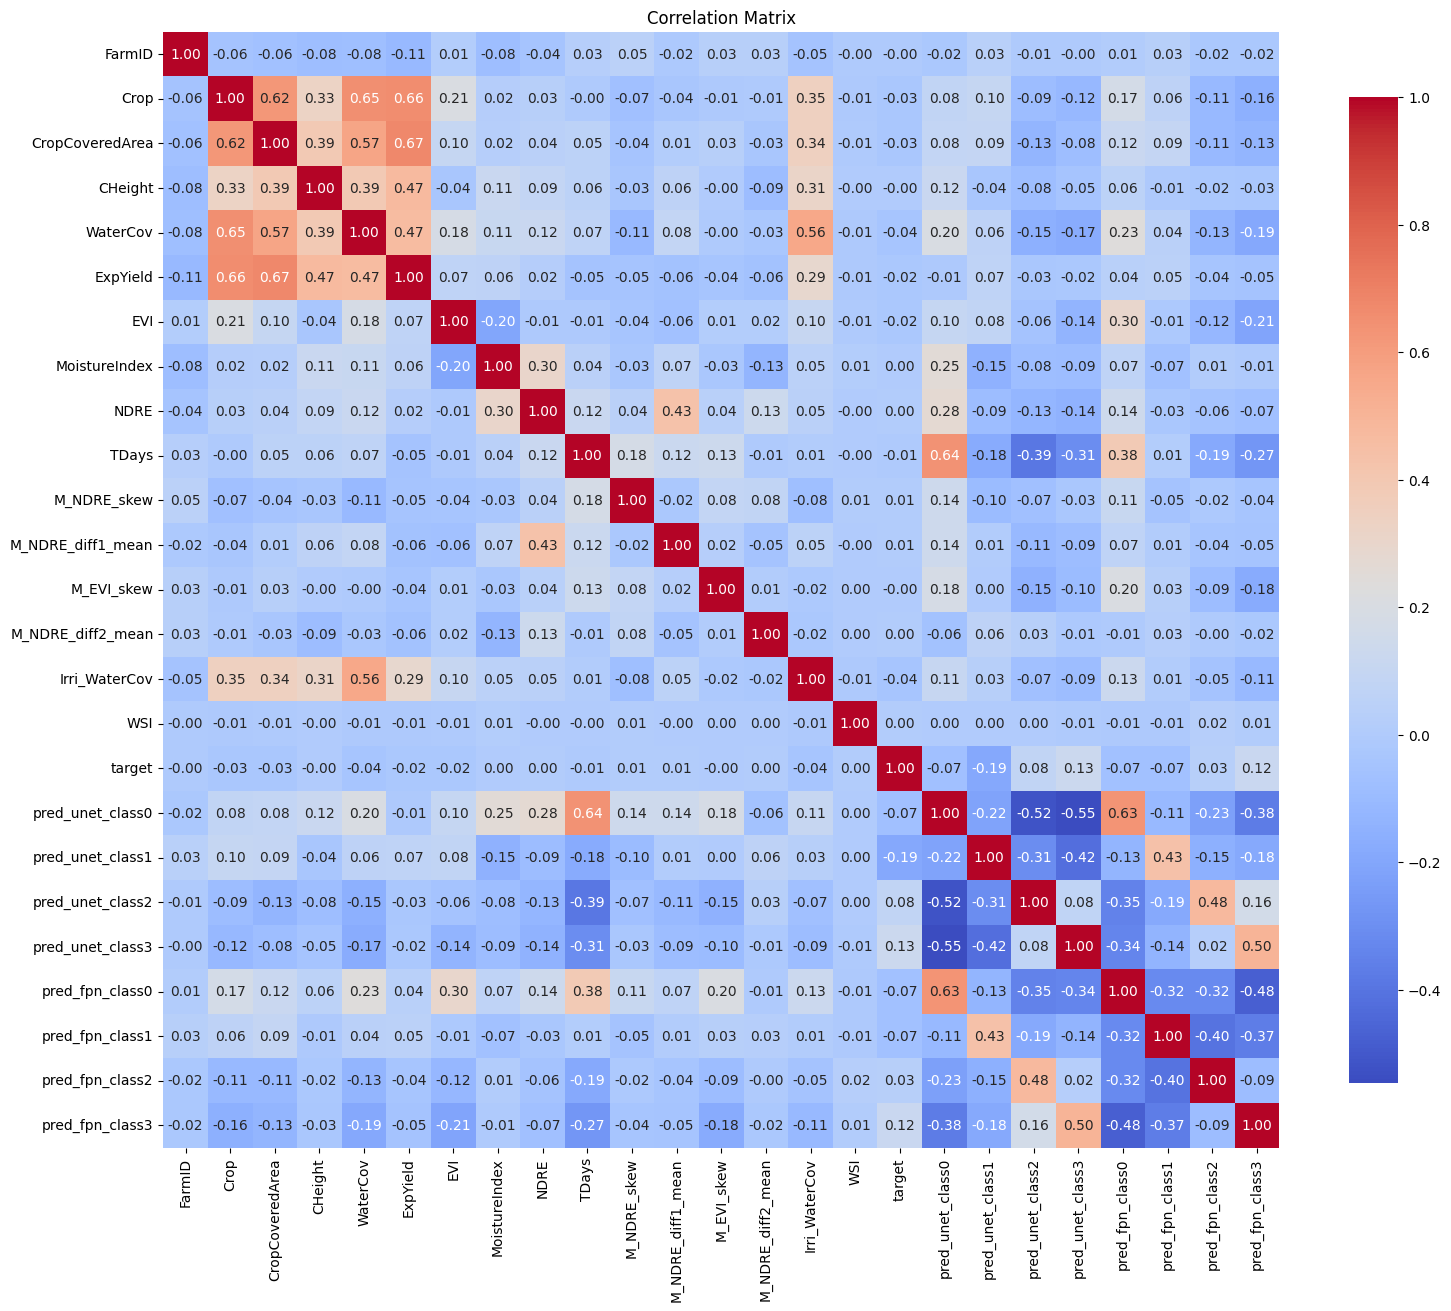

In [3860]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train' is your DataFrame
correlation_matrix = data.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

In [3863]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = data.drop(columns=['target', 'FarmID'])
y = data['target'].astype(int)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, 
                                                      stratify=y, random_state=42)

X_train.shape, X_valid.shape

((7079, 23), (787, 23))

In [3865]:
opt.best_params_

OrderedDict([('colsample_bytree', 0.8985096588037464),
             ('learning_rate', 0.1),
             ('max_depth', 29),
             ('min_child_samples', 53),
             ('num_leaves', 93),
             ('reg_alpha', 0.9028585465330436),
             ('reg_lambda', 0.5728274342198443),
             ('subsample', 1.0)])

In [3867]:
best_params={ 'learning_rate': 0.1,
    'max_depth': 30,
    'num_leaves': 100,
    #'min_child_samples': 40,
}

In [3869]:
comb_lgbm = LGBMClassifier(
    objective='multiclass',
    class_weight='balanced',
    **best_params,
    random_state=42,)
comb_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4963
[LightGBM] [Info] Number of data points in the train set: 7079, number of used features: 23
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


LGBMClassifier(class_weight='balanced', max_depth=30, num_leaves=100,
               objective='multiclass', random_state=42)

In [3871]:
# Predict on the validation set
y_pred = comb_lgbm.predict(X_valid)

# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.94      0.95      0.94       649
    Diseased       0.69      0.79      0.73        47
       Pests       0.78      0.65      0.71        49
    Stressed       0.79      0.71      0.75        42

    accuracy                           0.91       787
   macro avg       0.80      0.78      0.78       787
weighted avg       0.91      0.91      0.91       787


Weighted F1 Score: 0.90650590775804


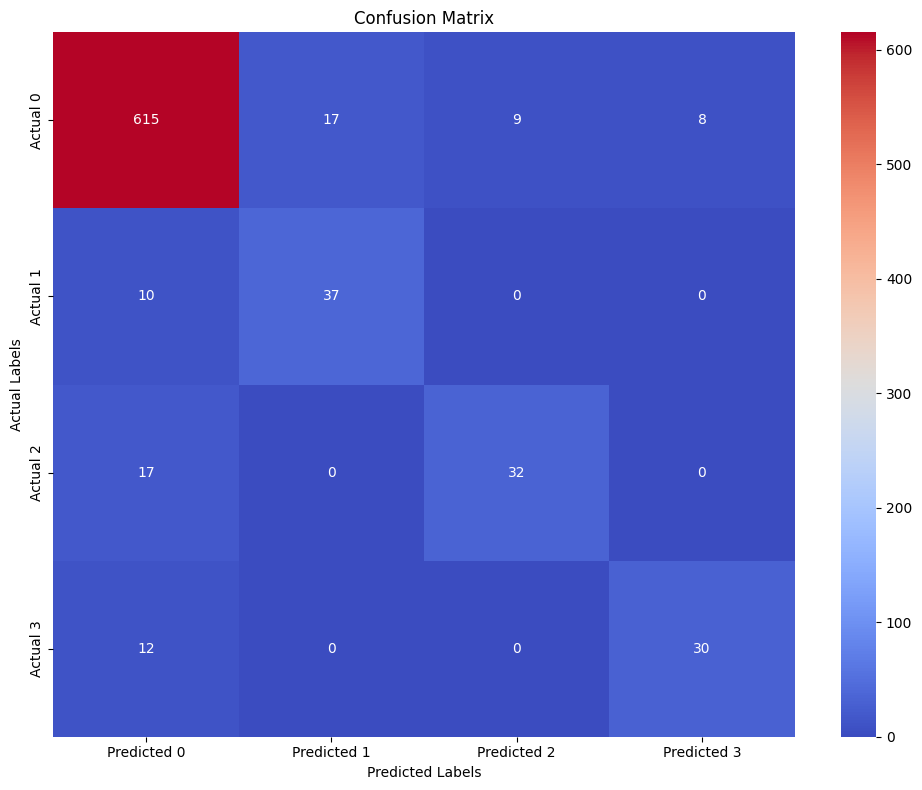

In [3873]:
plot_confusion_matrix(y_valid, y_pred)

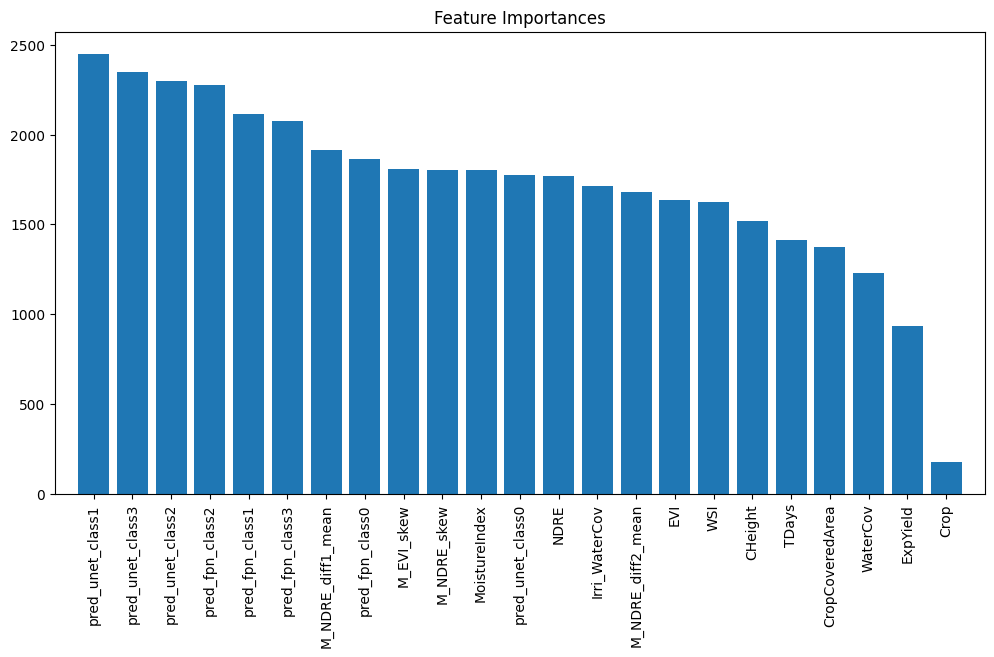

In [3875]:
# Get feature importances
importances = comb_lgbm.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [3877]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_lgbm = CalibratedClassifierCV(comb_lgbm, method='isotonic')
calibrated_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4962
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 23
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4961
[LightGBM] [Info] Number of data points in the train set: 5663, number of u

CalibratedClassifierCV(estimator=LGBMClassifier(class_weight='balanced',
                                                max_depth=30, num_leaves=100,
                                                objective='multiclass',
                                                random_state=42),
                       method='isotonic')

In [3879]:
# Predict on the validation set
y_pred = calibrated_lgbm.predict(X_valid)

# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.93      0.96      0.95       649
    Diseased       0.74      0.74      0.74        47
       Pests       0.85      0.59      0.70        49
    Stressed       0.81      0.71      0.76        42

    accuracy                           0.91       787
   macro avg       0.84      0.75      0.79       787
weighted avg       0.91      0.91      0.91       787


Weighted F1 Score: 0.9106170664101737


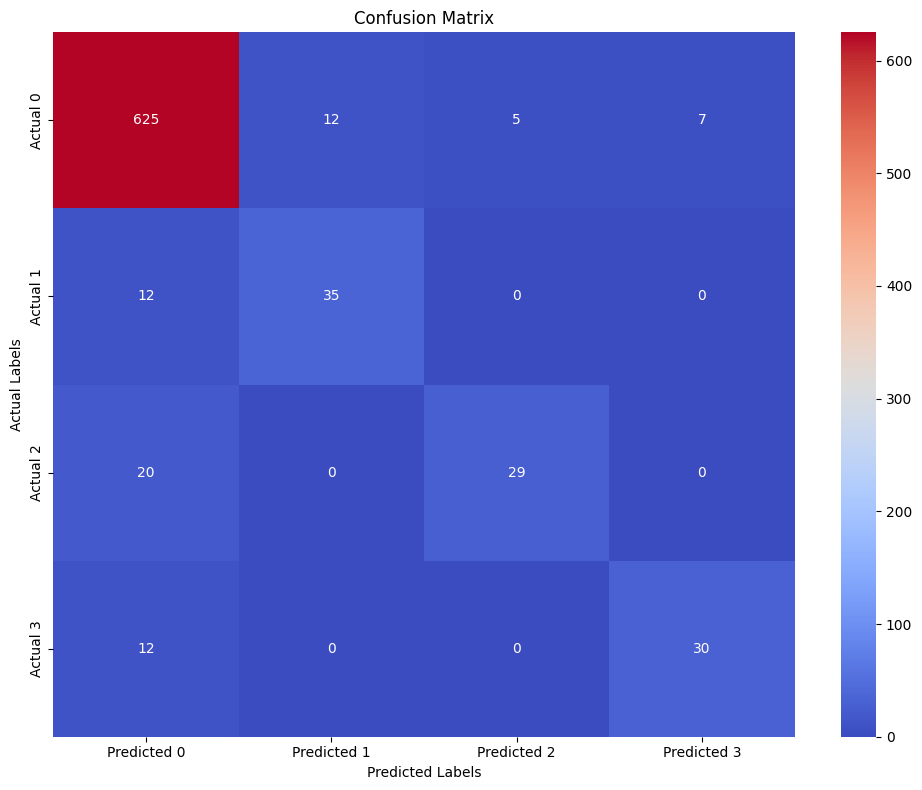

In [3881]:
plot_confusion_matrix(y_valid, y_pred)

### Test dataset

In [3883]:
test_ppdf = pd.read_csv('data/Model/Output/test_dl_pp_final.csv')
test_ppdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2718 entries, 0 to 2717
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pred_unet_class0  2718 non-null   float64
 1   pred_unet_class1  2718 non-null   float64
 2   pred_unet_class2  2718 non-null   float64
 3   pred_unet_class3  2718 non-null   float64
 4   FarmID            2718 non-null   int64  
 5   pred_fpn_class0   2718 non-null   float64
 6   pred_fpn_class1   2718 non-null   float64
 7   pred_fpn_class2   2718 non-null   float64
 8   pred_fpn_class3   2718 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 191.2 KB


In [3885]:
skewed_features = ['CropCoveredArea', 'CHeight', 'WaterCov', 'ExpYield']
for col in skewed_features:
    test_data[col] = np.log1p(test_data[col])

In [3888]:
tst_sample = test_data[sel_cols]
# Calculate features 
tst_sample['Irri_WaterCov'] = tst_sample['IrriCount'] * tst_sample['WaterCov']
tst_sample['WSI'] = (tst_sample['NDWI'] - tst_sample['NDVI']) / (tst_sample['NDWI'] + tst_sample['NDVI'])

test_unet_ppdf = pd.merge(tst_sample, test_ppdf, on='FarmID', how='left')
test_unet_ppdf.drop(columns='FarmID', inplace=True)
test_unet_ppdf.drop(columns=drp_col, inplace=True)
test_unet_ppdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2718 entries, 0 to 2717
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Crop               2718 non-null   int64  
 1   CropCoveredArea    2718 non-null   float64
 2   CHeight            2718 non-null   float64
 3   WaterCov           2718 non-null   float64
 4   ExpYield           2718 non-null   float64
 5   EVI                2718 non-null   float64
 6   MoistureIndex      2718 non-null   float64
 7   NDRE               2718 non-null   float64
 8   TDays              2718 non-null   int64  
 9   M_NDRE_skew        2718 non-null   float64
 10  M_NDRE_diff1_mean  2718 non-null   float64
 11  M_EVI_skew         2718 non-null   float64
 12  M_NDRE_diff2_mean  2718 non-null   float64
 13  Irri_WaterCov      2718 non-null   float64
 14  WSI                2718 non-null   float64
 15  pred_unet_class0   2718 non-null   float64
 16  pred_unet_class1   2718 

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/536786820.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/536786820.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [3890]:
test_unet_ppdf.head()

Crop  CropCoveredArea   CHeight  WaterCov  ExpYield       EVI  \
0     0         0.522458  0.508498  0.506635  0.469375  0.087392   
1     0         0.517233  0.507277  0.505971  0.452118  0.186357   
2     0         0.520505  0.507277  0.490534  0.465906  0.071787   
3     0         0.517233  0.512708  0.500561  0.461966  0.117750   
4     0         0.516493  0.509080  0.501429  0.452118  0.138619   

   MoistureIndex      NDRE  TDays  M_NDRE_skew  ...  Irri_WaterCov        WSI  \
0      -0.055158  0.018439    231    -0.788074  ...       1.519906   5.670069   
1      -0.004085  0.007916    357     1.813854  ...       0.505971  14.251415   
2       0.007513  0.004905    187     0.109391  ...       0.490534   4.941216   
3       0.056209  0.011836    318     1.595228  ...       1.001122   7.649525   
4       0.022174  0.007432    258     1.364228  ...       0.501429   8.995889   

   pred_unet_class0  pred_unet_class1  pred_unet_class2  pred_unet_class3  \
0          2.337027         -2.064490         -4.709585         -7.678393   
1          2.025096         -6.238536         -1.588382         -4.812102   
2          1.341458        -11.071153         -1.999423          2.765314   
3          2.778027         -2.637563         -9.685420         -5.772174   
4          1.125619        -10.149100         -6.032385          5.409468   

   pred_fpn_class0  pred_fpn_class1  pred_fpn_class2  pred_fpn_class3  
0         0.932914        -0.832578         0.544682        -3.192532  
1         0.873023        -2.190287        -0.107581        -0.662280  
2         1.247302        -1.289443        -3.520918         1.260186  
3         3.371587         0.250977         0.240628       -13.238114  
4         1.177913        -1.648117         0.998828        -3.964353  

[5 rows x 23 columns]

In [3919]:
# Predict submission
lg_predictions = calibrated_lgbm.predict(test_unet_ppdf) #calibrated_lgbm
lg_predictions

array([0, 0, 0, ..., 0, 3, 0])

In [3921]:
category_mapper

{'Healthy': 0, 'Diseased': 1, 'Pests': 2, 'Stressed': 3}

In [3923]:
t_data = pd.read_csv(indices_tfile, index_col=0)
t_data['Target'] = lg_predictions
t_data['Target'] = t_data['Target'].astype(int).map(idx_to_category_mapper)
subm_df = t_data[['FarmID', 'Target']]

In [3925]:
subm_df.groupby('Target').count()

FarmID
Target          
Diseased      52
Healthy     2586
Pests         46
Stressed      34

In [3913]:
clg_predictions = calibrated_lgbm.predict(test_unet_ppdf) #calibrated_lgbm
pd.Series(clg_predictions).value_counts()

0    2586
1      52
2      46
3      34
Name: count, dtype: int64

In [3927]:
subm_df.to_csv('data/sub_files/submission_final-1.csv', index=0)

In [3787]:
pd.read_csv('data/sub_files/submission_last-10.csv').groupby('Target').count()

FarmID
Target          
Diseased      40
Healthy     2609
Pests         53
Stressed      16

In [2390]:
pd.read_csv('data/sub_files/submission_02-08-11.csv').groupby('Target').count()

FarmID
Target          
Diseased      51
Healthy     2568
Pests         55
Stressed      44

## Model Tuning

In [701]:
import optuna
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from optuna.integration import LightGBMTunerCV
from sklearn.metrics import f1_score, classification_report
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y_train)),
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'class_weight': 'balanced',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_cv_train, X_cv_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_cv_train, y_cv_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = LGBMClassifier(**params)
        model.fit(X_cv_train, y_cv_train, eval_set=[(X_cv_valid, y_cv_valid)], 
                 callbacks=[early_stopping(stopping_rounds=20), log_evaluation(10)], 
                  )
        
        y_pred = model.predict(X_cv_valid)
        scores.append(f1_score(y_cv_valid, y_pred, average='weighted'))
    
    return np.mean(scores)

In [703]:
# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-02-08 19:22:43,113] A new study created in memory with name: no-name-cf8bdb8e-56ff-43cc-b428-9dd8a26ee072
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.352985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[I 2025-02-08 19:22:43,634] Trial 0 finished with value: 0.9279573416625194 and parameters: {'learning_rate': 0.43901020178277866, 'num_leaves': 28, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.678423162993518, 'colsample_bytree': 0.7950741883937001, 'reg_alpha': 2.421487697604338, 'reg_lambda': 0.012218536501734607}. Best is trial 0 with value: 0.9279573416625194.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's multi_logloss: 0.352735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's multi_logloss: 0.310355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's multi_logloss: 0.431599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-08 19:22:44,122] Trial 1 finished with value: 0.9290881450982799 and parameters: {'learning_rate': 0.47316428797126736, 'num_leaves': 26, 'max_depth': 7, 'min_child_samples': 43, 'subsample': 0.6275772184360622, 'colsample_bytree': 0.5170537928748172, 'reg_alpha': 0.020336811182503543, 'reg_lambda': 0.23370686420797315}. Best is trial 1 with value: 0.9290881450982799.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3189
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's multi_logloss: 0.373504
[LightGBM] [Warning] 

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's multi_logloss: 0.459652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-02-08 19:22:44,545] Trial 2 finished with value: 0.9158166599690276 and parameters: {'learning_rate': 0.19404308545038798, 'num_leaves': 17, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.9125576405246028, 'colsample_bytree': 0.7151334306972854, 'reg_alpha': 0.5509318452185248, 'reg_lambda': 0.82756946073445}. Best is trial 1 with value: 0.9290881450982799.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[30]	valid_0's multi_logloss: 0.510065
[40]	valid_0's multi_logloss: 0.489578
[50]	valid_0's multi_logloss: 0.467143
[60]	valid_0's multi_logloss: 0.448263
[70]	valid_0's multi_logloss: 0.433974
[80]	valid_0's multi_logloss: 0.418449
[90]	valid_0's multi_logloss: 0.403852
[100]	valid_0's multi_logloss: 0.391076
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.391076
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.57

[I 2025-02-08 19:22:44,882] Trial 3 finished with value: 0.9088080924385336 and parameters: {'learning_rate': 0.35619260117981894, 'num_leaves': 4, 'max_depth': 0, 'min_child_samples': 25, 'subsample': 0.6934581561966098, 'colsample_bytree': 0.8563267985736867, 'reg_alpha': 0.47652213922287356, 'reg_lambda': 0.03426824507662023}. Best is trial 1 with value: 0.9290881450982799.


[50]	valid_0's multi_logloss: 0.438648
[60]	valid_0's multi_logloss: 0.421416
[70]	valid_0's multi_logloss: 0.406496
[80]	valid_0's multi_logloss: 0.394127
[90]	valid_0's multi_logloss: 0.381097
[100]	valid_0's multi_logloss: 0.370394
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.370394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3194
[LightGBM] [Info] Number of data points in the train set: 5664, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.543124
[20]	valid_0's multi_logloss: 0.51309
[30]	valid_0's multi_logloss: 0.491

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[90]	valid_0's multi_logloss: 0.440368
[100]	valid_0's multi_logloss: 0.428184
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.428184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.847021
[20]	valid_0's multi_logloss: 0.652639
[30]	valid_0's multi_logloss: 0.580442
[40]	valid_0's multi_logloss: 0.537356
[50]	valid_0's multi_logloss: 0.513284
[60]	valid_0's multi_logloss: 0.495952
[70]	valid_0's multi_logloss: 0.48

[I 2025-02-08 19:22:45,528] Trial 4 finished with value: 0.9031352103502275 and parameters: {'learning_rate': 0.07447425687574993, 'num_leaves': 11, 'max_depth': 8, 'min_child_samples': 37, 'subsample': 0.9185892564977323, 'colsample_bytree': 0.6489783169342641, 'reg_alpha': 0.05810426964761737, 'reg_lambda': 7.832152412112362}. Best is trial 1 with value: 0.9290881450982799.


[20]	valid_0's multi_logloss: 0.631024
[30]	valid_0's multi_logloss: 0.552721
[40]	valid_0's multi_logloss: 0.510768
[50]	valid_0's multi_logloss: 0.482007
[60]	valid_0's multi_logloss: 0.463592
[70]	valid_0's multi_logloss: 0.447263
[80]	valid_0's multi_logloss: 0.434775
[90]	valid_0's multi_logloss: 0.42211
[100]	valid_0's multi_logloss: 0.41055
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.41055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, 

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[60]	valid_0's multi_logloss: 0.299119
[70]	valid_0's multi_logloss: 0.293628
[80]	valid_0's multi_logloss: 0.290433
[90]	valid_0's multi_logloss: 0.289894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's multi_logloss: 0.289622
Did not meet early stopping. Best iteration is:
[92]	valid_0's multi_logloss: 0.289458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[1

[I 2025-02-08 19:22:46,511] Trial 5 finished with value: 0.9315981185391694 and parameters: {'learning_rate': 0.22678176799041821, 'num_leaves': 21, 'max_depth': -1, 'min_child_samples': 46, 'subsample': 0.8433505798864536, 'colsample_bytree': 0.632757697635251, 'reg_alpha': 1.0224219216125376, 'reg_lambda': 5.043244950169814}. Best is trial 5 with value: 0.9315981185391694.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's multi_logloss: 0.291449
Did not meet early stopping. Best iteration is:
[92]	valid_0's multi_logloss: 0.289775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	val

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[10]	valid_0's multi_logloss: 0.415822
[20]	valid_0's multi_logloss: 0.342969
[30]	valid_0's multi_logloss: 0.332252
[40]	valid_0's multi_logloss: 0.334492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.331529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the tr

[I 2025-02-08 19:22:47,387] Trial 6 finished with value: 0.9329091502345064 and parameters: {'learning_rate': 0.2717979085701753, 'num_leaves': 28, 'max_depth': 41, 'min_child_samples': 5, 'subsample': 0.6154726142448267, 'colsample_bytree': 0.8401358223432948, 'reg_alpha': 0.9722962977718442, 'reg_lambda': 0.6642928985546943}. Best is trial 6 with value: 0.9329091502345064.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's multi_logloss: 0.294495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.287185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true`

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's multi_logloss: 0.38624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-02-08 19:22:48,097] Trial 7 finished with value: 0.933830035282606 and parameters: {'learning_rate': 0.3215577659582434, 'num_leaves': 48, 'max_depth': 23, 'min_child_samples': 42, 'subsample': 0.93170610228872, 'colsample_bytree': 0.5952448585344656, 'reg_alpha': 1.2050681001984165, 'reg_lambda': 1.1423509791340496}. Best is trial 7 with value: 0.933830035282606.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[30]	valid_0's multi_logloss: 0.290047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.272694
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.349545
[20]	valid_0's multi_logloss: 0.341939
[30]	valid_0's multi_logloss: 0.363747
Early stopping, best iteration is:
[15]	valid_0's multi_logloss: 0.336665
[LightGBM] [Info] Auto-choosing col-wise multi-threading

[I 2025-02-08 19:22:48,901] Trial 8 finished with value: 0.9336142926951945 and parameters: {'learning_rate': 0.4328112641532739, 'num_leaves': 44, 'max_depth': 50, 'min_child_samples': 24, 'subsample': 0.8570349243179651, 'colsample_bytree': 0.7011543725246654, 'reg_alpha': 0.040468413639227534, 'reg_lambda': 1.6873692385082348}. Best is trial 7 with value: 0.933830035282606.


[20]	valid_0's multi_logloss: 0.305281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's multi_logloss: 0.320118
Early stopping, best iteration is:
[15]	valid_0's multi_logloss: 0.296522
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3194
[LightGBM] [Info] Number of data points in the train set: 5664, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.299396
[20]	valid_0's multi_logloss: 0.298044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[20]	valid_0's multi_logloss: 0.29039
[30]	valid_0's multi_logloss: 0.29226
[40]	valid_0's multi_logloss: 0.302903
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.286574
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.3902
[20]	valid_0's multi_logloss: 0.349228
[30]	valid_0's multi_logloss: 0.364856
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.347206
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

[I 2025-02-08 19:22:49,491] Trial 9 finished with value: 0.9329032451210347 and parameters: {'learning_rate': 0.44385567890516436, 'num_leaves': 25, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.7626989175523149, 'colsample_bytree': 0.6583499555093848, 'reg_alpha': 0.21481799020341155, 'reg_lambda': 0.6511384084544635}. Best is trial 7 with value: 0.933830035282606.


[10]	valid_0's multi_logloss: 0.339994
[20]	valid_0's multi_logloss: 0.300811
[30]	valid_0's multi_logloss: 0.307426
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.297688
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Train

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-08 19:22:50,809] Trial 10 finished with value: 0.901852610682873 and parameters: {'learning_rate': 0.01145459259369841, 'num_leaves': 48, 'max_depth': 29, 'min_child_samples': 35, 'subsample': 0.5049137003161548, 'colsample_bytree': 0.9944435151600617, 'reg_alpha': 7.24049366231352, 'reg_lambda': 0.14943738573206364}. Best is trial 7 with value: 0.933830035282606.
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.353032
[20]	valid_0's multi_logloss: 0.275803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's multi_logloss: 0.272478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[I 2025-02-08 19:22:51,650] Trial 11 finished with value: 0.9332385286908028 and parameters: {'learning_rate': 0.34058023517704733, 'num_leaves': 50, 'max_depth': 48, 'min_child_samples': 18, 'subsample': 0.9689011245941156, 'colsample_bytree': 0.5232638873282455, 'reg_alpha': 0.10688773630744525, 'reg_lambda': 2.274058065958944}. Best is trial 7 with value: 0.933830035282606.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's multi_logloss: 0.303449
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.287136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3194
[LightGBM] [Info] Number of data points in the train set: 5664, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.349017
[20]	valid_0's multi_logloss: 0.289977
[30]	valid_0's mult

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[10]	valid_0's multi_logloss: 0.367105
[20]	valid_0's multi_logloss: 0.292953
[30]	valid_0's multi_logloss: 0.289385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's multi_logloss: 0.298502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.287616
[LightGBM] [Info] Au

[I 2025-02-08 19:22:52,667] Trial 12 finished with value: 0.9328418599969777 and parameters: {'learning_rate': 0.3582621386270003, 'num_leaves': 40, 'max_depth': 29, 'min_child_samples': 50, 'subsample': 0.8405467150950405, 'colsample_bytree': 0.5851799640930366, 'reg_alpha': 0.030237458111519115, 'reg_lambda': 2.0450756667807464}. Best is trial 7 with value: 0.933830035282606.


[10]	valid_0's multi_logloss: 0.352425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's multi_logloss: 0.290773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's multi_logloss: 0.294766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[30]	valid_0's multi_logloss: 0.281973
[40]	valid_0's multi_logloss: 0.290036
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.281944
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.392271
[20]	valid_0's multi_logloss: 0.328577
[30]	valid_0's multi_logloss: 0.333241
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.327699
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0002

[I 2025-02-08 19:22:53,645] Trial 13 finished with value: 0.9315165075098137 and parameters: {'learning_rate': 0.29300169923381536, 'num_leaves': 40, 'max_depth': 21, 'min_child_samples': 33, 'subsample': 0.8190923993810483, 'colsample_bytree': 0.7158320779771573, 'reg_alpha': 0.010648574308016842, 'reg_lambda': 2.150972718242559}. Best is trial 7 with value: 0.933830035282606.
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.31475
[20]	valid_0's multi_logloss: 0.28421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's multi_logloss: 0.299397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2025-02-08 19:22:54,252] Trial 14 finished with value: 0.9339462167371728 and parameters: {'learning_rate': 0.40069207525100864, 'num_leaves': 40, 'max_depth': 38, 'min_child_samples': 16, 'subsample': 0.97977098156895, 'colsample_bytree': 0.5869398366934132, 'reg_alpha': 0.16361753634357115, 'reg_lambda': 0.09530611662680807}. Best is trial 14 with value: 0.9339462167371728.


[20]	valid_0's multi_logloss: 0.301409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's multi_logloss: 0.32538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[10]	valid_0's multi_logloss: 0.536797
[20]	valid_0's multi_logloss: 0.358031
[30]	valid_0's multi_logloss: 0.297813
[40]	valid_0's multi_logloss: 0.276802
[50]	valid_0's multi_logloss: 0.27509
[60]	valid_0's multi_logloss: 0.27918
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.273917
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.537363
[20]	valid_0's multi_logloss: 0.367311
[30]	valid_0's multi_logloss: 0.32005
[40]	valid_0'

[I 2025-02-08 19:22:55,217] Trial 15 finished with value: 0.935143415951677 and parameters: {'learning_rate': 0.1570985382186016, 'num_leaves': 35, 'max_depth': 35, 'min_child_samples': 15, 'subsample': 0.9985978313012551, 'colsample_bytree': 0.5642683560792875, 'reg_alpha': 0.14300963822602675, 'reg_lambda': 0.07768074080973622}. Best is trial 15 with value: 0.935143415951677.


[50]	valid_0's multi_logloss: 0.276687
[60]	valid_0's multi_logloss: 0.286509
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.272417
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.59856
[20]	valid_0's multi_logloss: 0.398115
[30]	valid_0's multi_logloss: 0.3208
[40]	valid_0's multi_logloss: 0.286021
[50]	valid_0's multi_logloss: 0.273665


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[60]	valid_0's multi_logloss: 0.270534
[70]	valid_0's multi_logloss: 0.272096
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.270381
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.597034
[20]	valid_0's multi_logloss: 0.409899
[30]	valid_0's multi_logloss: 0.341998
[40]	valid_0's multi_logloss: 0.318846
[50]	valid_0's multi_logloss: 0.313281
[60]	valid_0's multi_logloss: 0.317534
Early stopping, best iteration is:
[49]	valid_0's

[I 2025-02-08 19:22:56,325] Trial 16 finished with value: 0.9362216120405996 and parameters: {'learning_rate': 0.1284783762797633, 'num_leaves': 34, 'max_depth': 39, 'min_child_samples': 15, 'subsample': 0.998166609471673, 'colsample_bytree': 0.563702732697457, 'reg_alpha': 0.14913103087722174, 'reg_lambda': 0.08276202005141323}. Best is trial 16 with value: 0.9362216120405996.


[70]	valid_0's multi_logloss: 0.279708
Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.27185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.601135
[20]	valid_0's multi_logloss: 0.390805
[30]	valid_0's multi_logloss: 0.315105
[40]	valid_0's multi_logloss: 0.28328
[50]	valid_0's multi_logloss: 0.271961
[60]	valid_0's multi_logloss: 0.269766


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[70]	valid_0's multi_logloss: 0.272617
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.268427
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.603118
[20]	valid_0's multi_logloss: 0.401437
[30]	valid_0's multi_logloss: 0.332704
[40]	valid_0's multi_logloss: 0.312916
[50]	valid_0's multi_logloss: 0.310051
[60]	valid_0's multi_logloss: 0.318175
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.309304
[LightGBM] [In

[I 2025-02-08 19:22:57,471] Trial 17 finished with value: 0.9368082010808456 and parameters: {'learning_rate': 0.13762929712492408, 'num_leaves': 34, 'max_depth': 37, 'min_child_samples': 14, 'subsample': 0.9893553944969165, 'colsample_bytree': 0.5014389372185333, 'reg_alpha': 0.08076911751718788, 'reg_lambda': 0.035307821013724566}. Best is trial 17 with value: 0.9368082010808456.


[50]	valid_0's multi_logloss: 0.270669
[60]	valid_0's multi_logloss: 0.272939
[70]	valid_0's multi_logloss: 0.281071
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.27041
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.620483
[20]	valid_0's multi_logloss: 0.410295
[30]	valid_0's multi_logloss: 0.325593
[40]	valid_0's multi_logloss: 0.286768


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[50]	valid_0's multi_logloss: 0.27168
[60]	valid_0's multi_logloss: 0.266384
[70]	valid_0's multi_logloss: 0.269752
[80]	valid_0's multi_logloss: 0.275472
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.266176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.631069
[20]	valid_0's multi_logloss: 0.419117
[30]	valid_0's multi_logloss: 0.344292
[40]	valid_0's multi_logloss: 0.320214
[50]	valid_0's multi_logloss: 0.314951
[60]	valid_

[I 2025-02-08 19:22:58,605] Trial 18 finished with value: 0.9371232332077973 and parameters: {'learning_rate': 0.12853683437828176, 'num_leaves': 34, 'max_depth': 44, 'min_child_samples': 12, 'subsample': 0.8975291032512726, 'colsample_bytree': 0.5272535584833588, 'reg_alpha': 0.06940502848522265, 'reg_lambda': 0.026550477482000408}. Best is trial 18 with value: 0.9371232332077973.


[30]	valid_0's multi_logloss: 0.312726
[40]	valid_0's multi_logloss: 0.280565
[50]	valid_0's multi_logloss: 0.271878
[60]	valid_0's multi_logloss: 0.272033
[70]	valid_0's multi_logloss: 0.278466
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.269921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.747863
[20]	valid_0's multi_logloss: 0.501552


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[30]	valid_0's multi_logloss: 0.390246
[40]	valid_0's multi_logloss: 0.32898
[50]	valid_0's multi_logloss: 0.291709
[60]	valid_0's multi_logloss: 0.274413
[70]	valid_0's multi_logloss: 0.26532
[80]	valid_0's multi_logloss: 0.261938
[90]	valid_0's multi_logloss: 0.262674
[100]	valid_0's multi_logloss: 0.265091
Did not meet early stopping. Best iteration is:
[85]	valid_0's multi_logloss: 0.261361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.75494

[I 2025-02-08 19:22:59,980] Trial 19 finished with value: 0.936489934155809 and parameters: {'learning_rate': 0.08895811240131969, 'num_leaves': 34, 'max_depth': 42, 'min_child_samples': 11, 'subsample': 0.8891639484392863, 'colsample_bytree': 0.5032324946630349, 'reg_alpha': 0.06486723599735637, 'reg_lambda': 0.011858738617360899}. Best is trial 18 with value: 0.9371232332077973.


[40]	valid_0's multi_logloss: 0.320456
[50]	valid_0's multi_logloss: 0.289202
[60]	valid_0's multi_logloss: 0.273589
[70]	valid_0's multi_logloss: 0.268645
[80]	valid_0's multi_logloss: 0.267603
[90]	valid_0's multi_logloss: 0.272894
Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.266776
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.0997
[20]	valid_0's multi_logloss: 0.909329
[30]	valid_0's multi_logloss: 0.7756
[40]	valid_0's multi_logloss: 0.678672
[50]	valid_0's multi_logloss: 0.606458
[60]	valid_0's multi_logloss: 0.550628
[70]	valid_0's multi_logloss: 0.507255
[80]	valid_0's multi_logloss: 0.47273
[90]	valid_0's multi_logloss: 0.444789
[100]	valid_0's multi_logloss: 0.421419
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.421419
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Inf

[I 2025-02-08 19:23:01,620] Trial 20 finished with value: 0.918008687628751 and parameters: {'learning_rate': 0.020333834023782346, 'num_leaves': 32, 'max_depth': 32, 'min_child_samples': 19, 'subsample': 0.779414170763853, 'colsample_bytree': 0.9385348106648808, 'reg_alpha': 0.012295737555964473, 'reg_lambda': 0.027962428340255963}. Best is trial 18 with value: 0.9371232332077973.


[70]	valid_0's multi_logloss: 0.491253
[80]	valid_0's multi_logloss: 0.456117
[90]	valid_0's multi_logloss: 0.427099
[100]	valid_0's multi_logloss: 0.402533
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.402533
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.718053
[20]	valid_0's multi_logloss: 0.473317


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[30]	valid_0's multi_logloss: 0.368586
[40]	valid_0's multi_logloss: 0.313237
[50]	valid_0's multi_logloss: 0.282259
[60]	valid_0's multi_logloss: 0.269146
[70]	valid_0's multi_logloss: 0.263024
[80]	valid_0's multi_logloss: 0.262733
[90]	valid_0's multi_logloss: 0.265502
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.262218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.721223
[20]	valid_0's multi_logloss: 0.480351
[30]	valid

[I 2025-02-08 19:23:03,237] Trial 21 finished with value: 0.9370631905098229 and parameters: {'learning_rate': 0.09614591052934399, 'num_leaves': 36, 'max_depth': 44, 'min_child_samples': 11, 'subsample': 0.9069586309493582, 'colsample_bytree': 0.5011886166219168, 'reg_alpha': 0.07028152433231753, 'reg_lambda': 0.012265111894384432}. Best is trial 18 with value: 0.9371232332077973.


[80]	valid_0's multi_logloss: 0.271674
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.268061
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.631319
[20]	valid_0's multi_logloss: 0.409296
[30]	valid_0's multi_logloss: 0.323791
[40]	valid_0's multi_logloss: 0.283719
[50]	valid_0's multi_logloss: 0.266554


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[60]	valid_0's multi_logloss: 0.263187
[70]	valid_0's multi_logloss: 0.267125
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.262689
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.641529
[20]	valid_0's multi_logloss: 0.420281
[30]	valid_0's multi_logloss: 0.340489
[40]	valid_0's multi_logloss: 0.312152
[50]	valid_0's multi_logloss: 0.305963
[60]	valid_0's multi_logloss: 0.31058
[70]	valid_0's multi_logloss: 0.31903
Early stoppi

[I 2025-02-08 19:23:04,522] Trial 22 finished with value: 0.9379590799129204 and parameters: {'learning_rate': 0.12166922279040863, 'num_leaves': 37, 'max_depth': 46, 'min_child_samples': 11, 'subsample': 0.9454185863148876, 'colsample_bytree': 0.503449273730797, 'reg_alpha': 0.07740865375398932, 'reg_lambda': 0.027092898787545394}. Best is trial 22 with value: 0.9379590799129204.


[10]	valid_0's multi_logloss: 0.616494
[20]	valid_0's multi_logloss: 0.394084
[30]	valid_0's multi_logloss: 0.313693
[40]	valid_0's multi_logloss: 0.281496
[50]	valid_0's multi_logloss: 0.272242
[60]	valid_0's multi_logloss: 0.273664
[70]	valid_0's multi_logloss: 0.28114
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.271747


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.77876
[20]	valid_0's multi_logloss: 0.530304
[30]	valid_0's multi_logloss: 0.412562
[40]	valid_0's multi_logloss: 0.344798
[50]	valid_0's multi_logloss: 0.304882
[60]	valid_0's multi_logloss: 0.282591
[70]	valid_0's multi_logloss: 0.270095
[80]	valid_0's multi_logloss: 0.265039
[90]	valid_0's multi_logloss: 0.263293
[100]	valid_0's multi_logloss: 0.264676
Did not meet early stopping. Best iteration i

[I 2025-02-08 19:23:06,284] Trial 23 finished with value: 0.9371015946604366 and parameters: {'learning_rate': 0.07192844659940531, 'num_leaves': 39, 'max_depth': 45, 'min_child_samples': 9, 'subsample': 0.8806232785946032, 'colsample_bytree': 0.5565850608920868, 'reg_alpha': 0.025221026014632046, 'reg_lambda': 0.020230466318378076}. Best is trial 22 with value: 0.9379590799129204.


[50]	valid_0's multi_logloss: 0.299
[60]	valid_0's multi_logloss: 0.280284
[70]	valid_0's multi_logloss: 0.272415
[80]	valid_0's multi_logloss: 0.270053
[90]	valid_0's multi_logloss: 0.270714
Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.269169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.439023
[20]	valid_0's multi_logloss: 0.296054
[30]	valid_0's multi_logloss: 0.265603
[40]	valid_0's multi_logloss: 0.275017
[50]	valid_0's multi_logloss: 0.29417
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.265603
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from sco

[I 2025-02-08 19:23:07,157] Trial 24 finished with value: 0.9354915831602091 and parameters: {'learning_rate': 0.19459744853321215, 'num_leaves': 44, 'max_depth': 46, 'min_child_samples': 21, 'subsample': 0.9423715072758697, 'colsample_bytree': 0.5536988740066283, 'reg_alpha': 0.02409232133788313, 'reg_lambda': 0.02325971527407032}. Best is trial 22 with value: 0.9379590799129204.


Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.267817
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.815632
[20]	valid_0's multi_logloss: 0.565093
[30]	valid_0's multi_logloss: 0.44124
[40]	valid_0's multi_logloss: 0.366767
[50]	valid_0's multi_logloss: 0.32205


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[60]	valid_0's multi_logloss: 0.294388
[70]	valid_0's multi_logloss: 0.278551
[80]	valid_0's multi_logloss: 0.270001
[90]	valid_0's multi_logloss: 0.264857
[100]	valid_0's multi_logloss: 0.261766
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.261766
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.81962
[20]	valid_0's multi_logloss: 0.568222
[30]	valid_0's multi_logloss: 0.446292
[40]	valid_0's multi_logloss: 0.380

[I 2025-02-08 19:23:09,150] Trial 25 finished with value: 0.935084795754246 and parameters: {'learning_rate': 0.05884668485265551, 'num_leaves': 43, 'max_depth': 50, 'min_child_samples': 11, 'subsample': 0.7907981499631734, 'colsample_bytree': 0.6221478029300346, 'reg_alpha': 0.28815716408224673, 'reg_lambda': 0.05231446383097939}. Best is trial 22 with value: 0.9379590799129204.


[100]	valid_0's multi_logloss: 0.268337
Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.267978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.523112
[20]	valid_0's multi_logloss: 0.353883
[30]	valid_0's multi_logloss: 0.294718
[40]	valid_0's multi_logloss: 0.27974
[50]	valid_0's multi_logloss: 0.277328
[60]	valid_0's multi_logloss: 0.281015
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.27557


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.518842
[20]	valid_0's multi_logloss: 0.364413
[30]	valid_0's multi_logloss: 0.322661
[40]	valid_0's multi_logloss: 0.31457
[50]	valid_0's multi_logloss: 0.318796
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.313851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Ligh

[I 2025-02-08 19:23:09,962] Trial 26 finished with value: 0.935339394731864 and parameters: {'learning_rate': 0.17261269045670252, 'num_leaves': 30, 'max_depth': 44, 'min_child_samples': 8, 'subsample': 0.8757616307663638, 'colsample_bytree': 0.5492673808561358, 'reg_alpha': 0.04294116328285885, 'reg_lambda': 0.017721162447157043}. Best is trial 22 with value: 0.9379590799129204.


[40]	valid_0's multi_logloss: 0.275049
[50]	valid_0's multi_logloss: 0.279767
[60]	valid_0's multi_logloss: 0.292616
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.275049
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3194
[LightGBM] [Info] Number of data points in the train set: 5664, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.503067
[20]	valid_0's multi_logloss: 0.336972
[30]	valid_0's multi_logloss: 0.286306
[40]	valid_0's multi_logloss: 0.27456
[50]	valid_0's multi_logloss: 0.27655
Early stopping, best iteration is:
[38]	valid_0's m

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.569872
[20]	valid_0's multi_logloss: 0.384326
[30]	valid_0's multi_logloss: 0.311743
[40]	valid_0's multi_logloss: 0.282556
[50]	valid_0's multi_logloss: 0.271364
[60]	valid_0's multi_logloss: 0.271765
[70]	valid_0's multi_logloss: 0.276701
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.270258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.

[I 2025-02-08 19:23:11,067] Trial 27 finished with value: 0.935497226108893 and parameters: {'learning_rate': 0.1183730774197588, 'num_leaves': 38, 'max_depth': 34, 'min_child_samples': 31, 'subsample': 0.9493129748138907, 'colsample_bytree': 0.6762041137277426, 'reg_alpha': 0.017263295254489903, 'reg_lambda': 0.2234444506320939}. Best is trial 22 with value: 0.9379590799129204.


[60]	valid_0's multi_logloss: 0.276051
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.269951
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.959641
[20]	valid_0's multi_logloss: 0.733096
[30]	valid_0's multi_logloss: 0.614096
[40]	valid_0's multi_logloss: 0.536627
[50]	valid_0's multi_logloss: 0.484101
[60]	valid_0's multi_logloss: 0.446723
[70]	valid_0's multi_logloss: 0.417058
[80]	valid_0's multi_logloss: 0.392685


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[90]	valid_0's multi_logloss: 0.37468
[100]	valid_0's multi_logloss: 0.358216
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.358216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.962555
[20]	valid_0's multi_logloss: 0.739099
[30]	valid_0's multi_logloss: 0.620313
[40]	valid_0's multi_logloss: 0.544682
[50]	valid_0's multi_logloss: 0.495573
[60]	valid_0's multi_logloss: 0.461525
[70]	valid_0's multi_logloss: 0.434

[I 2025-02-08 19:23:12,074] Trial 28 finished with value: 0.9201673038163388 and parameters: {'learning_rate': 0.043609007253334844, 'num_leaves': 21, 'max_depth': 45, 'min_child_samples': 8, 'subsample': 0.8151413044068432, 'colsample_bytree': 0.6175783878355846, 'reg_alpha': 0.10487716940413708, 'reg_lambda': 0.04683528439866656}. Best is trial 22 with value: 0.9379590799129204.


[10]	valid_0's multi_logloss: 0.952736
[20]	valid_0's multi_logloss: 0.71743
[30]	valid_0's multi_logloss: 0.595361
[40]	valid_0's multi_logloss: 0.515896
[50]	valid_0's multi_logloss: 0.463024
[60]	valid_0's multi_logloss: 0.42489
[70]	valid_0's multi_logloss: 0.39667
[80]	valid_0's multi_logloss: 0.373857
[90]	valid_0's multi_logloss: 0.356394
[100]	valid_0's multi_logloss: 0.341826
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.341826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until valid

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[10]	valid_0's multi_logloss: 0.415606
[20]	valid_0's multi_logloss: 0.311035
[30]	valid_0's multi_logloss: 0.287795
[40]	valid_0's multi_logloss: 0.294748
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.287207
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.414592
[20]	valid_0's multi_logloss: 0.339571
[30]	valid_0's multi_logloss: 0.336139
[40]	valid_0's multi_logloss: 0.356186
Early stopping, best iteration is:
[25]	valid_0's

[I 2025-02-08 19:23:12,810] Trial 29 finished with value: 0.9334201906365418 and parameters: {'learning_rate': 0.23685892666538239, 'num_leaves': 30, 'max_depth': 29, 'min_child_samples': 21, 'subsample': 0.7272329261976673, 'colsample_bytree': 0.7715351849143928, 'reg_alpha': 0.03537579271797596, 'reg_lambda': 0.016381093955130578}. Best is trial 22 with value: 0.9379590799129204.


[30]	valid_0's multi_logloss: 0.29177
[40]	valid_0's multi_logloss: 0.302105
Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 0.288273
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.696838
[20]	valid_0's multi_logloss: 0.493779
[30]	valid_0's multi_logloss: 0.404955
[40]	valid_0's multi_logloss: 0.351509


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[50]	valid_0's multi_logloss: 0.319795
[60]	valid_0's multi_logloss: 0.301356
[70]	valid_0's multi_logloss: 0.289653
[80]	valid_0's multi_logloss: 0.285014
[90]	valid_0's multi_logloss: 0.282183
[100]	valid_0's multi_logloss: 0.282985
Did not meet early stopping. Best iteration is:
[92]	valid_0's multi_logloss: 0.282114
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.693428
[20]	valid_0's multi_logloss: 0.491055
[30]	valid_0's multi_logloss: 0.411

[I 2025-02-08 19:23:13,938] Trial 30 finished with value: 0.9364534892458354 and parameters: {'learning_rate': 0.10762050331222701, 'num_leaves': 24, 'max_depth': 17, 'min_child_samples': 28, 'subsample': 0.8718442931691328, 'colsample_bytree': 0.53934382601586, 'reg_alpha': 0.016026062673945025, 'reg_lambda': 0.1288296650247045}. Best is trial 22 with value: 0.9379590799129204.


[40]	valid_0's multi_logloss: 0.336736
[50]	valid_0's multi_logloss: 0.305765
[60]	valid_0's multi_logloss: 0.290058
[70]	valid_0's multi_logloss: 0.281162
[80]	valid_0's multi_logloss: 0.27621
[90]	valid_0's multi_logloss: 0.277357
[100]	valid_0's multi_logloss: 0.279559
Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.27621
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.739273
[20]	valid_0's multi_logloss: 0.491218


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[30]	valid_0's multi_logloss: 0.382141
[40]	valid_0's multi_logloss: 0.319142
[50]	valid_0's multi_logloss: 0.285353
[60]	valid_0's multi_logloss: 0.268762
[70]	valid_0's multi_logloss: 0.262145
[80]	valid_0's multi_logloss: 0.262013
[90]	valid_0's multi_logloss: 0.262256
[100]	valid_0's multi_logloss: 0.265083
Did not meet early stopping. Best iteration is:
[85]	valid_0's multi_logloss: 0.261133
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.745

[I 2025-02-08 19:23:15,480] Trial 31 finished with value: 0.9372247230971842 and parameters: {'learning_rate': 0.08945477148678449, 'num_leaves': 37, 'max_depth': 43, 'min_child_samples': 12, 'subsample': 0.8948695632603929, 'colsample_bytree': 0.5308151261402061, 'reg_alpha': 0.054625087801268894, 'reg_lambda': 0.01049789303301305}. Best is trial 22 with value: 0.9379590799129204.


[50]	valid_0's multi_logloss: 0.282853
[60]	valid_0's multi_logloss: 0.271978
[70]	valid_0's multi_logloss: 0.269437
[80]	valid_0's multi_logloss: 0.271106
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.268744
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.857978
[20]	valid_0's multi_logloss: 0.608889


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[30]	valid_0's multi_logloss: 0.478625
[40]	valid_0's multi_logloss: 0.398337
[50]	valid_0's multi_logloss: 0.344513
[60]	valid_0's multi_logloss: 0.311098
[70]	valid_0's multi_logloss: 0.288593
[80]	valid_0's multi_logloss: 0.276082
[90]	valid_0's multi_logloss: 0.266719
[100]	valid_0's multi_logloss: 0.262935
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.262935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.85

[I 2025-02-08 19:23:17,116] Trial 32 finished with value: 0.9361413626283299 and parameters: {'learning_rate': 0.057160820565540116, 'num_leaves': 39, 'max_depth': 41, 'min_child_samples': 12, 'subsample': 0.8954717615664128, 'colsample_bytree': 0.5445526535121862, 'reg_alpha': 0.05024348262512513, 'reg_lambda': 0.020156181432262093}. Best is trial 22 with value: 0.9379590799129204.


[40]	valid_0's multi_logloss: 0.380049
[50]	valid_0's multi_logloss: 0.330537
[60]	valid_0's multi_logloss: 0.301946
[70]	valid_0's multi_logloss: 0.284502
[80]	valid_0's multi_logloss: 0.274735
[90]	valid_0's multi_logloss: 0.26849
[100]	valid_0's multi_logloss: 0.266863
Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.266855


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.477593
[20]	valid_0's multi_logloss: 0.317272
[30]	valid_0's multi_logloss: 0.27462
[40]	valid_0's multi_logloss: 0.269323
[50]	valid_0's multi_logloss: 0.276685
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.267033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Ligh

[I 2025-02-08 19:23:18,114] Trial 33 finished with value: 0.9366257823277276 and parameters: {'learning_rate': 0.1585377440996964, 'num_leaves': 42, 'max_depth': 47, 'min_child_samples': 8, 'subsample': 0.9520380788180598, 'colsample_bytree': 0.6015479404910957, 'reg_alpha': 0.025281593840927406, 'reg_lambda': 0.010215016531529144}. Best is trial 22 with value: 0.9379590799129204.


[30]	valid_0's multi_logloss: 0.276361
[40]	valid_0's multi_logloss: 0.278014
[50]	valid_0's multi_logloss: 0.294654
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.274556
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.483586
[20]	valid_0's multi_logloss: 0.32128
[30]	valid_0's multi_logloss: 0.276591


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[40]	valid_0's multi_logloss: 0.27254
[50]	valid_0's multi_logloss: 0.277493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.272184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improv

[I 2025-02-08 19:23:18,939] Trial 34 finished with value: 0.9343211537987223 and parameters: {'learning_rate': 0.19762610391260022, 'num_leaves': 37, 'max_depth': 42, 'min_child_samples': 18, 'subsample': 0.8195367235494513, 'colsample_bytree': 0.5297449230229804, 'reg_alpha': 0.3738519441881173, 'reg_lambda': 0.05638630635919771}. Best is trial 22 with value: 0.9379590799129204.


[40]	valid_0's multi_logloss: 0.275768
[50]	valid_0's multi_logloss: 0.285595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.274295
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.97611
[20]	valid_0's multi_logloss: 0.741466
[30]	valid_0's multi_logloss: 0.604975
[40]	valid_0's mu

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[50]	valid_0's multi_logloss: 0.451261
[60]	valid_0's multi_logloss: 0.406253
[70]	valid_0's multi_logloss: 0.374365
[80]	valid_0's multi_logloss: 0.347573
[90]	valid_0's multi_logloss: 0.326117
[100]	valid_0's multi_logloss: 0.309755
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.309755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.974626
[20]	valid_0's multi_logloss: 0.738716
[30]	valid_0's multi_logloss: 0.60

[I 2025-02-08 19:23:20,473] Trial 35 finished with value: 0.9276147975208502 and parameters: {'learning_rate': 0.041690206438472724, 'num_leaves': 31, 'max_depth': 50, 'min_child_samples': 9, 'subsample': 0.9204624011133079, 'colsample_bytree': 0.5753628261247281, 'reg_alpha': 0.08981031839092883, 'reg_lambda': 0.03428122237323202}. Best is trial 22 with value: 0.9379590799129204.


[80]	valid_0's multi_logloss: 0.331128
[90]	valid_0's multi_logloss: 0.313606
[100]	valid_0's multi_logloss: 0.301289
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.301289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.873374
[20]	valid_0's multi_logloss: 0.661138
[30]	valid_0's multi_logloss: 0.565527
[40]	valid_0's multi_logloss: 0.509941
[50]	valid_0's multi_logloss: 0.472079
[60]	valid_0's multi_logloss: 0.44

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[100]	valid_0's multi_logloss: 0.37677
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.37677
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.873253
[20]	valid_0's multi_logloss: 0.660561
[30]	valid_0's multi_logloss: 0.571603
[40]	valid_0's multi_logloss: 0.522248
[50]	valid_0's multi_logloss: 0.484285
[60]	valid_0's multi_logloss: 0.46048
[70]	valid_0's multi_logloss: 0.441727
[80]	valid_0's multi_logloss: 0.42447

[I 2025-02-08 19:23:21,177] Trial 36 finished with value: 0.9157464641712572 and parameters: {'learning_rate': 0.07055711261743114, 'num_leaves': 13, 'max_depth': 38, 'min_child_samples': 13, 'subsample': 0.6607975723810214, 'colsample_bytree': 0.5342078335863484, 'reg_alpha': 0.023974900551601, 'reg_lambda': 0.3896149869653612}. Best is trial 22 with value: 0.9379590799129204.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3194
[LightGBM] [Info] Number of data points in the train set: 5664, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.855565
[20]	valid_0's multi_logloss: 0.635845
[30]	valid_0's multi_logloss: 0.540954
[40]	valid_0's multi_logloss: 0.488038
[50]	valid_0's multi_logloss: 0.449612
[60]	valid_0's multi_logloss: 0.423513
[70]	valid_0's multi_logloss: 0.402615
[80]	valid_0's multi_logloss: 0.385229
[90]	valid_0's multi_logloss: 0.369853
[100]	valid_0's multi_logloss: 0.355061
Did not meet early stopping. Best iteration 

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[10]	valid_0's multi_logloss: 0.50129
[20]	valid_0's multi_logloss: 0.32719
[30]	valid_0's multi_logloss: 0.275929
[40]	valid_0's multi_logloss: 0.264486
[50]	valid_0's multi_logloss: 0.270219
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.26439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.500188
[20]	valid_0's multi_logloss: 0.342287
[30]	valid_0's multi_logloss: 0.306971
[40]	valid_0's multi_logloss: 0.305217
[50]	valid_0'

[I 2025-02-08 19:23:22,496] Trial 37 finished with value: 0.9370192447568412 and parameters: {'learning_rate': 0.14187250412970143, 'num_leaves': 46, 'max_depth': 47, 'min_child_samples': 6, 'subsample': 0.8585741502230891, 'colsample_bytree': 0.6444611560468388, 'reg_alpha': 0.24440579817841385, 'reg_lambda': 0.015474597252187411}. Best is trial 22 with value: 0.9379590799129204.


[30]	valid_0's multi_logloss: 0.276696
[40]	valid_0's multi_logloss: 0.271879
[50]	valid_0's multi_logloss: 0.281621
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.269911
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.667485
[20]	valid_0's multi_logloss: 0.485154
[30]	valid_0's multi_logloss: 0.399603


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[40]	valid_0's multi_logloss: 0.346507
[50]	valid_0's multi_logloss: 0.315208
[60]	valid_0's multi_logloss: 0.296363
[70]	valid_0's multi_logloss: 0.284832
[80]	valid_0's multi_logloss: 0.279079
[90]	valid_0's multi_logloss: 0.275522
[100]	valid_0's multi_logloss: 0.273593
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.273593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.670177
[20]	valid_0's multi_logloss: 0.49

[I 2025-02-08 19:23:23,844] Trial 38 finished with value: 0.9357713996277637 and parameters: {'learning_rate': 0.08916465768082511, 'num_leaves': 27, 'max_depth': 33, 'min_child_samples': 23, 'subsample': 0.7240296250564799, 'colsample_bytree': 0.8567089351191042, 'reg_alpha': 0.6612530897034903, 'reg_lambda': 0.024499456644978806}. Best is trial 22 with value: 0.9379590799129204.


[40]	valid_0's multi_logloss: 0.336898
[50]	valid_0's multi_logloss: 0.30808
[60]	valid_0's multi_logloss: 0.2932
[70]	valid_0's multi_logloss: 0.282441
[80]	valid_0's multi_logloss: 0.278545
[90]	valid_0's multi_logloss: 0.27783
[100]	valid_0's multi_logloss: 0.278659
Did not meet early stopping. Best iteration is:
[86]	valid_0's multi_logloss: 0.277576
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[10]	valid_0's multi_logloss: 0.416556
[20]	valid_0's multi_logloss: 0.305185
[30]	valid_0's multi_logloss: 0.276814
[40]	valid_0's multi_logloss: 0.283502
[50]	valid_0's multi_logloss: 0.295547
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.276229
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.423252
[20]	valid_0's multi_logloss: 0.340074
[30]	valid_0's multi_logloss: 0.333489
[40]	valid_0's multi_logloss: 0.352322
Early stop

[I 2025-02-08 19:23:24,722] Trial 39 finished with value: 0.9356269362583077 and parameters: {'learning_rate': 0.21101892747368511, 'num_leaves': 32, 'max_depth': 43, 'min_child_samples': 27, 'subsample': 0.9149752334788092, 'colsample_bytree': 0.8162199628882483, 'reg_alpha': 0.05120334481629325, 'reg_lambda': 0.010315543737377905}. Best is trial 22 with value: 0.9379590799129204.


[30]	valid_0's multi_logloss: 0.279422
[40]	valid_0's multi_logloss: 0.292482
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.279122
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3194
[LightGBM] [Info] Number of data points in the train set: 5664, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.402984
[20]	valid_0's multi_logloss: 0.302697
[30]	valid_0's multi_logloss: 0.28859
[40]	valid_0's multi_logloss: 0.295626
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.287792


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-02-08 19:23:24,914] Trial 40 finished with value: 0.8448638839778368 and parameters: {'learning_rate': 0.17539895223486976, 'num_leaves': 2, 'max_depth': 40, 'min_child_samples': 17, 'subsample': 0.9627490627509104, 'colsample_bytree': 0.6116089137601124, 'reg_alpha': 9.09197164073223, 'reg_lambda': 0.04278972129151861}. Best is trial 22 with value: 0.9379590799129204.
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.845818
[20]	valid_0's multi_logloss: 0.691238
[30]	valid_0's multi_logloss: 0.645019
[40]	valid_0's multi_logloss: 0.626702
[50]	valid_0's multi_logloss: 0.617244
[60]	valid_0's multi_logloss: 0.611486
[70]	valid_0's multi_logloss: 0.607442
[80]	valid_0's multi_logloss: 0.602498
[90]	valid_0's multi_logloss: 0.59969
[100]	valid_0's multi_logloss: 0.597204
Did not meet early stopping. Best iteration i

[I 2025-02-08 19:23:26,140] Trial 41 finished with value: 0.9358662641632977 and parameters: {'learning_rate': 0.11275385497463701, 'num_leaves': 36, 'max_depth': 44, 'min_child_samples': 10, 'subsample': 0.8998555742583574, 'colsample_bytree': 0.5002668696925358, 'reg_alpha': 0.0705418029276995, 'reg_lambda': 0.014447018165073416}. Best is trial 22 with value: 0.9379590799129204.


[50]	valid_0's multi_logloss: 0.274164
[60]	valid_0's multi_logloss: 0.270262
[70]	valid_0's multi_logloss: 0.275962
[80]	valid_0's multi_logloss: 0.282144
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.270262
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.714007
[20]	valid_0's multi_logloss: 0.470897
[30]	valid_0's multi_logloss: 0.365959


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[40]	valid_0's multi_logloss: 0.311595
[50]	valid_0's multi_logloss: 0.282919
[60]	valid_0's multi_logloss: 0.271094
[70]	valid_0's multi_logloss: 0.267703
[80]	valid_0's multi_logloss: 0.269141
[90]	valid_0's multi_logloss: 0.27385
Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.267541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.71426
[20]	valid_0's multi_logloss: 0.473857
[30]	valid_0's multi_logloss: 0.378693
[40]	valid_0

[I 2025-02-08 19:23:27,920] Trial 42 finished with value: 0.9371191672153522 and parameters: {'learning_rate': 0.09680795326302764, 'num_leaves': 37, 'max_depth': 36, 'min_child_samples': 13, 'subsample': 0.9167847635243819, 'colsample_bytree': 0.5201757747277893, 'reg_alpha': 0.034571046958162405, 'reg_lambda': 0.025977928143744763}. Best is trial 22 with value: 0.9379590799129204.


[60]	valid_0's multi_logloss: 0.269704
[70]	valid_0's multi_logloss: 0.269274
[80]	valid_0's multi_logloss: 0.271091
Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.267557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.726
[20]	valid_0's multi_logloss: 0.480439
[30]	valid_0's multi_logloss: 0.368142


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[40]	valid_0's multi_logloss: 0.310275
[50]	valid_0's multi_logloss: 0.277797
[60]	valid_0's multi_logloss: 0.265638
[70]	valid_0's multi_logloss: 0.260851
[80]	valid_0's multi_logloss: 0.261666
[90]	valid_0's multi_logloss: 0.264541
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.259747
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.717091
[20]	valid_0's multi_logloss: 0.478766
[30]	valid_0's multi_logloss: 0.375303
[40]	valid

[I 2025-02-08 19:23:29,447] Trial 43 finished with value: 0.9363405164243293 and parameters: {'learning_rate': 0.08221445061135967, 'num_leaves': 42, 'max_depth': 36, 'min_child_samples': 6, 'subsample': 0.8786299906033975, 'colsample_bytree': 0.5318486019883727, 'reg_alpha': 0.03409493632253539, 'reg_lambda': 0.027604237320307198}. Best is trial 22 with value: 0.9379590799129204.


[70]	valid_0's multi_logloss: 0.262698
[80]	valid_0's multi_logloss: 0.265332
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.262051
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.03578
[20]	valid_0's multi_logloss: 0.811424
[30]	valid_0's multi_logloss: 0.667883
[40]	valid_0's multi_logloss: 0.567553


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[50]	valid_0's multi_logloss: 0.49314
[60]	valid_0's multi_logloss: 0.439828
[70]	valid_0's multi_logloss: 0.399673
[80]	valid_0's multi_logloss: 0.367994
[90]	valid_0's multi_logloss: 0.342846
[100]	valid_0's multi_logloss: 0.321946
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.321946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.0351
[20]	valid_0's multi_logloss: 0.808053
[30]	valid_0's multi_logloss: 0.66685

[I 2025-02-08 19:23:31,056] Trial 44 finished with value: 0.9260187045547955 and parameters: {'learning_rate': 0.03199517168642707, 'num_leaves': 38, 'max_depth': 47, 'min_child_samples': 13, 'subsample': 0.9301333560634246, 'colsample_bytree': 0.5711200095084031, 'reg_alpha': 0.016767162806161376, 'reg_lambda': 0.06290638474557267}. Best is trial 22 with value: 0.9379590799129204.


[70]	valid_0's multi_logloss: 0.381558
[80]	valid_0's multi_logloss: 0.351679
[90]	valid_0's multi_logloss: 0.329335
[100]	valid_0's multi_logloss: 0.311064
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.311064
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.899705
[20]	valid_0's multi_logloss: 0.662839
[30]	valid_0's multi_logloss: 0.547823


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[40]	valid_0's multi_logloss: 0.477697
[50]	valid_0's multi_logloss: 0.431135
[60]	valid_0's multi_logloss: 0.398642
[70]	valid_0's multi_logloss: 0.3745
[80]	valid_0's multi_logloss: 0.355875
[90]	valid_0's multi_logloss: 0.342051
[100]	valid_0's multi_logloss: 0.330418
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.330418
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.907124
[20]	valid_0's multi_logloss: 0.6682

[I 2025-02-08 19:23:32,247] Trial 45 finished with value: 0.9211274932150649 and parameters: {'learning_rate': 0.06492644860448223, 'num_leaves': 28, 'max_depth': 40, 'min_child_samples': 5, 'subsample': 0.5699882867879538, 'colsample_bytree': 0.5206309016638713, 'reg_alpha': 3.1448857737543507, 'reg_lambda': 0.02087211315876419}. Best is trial 22 with value: 0.9379590799129204.


[90]	valid_0's multi_logloss: 0.332117
[100]	valid_0's multi_logloss: 0.321899
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.321899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.326894
[20]	valid_0's multi_logloss: 0.264218
[30]	valid_0's multi_logloss: 0.276991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.368296
[20]	valid_0's multi_logloss: 0.332689
[30]	valid_0's multi_logloss: 0.365335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, be

[I 2025-02-08 19:23:32,997] Trial 46 finished with value: 0.9334116873888332 and parameters: {'learning_rate': 0.27024626099367044, 'num_leaves': 46, 'max_depth': 48, 'min_child_samples': 13, 'subsample': 0.8465537260752816, 'colsample_bytree': 0.6684309216873802, 'reg_alpha': 0.12126740377145513, 'reg_lambda': 0.03530978484603668}. Best is trial 22 with value: 0.9379590799129204.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.286711
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3194
[LightGBM] [Info] Number of data points in the train set: 5664, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.315063
[20]	valid_0's multi_logloss: 0.271889
[30]	valid_0's multi_logloss: 0.293587
[LightGBM] [Warning

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's multi_logloss: 0.59902
[20]	valid_0's multi_logloss: 0.411826
[30]	valid_0's multi_logloss: 0.334512
[40]	valid_0's multi_logloss: 0.300521
[50]	valid_0's multi_logloss: 0.282709
[60]	valid_0's multi_logloss: 0.274296
[70]	valid_0's multi_logloss: 0.271056
[80]	valid_0's multi_logloss: 0.270208
[90]	valid_0's multi_logloss: 0.2707
Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.269777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294

[I 2025-02-08 19:23:34,545] Trial 47 finished with value: 0.9346624161537693 and parameters: {'learning_rate': 0.1441978338924455, 'num_leaves': 41, 'max_depth': 27, 'min_child_samples': 20, 'subsample': 0.9362893326933395, 'colsample_bytree': 0.5840539498579137, 'reg_alpha': 0.04583734021536961, 'reg_lambda': 5.20304245174658}. Best is trial 22 with value: 0.9379590799129204.


[30]	valid_0's multi_logloss: 0.324917
[40]	valid_0's multi_logloss: 0.294796
[50]	valid_0's multi_logloss: 0.282555
[60]	valid_0's multi_logloss: 0.277212
[70]	valid_0's multi_logloss: 0.275694
[80]	valid_0's multi_logloss: 0.276756
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.275642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.2332
[20]	valid_0's multi_logloss: 1.1095
[30]	valid_0's multi_logloss: 1.0098
[40]	valid_0's multi_logloss: 0.923289
[50]	valid_0's multi_logloss: 0.849502
[60]	valid_0's multi_logloss: 0.786439
[70]	valid_0's multi_logloss: 0.732807
[80]	valid_0's multi_logloss: 0.685812
[90]	valid_0's multi_logloss: 0.645952
[100]	valid_0's multi_logloss: 0.609918
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.609918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info

[I 2025-02-08 19:23:36,241] Trial 48 finished with value: 0.9144037351762956 and parameters: {'learning_rate': 0.010088319154226547, 'num_leaves': 37, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.8267635768232041, 'colsample_bytree': 0.7445937152232434, 'reg_alpha': 0.1904742460369638, 'reg_lambda': 0.015004860793591385}. Best is trial 22 with value: 0.9379590799129204.


[60]	valid_0's multi_logloss: 0.772501
[70]	valid_0's multi_logloss: 0.718068
[80]	valid_0's multi_logloss: 0.669836
[90]	valid_0's multi_logloss: 0.629109
[100]	valid_0's multi_logloss: 0.592032
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.592032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-08 19:23:36,619] Trial 49 finished with value: 0.9056358418581129 and parameters: {'learning_rate': 0.10661133162549911, 'num_leaves': 33, 'max_depth': 3, 'min_child_samples': 15, 'subsample': 0.9641403696976625, 'colsample_bytree': 0.5556783151158589, 'reg_alpha': 0.03096952086354354, 'reg_lambda': 0.11980352066198163}. Best is trial 22 with value: 0.9379590799129204.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's multi_logloss: 0.479945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[30]	valid_0's multi_logloss: 0.267588
[40]	valid_0's multi_logloss: 0.267521
[50]	valid_0's multi_logloss: 0.27898
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.265671
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.457622
[20]	valid_0's multi_logloss: 0.325728
[30]	valid_0's multi_logloss: 0.306817
[40]	valid_0's multi_logloss: 0.321217
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.306405
[LightGBM] [Inf

[I 2025-02-08 19:23:37,551] Trial 50 finished with value: 0.9352229994196977 and parameters: {'learning_rate': 0.16907938379985699, 'num_leaves': 45, 'max_depth': 36, 'min_child_samples': 10, 'subsample': 0.8666990869416611, 'colsample_bytree': 0.5983999382020662, 'reg_alpha': 0.012019828118332717, 'reg_lambda': 0.17330283743238314}. Best is trial 22 with value: 0.9379590799129204.


Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.274699
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3194
[LightGBM] [Info] Number of data points in the train set: 5664, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.435744
[20]	valid_0's multi_logloss: 0.288583
[30]	valid_0's multi_logloss: 0.2677
[40]	valid_0's multi_logloss: 0.277681
[50]	valid_0's multi_logloss: 0.295088
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.26749


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.729422
[20]	valid_0's multi_logloss: 0.486974
[30]	valid_0's multi_logloss: 0.382684
[40]	valid_0's multi_logloss: 0.323824
[50]	valid_0's multi_logloss: 0.291726
[60]	valid_0's multi_logloss: 0.277577
[70]	valid_0's multi_logloss: 0.270991
[80]	valid_0's multi_logloss: 0.272375
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.270594
[LightGBM] [Info] Auto-choosing col-wise multi-th

[I 2025-02-08 19:23:38,822] Trial 51 finished with value: 0.9359443254987984 and parameters: {'learning_rate': 0.09752205473747921, 'num_leaves': 36, 'max_depth': 45, 'min_child_samples': 41, 'subsample': 0.9066185759351895, 'colsample_bytree': 0.5163748265583049, 'reg_alpha': 0.0694403644607264, 'reg_lambda': 0.01268111628186896}. Best is trial 22 with value: 0.9379590799129204.


[20]	valid_0's multi_logloss: 0.466568
[30]	valid_0's multi_logloss: 0.363806
[40]	valid_0's multi_logloss: 0.311292
[50]	valid_0's multi_logloss: 0.284221
[60]	valid_0's multi_logloss: 0.272913
[70]	valid_0's multi_logloss: 0.269886
[80]	valid_0's multi_logloss: 0.273725
Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.269316


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.298209
[20]	valid_0's multi_logloss: 0.305411
[30]	valid_0's multi_logloss: 0.336415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[I 2025-02-08 19:23:39,343] Trial 52 finished with value: 0.9303676125177687 and parameters: {'learning_rate': 0.49132919736653513, 'num_leaves': 39, 'max_depth': 44, 'min_child_samples': 7, 'subsample': 0.912509124341995, 'colsample_bytree': 0.5166585548742378, 'reg_alpha': 0.05856314177708824, 'reg_lambda': 0.028649099194048597}. Best is trial 22 with value: 0.9379590799129204.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3194
[LightGBM] [Info] Number of data points in the train set: 5664, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.309831
[20]	valid_0's multi_logloss: 0.318351
[30]	valid_0's multi_logloss: 0.361848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, be

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[40]	valid_0's multi_logloss: 0.353771
[50]	valid_0's multi_logloss: 0.311989
[60]	valid_0's multi_logloss: 0.286949
[70]	valid_0's multi_logloss: 0.273277
[80]	valid_0's multi_logloss: 0.267825
[90]	valid_0's multi_logloss: 0.264045
[100]	valid_0's multi_logloss: 0.264313
Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.263159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.795958
[20]	valid_0's multi_logloss: 0.544

[I 2025-02-08 19:23:41,063] Trial 53 finished with value: 0.9361829903016122 and parameters: {'learning_rate': 0.07861412601584165, 'num_leaves': 35, 'max_depth': 49, 'min_child_samples': 11, 'subsample': 0.886583240391015, 'colsample_bytree': 0.5001783788958059, 'reg_alpha': 0.09108323730645274, 'reg_lambda': 0.02059975202902583}. Best is trial 22 with value: 0.9379590799129204.


[90]	valid_0's multi_logloss: 0.267516
[100]	valid_0's multi_logloss: 0.271314
Did not meet early stopping. Best iteration is:
[86]	valid_0's multi_logloss: 0.266976
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.638052
[20]	valid_0's multi_logloss: 0.435468
[30]	valid_0's multi_logloss: 0.348571
[40]	valid_0's multi_logloss: 0.305648
[50]	valid_0's multi_logloss: 0.282845
[60]	valid_0's multi_logloss: 0.273162


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[70]	valid_0's multi_logloss: 0.271169
[80]	valid_0's multi_logloss: 0.273076
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.270277
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.630818
[20]	valid_0's multi_logloss: 0.437969
[30]	valid_0's multi_logloss: 0.362179
[40]	valid_0's multi_logloss: 0.329794
[50]	valid_0's multi_logloss: 0.318001
[60]	valid_0's multi_logloss: 0.314581
[70]	valid_0's multi_logloss: 0.316331
Early stop

[I 2025-02-08 19:23:42,113] Trial 54 finished with value: 0.937037734616311 and parameters: {'learning_rate': 0.12090901630645223, 'num_leaves': 29, 'max_depth': 42, 'min_child_samples': 14, 'subsample': 0.9702718727441582, 'colsample_bytree': 0.5597288326072134, 'reg_alpha': 0.020520642807672424, 'reg_lambda': 0.04059413855905396}. Best is trial 22 with value: 0.9379590799129204.


Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.273822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.990323
[20]	valid_0's multi_logloss: 0.752374
[30]	valid_0's multi_logloss: 0.619224
[40]	valid_0's multi_logloss: 0.531351
[50]	valid_0's multi_logloss: 0.472195
[60]	valid_0's multi_logloss: 0.430555
[70]	valid_0's multi_logloss: 0.398649
[80]	valid_0's multi_logloss: 0.373523


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[90]	valid_0's multi_logloss: 0.352509
[100]	valid_0's multi_logloss: 0.336223
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.336223
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.990479
[20]	valid_0's multi_logloss: 0.755189
[30]	valid_0's multi_logloss: 0.623787
[40]	valid_0's multi_logloss: 0.539096
[50]	valid_0's multi_logloss: 0.480393
[60]	valid_0's multi_logloss: 0.442691
[70]	valid_0's multi_logloss: 0.41

[I 2025-02-08 19:23:43,316] Trial 55 finished with value: 0.9210578093354826 and parameters: {'learning_rate': 0.0464142549267766, 'num_leaves': 24, 'max_depth': 39, 'min_child_samples': 10, 'subsample': 0.9333664048524434, 'colsample_bytree': 0.5200226453988858, 'reg_alpha': 0.041563933927435855, 'reg_lambda': 0.010114515293650442}. Best is trial 22 with value: 0.9379590799129204.


[70]	valid_0's multi_logloss: 0.382915
[80]	valid_0's multi_logloss: 0.357237
[90]	valid_0's multi_logloss: 0.337763
[100]	valid_0's multi_logloss: 0.323072
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.323072
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.575822
[20]	valid_0's multi_logloss: 0.372058
[30]	valid_0's multi_logloss: 0.295996


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[40]	valid_0's multi_logloss: 0.270207
[50]	valid_0's multi_logloss: 0.266921
[60]	valid_0's multi_logloss: 0.270323
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.265862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.562443
[20]	valid_0's multi_logloss: 0.374527
[30]	valid_0's multi_logloss: 0.318091
[40]	valid_0's multi_logloss: 0.302695
[50]	valid_0's multi_logloss: 0.308295
[60]	valid_0's multi_logloss: 0.321896
Early stop

[I 2025-02-08 19:23:44,405] Trial 56 finished with value: 0.9370278647448378 and parameters: {'learning_rate': 0.12974050789792438, 'num_leaves': 41, 'max_depth': 46, 'min_child_samples': 16, 'subsample': 0.8493833755659089, 'colsample_bytree': 0.5425665825437224, 'reg_alpha': 0.029345726937701825, 'reg_lambda': 0.0698451785929186}. Best is trial 22 with value: 0.9379590799129204.


[40]	valid_0's multi_logloss: 0.268043
[50]	valid_0's multi_logloss: 0.270228
[60]	valid_0's multi_logloss: 0.279833
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.266427
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.680595
[20]	valid_0's multi_logloss: 0.462453
[30]	valid_0's multi_logloss: 0.368736


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[40]	valid_0's multi_logloss: 0.317907
[50]	valid_0's multi_logloss: 0.292431
[60]	valid_0's multi_logloss: 0.277679
[70]	valid_0's multi_logloss: 0.27067
[80]	valid_0's multi_logloss: 0.27055
[90]	valid_0's multi_logloss: 0.271271
[100]	valid_0's multi_logloss: 0.274205
Did not meet early stopping. Best iteration is:
[84]	valid_0's multi_logloss: 0.269304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.679068
[20]	valid_0's multi_logloss: 0.46841

[I 2025-02-08 19:23:45,694] Trial 57 finished with value: 0.9370968542207079 and parameters: {'learning_rate': 0.10180068681487771, 'num_leaves': 32, 'max_depth': 43, 'min_child_samples': 12, 'subsample': 0.981213581481042, 'colsample_bytree': 0.5723939316858125, 'reg_alpha': 0.12387372573142302, 'reg_lambda': 0.014334947316716192}. Best is trial 22 with value: 0.9379590799129204.


[80]	valid_0's multi_logloss: 0.276652
[90]	valid_0's multi_logloss: 0.281459
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.273799
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.572452
[20]	valid_0's multi_logloss: 0.386268
[30]	valid_0's multi_logloss: 0.313944
[40]	valid_0's multi_logloss: 0.282822
[50]	valid_0's multi_logloss: 0.270958


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[60]	valid_0's multi_logloss: 0.270184
[70]	valid_0's multi_logloss: 0.273686
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.269665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.5638
[20]	valid_0's multi_logloss: 0.39079
[30]	valid_0's multi_logloss: 0.33131
[40]	valid_0's multi_logloss: 0.312412
[50]	valid_0's multi_logloss: 0.306009
[60]	valid_0's multi_logloss: 0.313276
[70]	valid_0's multi_logloss: 0.325523
Early stopping

[I 2025-02-08 19:23:46,696] Trial 58 finished with value: 0.937226168300619 and parameters: {'learning_rate': 0.14686160767922618, 'num_leaves': 31, 'max_depth': 22, 'min_child_samples': 9, 'subsample': 0.9755623924021511, 'colsample_bytree': 0.5764755970953603, 'reg_alpha': 0.12176401242493666, 'reg_lambda': 0.018088669672977977}. Best is trial 22 with value: 0.9379590799129204.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.544441
[20]	valid_0's multi_logloss: 0.361647
[30]	valid_0's multi_logloss: 0.300583
[40]	valid_0's multi_logloss: 0.280722
[50]	valid_0's multi_logloss: 0.275047
[60]	valid_0's multi_logloss: 0.281183
[70]	valid_0's multi_logloss: 0.289293
Early stopping, best iteration is:
[50]	valid_0's multi_logloss: 0.275047


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.669131
[20]	valid_0's multi_logloss: 0.556996
[30]	valid_0's multi_logloss: 0.520052
[40]	valid_0's multi_logloss: 0.494941
[50]	valid_0's multi_logloss: 0.4719
[60]	valid_0's multi_logloss: 0.45161
[70]	valid_0's multi_logloss: 0.432729
[80]	valid_0's multi_logloss: 0.414334
[90]	valid_0's multi_logloss: 0.400235
[100]	valid_0's multi_logloss: 0.385819
Did not meet early stopping. Best iteration is:

[I 2025-02-08 19:23:47,134] Trial 59 finished with value: 0.9147644573105431 and parameters: {'learning_rate': 0.15167532738423528, 'num_leaves': 7, 'max_depth': 22, 'min_child_samples': 7, 'subsample': 0.951595601456666, 'colsample_bytree': 0.6419794723923248, 'reg_alpha': 0.17498721767247322, 'reg_lambda': 0.030066115289019885}. Best is trial 22 with value: 0.9379590799129204.


[100]	valid_0's multi_logloss: 0.361888
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.361888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.471987
[20]	valid_0's multi_logloss: 0.33312
[30]	valid_0's multi_logloss: 0.289972
[40]	valid_0's multi_logloss: 0.282609
[50]	valid_0's multi_logloss: 0.286989
[60]	valid_0's multi_logloss: 0.294482
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.281732


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[20]	valid_0's multi_logloss: 0.348898
[30]	valid_0's multi_logloss: 0.323927
[40]	valid_0's multi_logloss: 0.327061
[50]	valid_0's multi_logloss: 0.343298
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.321923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.448775
[20]	valid_0's multi_logloss: 0.305099
[30]	valid_0's multi_logloss: 0.261776
[40]	valid_0's multi_logloss: 0.252052
[50]	valid_0's multi_logloss: 0.255855
Early stop

[I 2025-02-08 19:23:47,849] Trial 60 finished with value: 0.9340811340536931 and parameters: {'learning_rate': 0.23167061338439315, 'num_leaves': 26, 'max_depth': 15, 'min_child_samples': 9, 'subsample': 0.9836901318900144, 'colsample_bytree': 0.5927008576072571, 'reg_alpha': 0.08828290981673377, 'reg_lambda': 0.01845921409880104}. Best is trial 22 with value: 0.9379590799129204.


[40]	valid_0's multi_logloss: 0.292617
[50]	valid_0's multi_logloss: 0.305226
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.291076
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.682352
[20]	valid_0's multi_logloss: 0.46216
[30]	valid_0's multi_logloss: 0.366617
[40]	valid_0's multi_logloss: 0.313388
[50]	valid_0's multi_logloss: 0.287103


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[60]	valid_0's multi_logloss: 0.271539
[70]	valid_0's multi_logloss: 0.266132
[80]	valid_0's multi_logloss: 0.266326
[90]	valid_0's multi_logloss: 0.267687
Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.265256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.677697
[20]	valid_0's multi_logloss: 0.463107
[30]	valid_0's multi_logloss: 0.378165
[40]	valid_0's multi_logloss: 0.336555
[50]	valid_0's multi_logloss: 0.318677
[60]	valid

[I 2025-02-08 19:23:49,172] Trial 61 finished with value: 0.9368860939001816 and parameters: {'learning_rate': 0.09984837451682878, 'num_leaves': 33, 'max_depth': 20, 'min_child_samples': 12, 'subsample': 0.9820697135284243, 'colsample_bytree': 0.5770843537378266, 'reg_alpha': 0.129670943108942, 'reg_lambda': 0.023969071260523004}. Best is trial 22 with value: 0.9379590799129204.


[50]	valid_0's multi_logloss: 0.283341
[60]	valid_0's multi_logloss: 0.273758
[70]	valid_0's multi_logloss: 0.271411
[80]	valid_0's multi_logloss: 0.274497
Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.271201
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.613511
[20]	valid_0's multi_logloss: 0.413604
[30]	valid_0's multi_logloss: 0.335412


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[40]	valid_0's multi_logloss: 0.294089
[50]	valid_0's multi_logloss: 0.280096
[60]	valid_0's multi_logloss: 0.274739
[70]	valid_0's multi_logloss: 0.275665
[80]	valid_0's multi_logloss: 0.280937
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.273257
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.606385
[20]	valid_0's multi_logloss: 0.415193
[30]	valid_0's multi_logloss: 0.343476
[40]	valid_0's multi_logloss: 0.316459
[50]	valid

[I 2025-02-08 19:23:50,399] Trial 62 finished with value: 0.9352993928366024 and parameters: {'learning_rate': 0.12748532636611176, 'num_leaves': 31, 'max_depth': 31, 'min_child_samples': 15, 'subsample': 0.9220881706452363, 'colsample_bytree': 0.5621869273339497, 'reg_alpha': 0.05617196115684439, 'reg_lambda': 0.012876503487063758}. Best is trial 22 with value: 0.9379590799129204.


[40]	valid_0's multi_logloss: 0.287631
[50]	valid_0's multi_logloss: 0.273997
[60]	valid_0's multi_logloss: 0.27213
[70]	valid_0's multi_logloss: 0.27553
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.271241
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.709106
[20]	valid_0's multi_logloss: 0.485296
[30]	valid_0's multi_logloss: 0.384165


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[40]	valid_0's multi_logloss: 0.326995
[50]	valid_0's multi_logloss: 0.295026
[60]	valid_0's multi_logloss: 0.277896
[70]	valid_0's multi_logloss: 0.2715
[80]	valid_0's multi_logloss: 0.267917
[90]	valid_0's multi_logloss: 0.267363
[100]	valid_0's multi_logloss: 0.269925
Did not meet early stopping. Best iteration is:
[82]	valid_0's multi_logloss: 0.267228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.714222
[20]	valid_0's multi_logloss: 0.48725

[I 2025-02-08 19:23:52,072] Trial 63 finished with value: 0.9363783496300415 and parameters: {'learning_rate': 0.08305924745170756, 'num_leaves': 35, 'max_depth': 19, 'min_child_samples': 12, 'subsample': 0.9604302360301896, 'colsample_bytree': 0.6263048231399774, 'reg_alpha': 0.10828899889083722, 'reg_lambda': 0.01762811170096845}. Best is trial 22 with value: 0.9379590799129204.


[70]	valid_0's multi_logloss: 0.270744
[80]	valid_0's multi_logloss: 0.269425
[90]	valid_0's multi_logloss: 0.272358
Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.268729
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.501622
[20]	valid_0's multi_logloss: 0.33796
[30]	valid_0's multi_logloss: 0.287442


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[40]	valid_0's multi_logloss: 0.275798
[50]	valid_0's multi_logloss: 0.276819
[60]	valid_0's multi_logloss: 0.280341
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.274324
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.494813
[20]	valid_0's multi_logloss: 0.347855
[30]	valid_0's multi_logloss: 0.314925
[40]	valid_0's multi_logloss: 0.309755
[50]	valid_0's multi_logloss: 0.315121
[60]	valid_0's multi_logloss: 0.323903
Early stop

[I 2025-02-08 19:23:52,991] Trial 64 finished with value: 0.9356361785790451 and parameters: {'learning_rate': 0.18239771638782848, 'num_leaves': 33, 'max_depth': 41, 'min_child_samples': 7, 'subsample': 0.9979106507799298, 'colsample_bytree': 0.5447468948407778, 'reg_alpha': 0.3554906573956289, 'reg_lambda': 0.04492262610895353}. Best is trial 22 with value: 0.9379590799129204.


[10]	valid_0's multi_logloss: 0.475524
[20]	valid_0's multi_logloss: 0.321897
[30]	valid_0's multi_logloss: 0.27837
[40]	valid_0's multi_logloss: 0.272393
[50]	valid_0's multi_logloss: 0.278751
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.270812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[10]	valid_0's multi_logloss: 0.996455
[20]	valid_0's multi_logloss: 0.776021
[30]	valid_0's multi_logloss: 0.639219
[40]	valid_0's multi_logloss: 0.547946
[50]	valid_0's multi_logloss: 0.485176
[60]	valid_0's multi_logloss: 0.440087
[70]	valid_0's multi_logloss: 0.405865
[80]	valid_0's multi_logloss: 0.378506
[90]	valid_0's multi_logloss: 0.35606
[100]	valid_0's multi_logloss: 0.338505
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.338505
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until val

[I 2025-02-08 19:23:54,770] Trial 65 finished with value: 0.9237872596881491 and parameters: {'learning_rate': 0.030597607178174016, 'num_leaves': 38, 'max_depth': 25, 'min_child_samples': 9, 'subsample': 0.9460681881741732, 'colsample_bytree': 0.8955251367298551, 'reg_alpha': 0.22998565076269117, 'reg_lambda': 1.2062430120511551}. Best is trial 22 with value: 0.9379590799129204.


[50]	valid_0's multi_logloss: 0.46839
[60]	valid_0's multi_logloss: 0.4211
[70]	valid_0's multi_logloss: 0.387221
[80]	valid_0's multi_logloss: 0.360453
[90]	valid_0's multi_logloss: 0.339714
[100]	valid_0's multi_logloss: 0.324129
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.324129


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.809051
[20]	valid_0's multi_logloss: 0.566218
[30]	valid_0's multi_logloss: 0.443574
[40]	valid_0's multi_logloss: 0.372003
[50]	valid_0's multi_logloss: 0.327062
[60]	valid_0's multi_logloss: 0.298228
[70]	valid_0's multi_logloss: 0.282318
[80]	valid_0's multi_logloss: 0.273094
[90]	valid_0's multi_logloss: 0.267075
[100]	valid_0's multi_logloss: 0.264678
Did not meet early stopping. Best iteration 

[I 2025-02-08 19:23:56,761] Trial 66 finished with value: 0.9363000719240061 and parameters: {'learning_rate': 0.05697489196945217, 'num_leaves': 40, 'max_depth': 26, 'min_child_samples': 14, 'subsample': 0.9787205708989372, 'colsample_bytree': 0.6964780691158583, 'reg_alpha': 0.1439015986351876, 'reg_lambda': 0.013663349938457503}. Best is trial 22 with value: 0.9379590799129204.


[60]	valid_0's multi_logloss: 0.293276
[70]	valid_0's multi_logloss: 0.278619
[80]	valid_0's multi_logloss: 0.27181
[90]	valid_0's multi_logloss: 0.269166
[100]	valid_0's multi_logloss: 0.268596
Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.268486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.521461


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[20]	valid_0's multi_logloss: 0.361034
[30]	valid_0's multi_logloss: 0.300178
[40]	valid_0's multi_logloss: 0.277491
[50]	valid_0's multi_logloss: 0.27522
[60]	valid_0's multi_logloss: 0.27821
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.272895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.521349
[20]	valid_0's multi_logloss: 0.370989
[30]	valid_0's multi_logloss: 0.320679
[40]	valid_0's multi_logloss: 0.310935
[50]	valid_0

[I 2025-02-08 19:23:57,749] Trial 67 finished with value: 0.9370414972444004 and parameters: {'learning_rate': 0.1596410656984102, 'num_leaves': 30, 'max_depth': 38, 'min_child_samples': 5, 'subsample': 0.7940155655205154, 'colsample_bytree': 0.6081684970767339, 'reg_alpha': 0.03991019723282453, 'reg_lambda': 0.09717872951438061}. Best is trial 22 with value: 0.9379590799129204.


[60]	valid_0's multi_logloss: 0.287161
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.277156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.712643
[20]	valid_0's multi_logloss: 0.502424
[30]	valid_0's multi_logloss: 0.417679
[40]	valid_0's multi_logloss: 0.370045
[50]	valid_0's multi_logloss: 0.333386
[60]	valid_0's multi_logloss: 0.310772
[70]	valid_0's multi_logloss: 0.296283
[80]	valid_0's multi_logloss: 0.288411
[90]	valid

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[100]	valid_0's multi_logloss: 0.276925
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.276925
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.720359
[20]	valid_0's multi_logloss: 0.519162
[30]	valid_0's multi_logloss: 0.433359
[40]	valid_0's multi_logloss: 0.387018
[50]	valid_0's multi_logloss: 0.359168
[60]	valid_0's multi_logloss: 0.344485
[70]	valid_0's multi_logloss: 0.332778
[80]	valid_0's multi_logloss: 0.32

[I 2025-02-08 19:23:58,875] Trial 68 finished with value: 0.9361839542616428 and parameters: {'learning_rate': 0.11644980055335848, 'num_leaves': 21, 'max_depth': 46, 'min_child_samples': 18, 'subsample': 0.8932218397115713, 'colsample_bytree': 0.5179426894294362, 'reg_alpha': 0.07577165230353573, 'reg_lambda': 0.386734282806468}. Best is trial 22 with value: 0.9379590799129204.


[70]	valid_0's multi_logloss: 0.2943
[80]	valid_0's multi_logloss: 0.287334
[90]	valid_0's multi_logloss: 0.282253
[100]	valid_0's multi_logloss: 0.281768
Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.280844
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.598647
[20]	valid_0's multi_logloss: 0.403915
[30]	valid_0's multi_logloss: 0.326518
[40]	valid_0's multi_logloss: 0.291847


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[50]	valid_0's multi_logloss: 0.281512
[60]	valid_0's multi_logloss: 0.28177
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.281031
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.598509
[20]	valid_0's multi_logloss: 0.407496
[30]	valid_0's multi_logloss: 0.341659
[40]	valid_0's multi_logloss: 0.319505
[50]	valid_0's multi_logloss: 0.318655
[60]	valid_0's multi_logloss: 0.325683
Early stopping, best iteration is:
[48]	valid_0's 

[I 2025-02-08 19:24:00,355] Trial 69 finished with value: 0.9343897819443618 and parameters: {'learning_rate': 0.13324087121939732, 'num_leaves': 35, 'max_depth': 49, 'min_child_samples': 49, 'subsample': 0.9373369703676703, 'colsample_bytree': 0.5769480658582447, 'reg_alpha': 0.060178682495062474, 'reg_lambda': 0.03529305916934946}. Best is trial 22 with value: 0.9379590799129204.
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.810432
[20]	valid_0's multi_logloss: 0.570717
[30]	valid_0's multi_logloss: 0.456905
[40]	valid_0's multi_logloss: 0.38874
[50]	valid_0's multi_logloss: 0.345325
[60]	valid_0's multi_logloss: 0.316349
[70]	valid_0's multi_logloss: 0.298353
[80]	valid_0's multi_logloss: 0.287775
[90]	valid_0's multi_logloss: 0.279851
[100]	valid_0's multi_logloss: 0.274792
Did not meet early stopping. Best iteration i

[I 2025-02-08 19:24:01,726] Trial 70 finished with value: 0.9350005150108434 and parameters: {'learning_rate': 0.06974874081791227, 'num_leaves': 32, 'max_depth': 43, 'min_child_samples': 11, 'subsample': 0.8343764795279425, 'colsample_bytree': 0.5371602195592289, 'reg_alpha': 0.5403217929239559, 'reg_lambda': 0.025308814876381702}. Best is trial 22 with value: 0.9379590799129204.


[90]	valid_0's multi_logloss: 0.274271
[100]	valid_0's multi_logloss: 0.271766
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.271766
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.727113
[20]	valid_0's multi_logloss: 0.484182
[30]	valid_0's multi_logloss: 0.375713
[40]	valid_0's multi_logloss: 0.317412
[50]	valid_0's multi_logloss: 0.284979


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[60]	valid_0's multi_logloss: 0.270268
[70]	valid_0's multi_logloss: 0.265031
[80]	valid_0's multi_logloss: 0.264324
[90]	valid_0's multi_logloss: 0.265731
Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.263993
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.737562
[20]	valid_0's multi_logloss: 0.490948
[30]	valid_0's multi_logloss: 0.387949
[40]	valid_0's multi_logloss: 0.341504
[50]	valid_0's multi_logloss: 0.318256
[60]	valid

[I 2025-02-08 19:24:03,205] Trial 71 finished with value: 0.9366527332182297 and parameters: {'learning_rate': 0.0918862087954955, 'num_leaves': 37, 'max_depth': 45, 'min_child_samples': 9, 'subsample': 0.901767333453769, 'colsample_bytree': 0.5108160933842191, 'reg_alpha': 0.10109065531598002, 'reg_lambda': 0.011798106983143939}. Best is trial 22 with value: 0.9379590799129204.


[80]	valid_0's multi_logloss: 0.273072
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.269618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.68286
[20]	valid_0's multi_logloss: 0.444382
[30]	valid_0's multi_logloss: 0.34529
[40]	valid_0's multi_logloss: 0.295254
[50]	valid_0's multi_logloss: 0.273097


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[60]	valid_0's multi_logloss: 0.26484
[70]	valid_0's multi_logloss: 0.266617
[80]	valid_0's multi_logloss: 0.269928
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.264723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.691342
[20]	valid_0's multi_logloss: 0.453947
[30]	valid_0's multi_logloss: 0.362541
[40]	valid_0's multi_logloss: 0.325334
[50]	valid_0's multi_logloss: 0.308342
[60]	valid_0's multi_logloss: 0.306946
[70]	valid_

[I 2025-02-08 19:24:04,475] Trial 72 finished with value: 0.935722794902157 and parameters: {'learning_rate': 0.10287449551633154, 'num_leaves': 39, 'max_depth': 43, 'min_child_samples': 12, 'subsample': 0.9231912964810848, 'colsample_bytree': 0.530707066206218, 'reg_alpha': 0.07305195808675315, 'reg_lambda': 0.018460186318833168}. Best is trial 22 with value: 0.9379590799129204.


Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.273002
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.369358
[20]	valid_0's multi_logloss: 0.279323
[30]	valid_0's multi_logloss: 0.279891
[40]	valid_0's multi_logloss: 0.305596
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.273086
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[20]	valid_0's multi_logloss: 0.31827
[30]	valid_0's multi_logloss: 0.345851
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.317749
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.347941
[20]	valid_0's multi_logloss: 0.261895
[30]	valid_0's multi_logloss: 0.264012
[40]	valid_0's multi_logloss: 0.290813
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.258879
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

[I 2025-02-08 19:24:05,105] Trial 73 finished with value: 0.9339892410573256 and parameters: {'learning_rate': 0.3012706580913645, 'num_leaves': 36, 'max_depth': 23, 'min_child_samples': 10, 'subsample': 0.8636625281556495, 'colsample_bytree': 0.5540645129241479, 'reg_alpha': 0.02042159954277168, 'reg_lambda': 0.01548547965142748}. Best is trial 22 with value: 0.9379590799129204.
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.368443
[20]	valid_0's multi_logloss: 0.294711
[30]	valid_0's multi_logloss: 0.288806
[40]	valid_0's multi_logloss: 0.319202
[50]	valid_0's multi_logloss: 0.341312
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.288806
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

[I 2025-02-08 19:24:05,809] Trial 74 finished with value: 0.9330856930993849 and parameters: {'learning_rate': 0.3835369508728309, 'num_leaves': 29, 'max_depth': 40, 'min_child_samples': 16, 'subsample': 0.8809986456864065, 'colsample_bytree': 0.5292231316609446, 'reg_alpha': 0.04844010793221577, 'reg_lambda': 0.01247201900553429}. Best is trial 22 with value: 0.9379590799129204.


Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.294328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.569399
[20]	valid_0's multi_logloss: 0.363801
[30]	valid_0's multi_logloss: 0.291482
[40]	valid_0's multi_logloss: 0.269518
[50]	valid_0's multi_logloss: 0.267669
[60]	valid_0's multi_logloss: 0.274803


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.266938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.567756
[20]	valid_0's multi_logloss: 0.366736
[30]	valid_0's multi_logloss: 0.312281
[40]	valid_0's multi_logloss: 0.304418
[50]	valid_0's multi_logloss: 0.313676
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.303991
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0001

[I 2025-02-08 19:24:07,025] Trial 75 finished with value: 0.9371770926679875 and parameters: {'learning_rate': 0.13999511226125286, 'num_leaves': 43, 'max_depth': 48, 'min_child_samples': 13, 'subsample': 0.9713561238075782, 'colsample_bytree': 0.5096090107353816, 'reg_alpha': 0.03613200847737285, 'reg_lambda': 0.022662287131699498}. Best is trial 22 with value: 0.9379590799129204.


[60]	valid_0's multi_logloss: 0.288662
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.269403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.380506
[20]	valid_0's multi_logloss: 0.275863
[30]	valid_0's multi_logloss: 0.26738
[40]	valid_0's multi_logloss: 0.282693
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.265916


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.405112
[20]	valid_0's multi_logloss: 0.332562
[30]	valid_0's multi_logloss: 0.346691
[40]	valid_0's multi_logloss: 0.37955
Early stopping, best iteration is:
[21]	valid_0's multi_logloss: 0.33155
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] 

[I 2025-02-08 19:24:07,910] Trial 76 finished with value: 0.9344712657630895 and parameters: {'learning_rate': 0.20280981300779816, 'num_leaves': 43, 'max_depth': 48, 'min_child_samples': 13, 'subsample': 0.9737609825252402, 'colsample_bytree': 0.9903533107948198, 'reg_alpha': 0.027275946055452884, 'reg_lambda': 0.023060178276649756}. Best is trial 22 with value: 0.9379590799129204.


[30]	valid_0's multi_logloss: 0.284419
[40]	valid_0's multi_logloss: 0.314157
Early stopping, best iteration is:
[24]	valid_0's multi_logloss: 0.279048
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.581845
[20]	valid_0's multi_logloss: 0.391654
[30]	valid_0's multi_logloss: 0.317326
[40]	valid_0's multi_logloss: 0.287592


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[50]	valid_0's multi_logloss: 0.280032
[60]	valid_0's multi_logloss: 0.28235
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.279965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.57833
[20]	valid_0's multi_logloss: 0.391657
[30]	valid_0's multi_logloss: 0.330941
[40]	valid_0's multi_logloss: 0.312502
[50]	valid_0's multi_logloss: 0.311541
[60]	valid_0's multi_logloss: 0.322165
Early stopping, best iteration is:
[48]	valid_0's m

[I 2025-02-08 19:24:08,874] Trial 77 finished with value: 0.9345567909326219 and parameters: {'learning_rate': 0.13892048476954294, 'num_leaves': 34, 'max_depth': 50, 'min_child_samples': 23, 'subsample': 0.9991876405657664, 'colsample_bytree': 0.5486060109065057, 'reg_alpha': 0.03605362785099264, 'reg_lambda': 0.05573142170153002}. Best is trial 22 with value: 0.9379590799129204.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3194
[LightGBM] [Info] Number of data points in the train set: 5664, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.550014
[20]	valid_0's multi_logloss: 0.360701
[30]	valid_0's multi_logloss: 0.294586
[40]	valid_0's multi_logloss: 0.272507
[50]	valid_0's multi_logloss: 0.270957
[60]	valid_0's multi_logloss: 0.27671
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.268088
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_w

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[10]	valid_0's multi_logloss: 0.431046
[20]	valid_0's multi_logloss: 0.289794
[30]	valid_0's multi_logloss: 0.26606
[40]	valid_0's multi_logloss: 0.277681
[50]	valid_0's multi_logloss: 0.297227
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.26606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.427476
[20]	valid_0's multi_logloss: 0.304084
[30]	valid_0's multi_logloss: 0.304116
[40]	valid_0's multi_logloss: 0.327839
Early stoppi

[I 2025-02-08 19:24:09,791] Trial 78 finished with value: 0.9343642117142356 and parameters: {'learning_rate': 0.18510726520229287, 'num_leaves': 50, 'max_depth': 47, 'min_child_samples': 8, 'subsample': 0.9545217578954213, 'colsample_bytree': 0.5697399070131264, 'reg_alpha': 0.01370163595999684, 'reg_lambda': 0.03064670580318068}. Best is trial 22 with value: 0.9379590799129204.
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.63865
[20]	valid_0's multi_logloss: 0.41147
[30]	valid_0's multi_logloss: 0.319112
[40]	valid_0's multi_logloss: 0.278932
[50]	valid_0's multi_logloss: 0.263876
[60]	valid_0's multi_logloss: 0.263623
[70]	valid_0's multi_logloss: 0.269554
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.262538
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.00

[I 2025-02-08 19:24:10,959] Trial 79 finished with value: 0.9359458922965007 and parameters: {'learning_rate': 0.11499546495132801, 'num_leaves': 41, 'max_depth': 42, 'min_child_samples': 14, 'subsample': 0.9431054343922104, 'colsample_bytree': 0.5121542057917011, 'reg_alpha': 0.023126506348342995, 'reg_lambda': 0.020799892841483838}. Best is trial 22 with value: 0.9379590799129204.


[40]	valid_0's multi_logloss: 0.278649
[50]	valid_0's multi_logloss: 0.270335
[60]	valid_0's multi_logloss: 0.275028
[70]	valid_0's multi_logloss: 0.284193
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.270021
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.475105
[20]	valid_0's multi_logloss: 0.30669


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[30]	valid_0's multi_logloss: 0.263298
[40]	valid_0's multi_logloss: 0.261766
[50]	valid_0's multi_logloss: 0.273373
Early stopping, best iteration is:
[36]	valid_0's multi_logloss: 0.260949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.468808
[20]	valid_0's multi_logloss: 0.323532
[30]	valid_0's multi_logloss: 0.299939
[40]	valid_0's multi_logloss: 0.310062
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.299792
[LightGBM] [In

[I 2025-02-08 19:24:12,133] Trial 80 finished with value: 0.9372992170935414 and parameters: {'learning_rate': 0.16727122730729255, 'num_leaves': 47, 'max_depth': 31, 'min_child_samples': 6, 'subsample': 0.916786743357303, 'colsample_bytree': 0.5906544280274454, 'reg_alpha': 0.11497380345865894, 'reg_lambda': 0.04136790042585705}. Best is trial 22 with value: 0.9379590799129204.


[30]	valid_0's multi_logloss: 0.270922
[40]	valid_0's multi_logloss: 0.279036
[50]	valid_0's multi_logloss: 0.29398
Early stopping, best iteration is:
[31]	valid_0's multi_logloss: 0.270731
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[10]	valid_0's multi_logloss: 0.496074
[20]	valid_0's multi_logloss: 0.318994
[30]	valid_0's multi_logloss: 0.273106
[40]	valid_0's multi_logloss: 0.265775
[50]	valid_0's multi_logloss: 0.273214
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.265233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.495553
[20]	valid_0's multi_logloss: 0.32955
[30]	valid_0's multi_logloss: 0.298762
[40]	valid_0's multi_logloss: 0.307772
[50]	valid_

[I 2025-02-08 19:24:13,325] Trial 81 finished with value: 0.9361326013070137 and parameters: {'learning_rate': 0.1527316006117054, 'num_leaves': 48, 'max_depth': 31, 'min_child_samples': 7, 'subsample': 0.9253285081115902, 'colsample_bytree': 0.5905562512007698, 'reg_alpha': 0.12606996814709182, 'reg_lambda': 0.03913300619526201}. Best is trial 22 with value: 0.9379590799129204.


[40]	valid_0's multi_logloss: 0.275191
[50]	valid_0's multi_logloss: 0.288464
Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.269548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.48925
[20]	valid_0's multi_logloss: 0.317137
[30]	valid_0's multi_logloss: 0.272125


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[40]	valid_0's multi_logloss: 0.265948
[50]	valid_0's multi_logloss: 0.271423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.26416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.483499
[20]	valid_0's multi_logloss: 0.329126
[30]	valid_0's multi_logloss: 0.299568
[40]	valid_0's mu

[I 2025-02-08 19:24:14,336] Trial 82 finished with value: 0.9358956924333575 and parameters: {'learning_rate': 0.16190010560839435, 'num_leaves': 46, 'max_depth': 34, 'min_child_samples': 6, 'subsample': 0.9665460378039828, 'colsample_bytree': 0.5391809129164145, 'reg_alpha': 0.2672856477665424, 'reg_lambda': 0.01625022244661017}. Best is trial 22 with value: 0.9379590799129204.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3194
[LightGBM] [Info] Number of data points in the train set: 5664, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.466962
[20]	valid_0's multi_logloss: 0.303939
[30]	valid_0's multi_logloss: 0.274457
[40]	valid_0's multi_logloss: 0.278071
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.27364


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.406458
[20]	valid_0's multi_logloss: 0.282496
[30]	valid_0's multi_logloss: 0.268805
[40]	valid_0's multi_logloss: 0.276718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-02-08 19:24:15,173] Trial 83 finished with value: 0.9354692566749119 and parameters: {'learning_rate': 0.21624098241295586, 'num_leaves': 48, 'max_depth': 29, 'min_child_samples': 9, 'subsample': 0.9109603710890787, 'colsample_bytree': 0.5610818227313735, 'reg_alpha': 0.181878044121707, 'reg_lambda': 0.03168138998771685}. Best is trial 22 with value: 0.9379590799129204.


[40]	valid_0's multi_logloss: 0.297803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.275247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3194
[LightGBM] [Info] Number of data points in the train set: 5664, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[10]	valid_0's multi_logloss: 0.578509
[20]	valid_0's multi_logloss: 0.36798
[30]	valid_0's multi_logloss: 0.294262
[40]	valid_0's multi_logloss: 0.267129
[50]	valid_0's multi_logloss: 0.265634
[60]	valid_0's multi_logloss: 0.271911
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.264083
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.576532
[20]	valid_0's multi_logloss: 0.374427
[30]	valid_0's multi_logloss: 0.31468
[40]	valid_0

[I 2025-02-08 19:24:16,215] Trial 84 finished with value: 0.9361054188042296 and parameters: {'learning_rate': 0.1415266464762981, 'num_leaves': 43, 'max_depth': 27, 'min_child_samples': 37, 'subsample': 0.9880764816640963, 'colsample_bytree': 0.5265527495206622, 'reg_alpha': 0.0859936070608494, 'reg_lambda': 0.024021553330932074}. Best is trial 22 with value: 0.9379590799129204.


[20]	valid_0's multi_logloss: 0.352388
[30]	valid_0's multi_logloss: 0.289388
[40]	valid_0's multi_logloss: 0.271313
[50]	valid_0's multi_logloss: 0.274584
[60]	valid_0's multi_logloss: 0.28617
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.270029
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.604695


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[20]	valid_0's multi_logloss: 0.383264
[30]	valid_0's multi_logloss: 0.304492
[40]	valid_0's multi_logloss: 0.27532
[50]	valid_0's multi_logloss: 0.268784
[60]	valid_0's multi_logloss: 0.270585
[70]	valid_0's multi_logloss: 0.279343
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.267345
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.609631
[20]	valid_0's multi_logloss: 0.392486
[30]	valid_0's multi_logloss: 0.323146
[40]	valid_

[I 2025-02-08 19:24:17,419] Trial 85 finished with value: 0.9357813248608131 and parameters: {'learning_rate': 0.12416231847153875, 'num_leaves': 44, 'max_depth': 39, 'min_child_samples': 12, 'subsample': 0.8917105042646551, 'colsample_bytree': 0.5105151254061787, 'reg_alpha': 0.05115888673767606, 'reg_lambda': 0.01977983276118452}. Best is trial 22 with value: 0.9379590799129204.


[60]	valid_0's multi_logloss: 0.283755
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.272108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.75044
[20]	valid_0's multi_logloss: 0.517165
[30]	valid_0's multi_logloss: 0.40371
[40]	valid_0's multi_logloss: 0.339911
[50]	valid_0's multi_logloss: 0.303085


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[60]	valid_0's multi_logloss: 0.282784
[70]	valid_0's multi_logloss: 0.272132
[80]	valid_0's multi_logloss: 0.266651
[90]	valid_0's multi_logloss: 0.264733
[100]	valid_0's multi_logloss: 0.266877
Did not meet early stopping. Best iteration is:
[87]	valid_0's multi_logloss: 0.264479
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.750021
[20]	valid_0's multi_logloss: 0.509296
[30]	valid_0's multi_logloss: 0.408862
[40]	valid_0's multi_logloss: 0.356

[I 2025-02-08 19:24:19,011] Trial 86 finished with value: 0.9362060985445069 and parameters: {'learning_rate': 0.0730768612367115, 'num_leaves': 38, 'max_depth': 37, 'min_child_samples': 11, 'subsample': 0.948088232939182, 'colsample_bytree': 0.6065217520727433, 'reg_alpha': 0.03796240891048302, 'reg_lambda': 0.027210776804013844}. Best is trial 22 with value: 0.9379590799129204.


[60]	valid_0's multi_logloss: 0.276393
[70]	valid_0's multi_logloss: 0.269831
[80]	valid_0's multi_logloss: 0.268022
[90]	valid_0's multi_logloss: 0.269723
Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.267824
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.903256
[20]	valid_0's multi_logloss: 0.663675


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[30]	valid_0's multi_logloss: 0.531438
[40]	valid_0's multi_logloss: 0.453424
[50]	valid_0's multi_logloss: 0.399669
[60]	valid_0's multi_logloss: 0.3639
[70]	valid_0's multi_logloss: 0.33838
[80]	valid_0's multi_logloss: 0.319943
[90]	valid_0's multi_logloss: 0.306423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's multi_logloss: 0.296399
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.296399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validati

[I 2025-02-08 19:24:20,564] Trial 87 finished with value: 0.9291524545539078 and parameters: {'learning_rate': 0.051941661399990555, 'num_leaves': 40, 'max_depth': 46, 'min_child_samples': 10, 'subsample': 0.9315618911696028, 'colsample_bytree': 0.5825765917061035, 'reg_alpha': 1.6604732327949088, 'reg_lambda': 0.05292090299890233}. Best is trial 22 with value: 0.9379590799129204.


[60]	valid_0's multi_logloss: 0.348778
[70]	valid_0's multi_logloss: 0.3268
[80]	valid_0's multi_logloss: 0.310956
[90]	valid_0's multi_logloss: 0.299884
[100]	valid_0's multi_logloss: 0.291938
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.291938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.673988


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[20]	valid_0's multi_logloss: 0.444729
[30]	valid_0's multi_logloss: 0.348044
[40]	valid_0's multi_logloss: 0.30024
[50]	valid_0's multi_logloss: 0.277337
[60]	valid_0's multi_logloss: 0.266924
[70]	valid_0's multi_logloss: 0.264848
[80]	valid_0's multi_logloss: 0.266509
Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.264542
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.67593
[20]	valid_0's multi_logloss: 0.451761
[30]	valid_0

[I 2025-02-08 19:24:22,063] Trial 88 finished with value: 0.9375632442760298 and parameters: {'learning_rate': 0.08696146124913287, 'num_leaves': 42, 'max_depth': 41, 'min_child_samples': 17, 'subsample': 0.5547967016722097, 'colsample_bytree': 0.6343594403434485, 'reg_alpha': 0.06142328885484046, 'reg_lambda': 0.010156084698986193}. Best is trial 22 with value: 0.9379590799129204.


[60]	valid_0's multi_logloss: 0.270841
[70]	valid_0's multi_logloss: 0.275252
[80]	valid_0's multi_logloss: 0.279378
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.270841
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.680746


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[20]	valid_0's multi_logloss: 0.451565
[30]	valid_0's multi_logloss: 0.351725
[40]	valid_0's multi_logloss: 0.301975
[50]	valid_0's multi_logloss: 0.277832
[60]	valid_0's multi_logloss: 0.267176
[70]	valid_0's multi_logloss: 0.265478
[80]	valid_0's multi_logloss: 0.267555
Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.264633
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.684772
[20]	valid_0's multi_logloss: 0.45532
[30]	valid_

[I 2025-02-08 19:24:23,630] Trial 89 finished with value: 0.937015214511027 and parameters: {'learning_rate': 0.08511203643081361, 'num_leaves': 42, 'max_depth': 35, 'min_child_samples': 19, 'subsample': 0.6757399838766442, 'colsample_bytree': 0.6372655077363673, 'reg_alpha': 0.033207983939102494, 'reg_lambda': 0.010784986560313799}. Best is trial 22 with value: 0.9379590799129204.


[20]	valid_0's multi_logloss: 0.431993
[30]	valid_0's multi_logloss: 0.339571
[40]	valid_0's multi_logloss: 0.294471
[50]	valid_0's multi_logloss: 0.276531
[60]	valid_0's multi_logloss: 0.27039
[70]	valid_0's multi_logloss: 0.272314
[80]	valid_0's multi_logloss: 0.277303
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.27039


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.923
[20]	valid_0's multi_logloss: 0.685548
[30]	valid_0's multi_logloss: 0.545587
[40]	valid_0's multi_logloss: 0.454201
[50]	valid_0's multi_logloss: 0.393528
[60]	valid_0's multi_logloss: 0.351032
[70]	valid_0's multi_logloss: 0.319975
[80]	valid_0's multi_logloss: 0.297555
[90]	valid_0's multi_logloss: 0.283016
[100]	valid_0's multi_logloss: 0.272249
Did not meet early stopping. Best iteration is:

[I 2025-02-08 19:24:25,654] Trial 90 finished with value: 0.93414751454974 and parameters: {'learning_rate': 0.037588086696616625, 'num_leaves': 45, 'max_depth': 41, 'min_child_samples': 16, 'subsample': 0.5295105432962911, 'colsample_bytree': 0.7468831016494999, 'reg_alpha': 0.06461954251740427, 'reg_lambda': 0.016239059859183492}. Best is trial 22 with value: 0.9379590799129204.


[90]	valid_0's multi_logloss: 0.282551
[100]	valid_0's multi_logloss: 0.274065
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.274065
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.617366
[20]	valid_0's multi_logloss: 0.390981
[30]	valid_0's multi_logloss: 0.304437


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[40]	valid_0's multi_logloss: 0.269875
[50]	valid_0's multi_logloss: 0.260589
[60]	valid_0's multi_logloss: 0.261849
[70]	valid_0's multi_logloss: 0.26866
Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.259312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.616405
[20]	valid_0's multi_logloss: 0.399134
[30]	valid_0's multi_logloss: 0.328217
[40]	valid_0's multi_logloss: 0.307053
[50]	valid_0's multi_logloss: 0.302579
[60]	valid_

[I 2025-02-08 19:24:26,980] Trial 91 finished with value: 0.9351012647244575 and parameters: {'learning_rate': 0.10787303600015387, 'num_leaves': 47, 'max_depth': 45, 'min_child_samples': 13, 'subsample': 0.6145346940136679, 'colsample_bytree': 0.5679375776952402, 'reg_alpha': 0.10201821057012818, 'reg_lambda': 0.013794858189474802}. Best is trial 22 with value: 0.9379590799129204.


[60]	valid_0's multi_logloss: 0.278405
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.271066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.699361
[20]	valid_0's multi_logloss: 0.471047
[30]	valid_0's multi_logloss: 0.366935


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[40]	valid_0's multi_logloss: 0.313245
[50]	valid_0's multi_logloss: 0.284487
[60]	valid_0's multi_logloss: 0.271054
[70]	valid_0's multi_logloss: 0.263823
[80]	valid_0's multi_logloss: 0.264961
[90]	valid_0's multi_logloss: 0.26681
Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.263351
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.698254
[20]	valid_0's multi_logloss: 0.470665
[30]	valid_0's multi_logloss: 0.375977
[40]	valid_

[I 2025-02-08 19:24:28,639] Trial 92 finished with value: 0.9374082594085783 and parameters: {'learning_rate': 0.09126227355501443, 'num_leaves': 37, 'max_depth': 43, 'min_child_samples': 8, 'subsample': 0.719903871799591, 'colsample_bytree': 0.5468192228371749, 'reg_alpha': 0.08147982715456349, 'reg_lambda': 0.01165578776232783}. Best is trial 22 with value: 0.9379590799129204.


[30]	valid_0's multi_logloss: 0.349972
[40]	valid_0's multi_logloss: 0.303363
[50]	valid_0's multi_logloss: 0.278624
[60]	valid_0's multi_logloss: 0.269546
[70]	valid_0's multi_logloss: 0.266919
[80]	valid_0's multi_logloss: 0.270301
[90]	valid_0's multi_logloss: 0.277359
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.266248


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.849285
[20]	valid_0's multi_logloss: 0.598506
[30]	valid_0's multi_logloss: 0.469287
[40]	valid_0's multi_logloss: 0.391446
[50]	valid_0's multi_logloss: 0.341706
[60]	valid_0's multi_logloss: 0.30872
[70]	valid_0's multi_logloss: 0.288277
[80]	valid_0's multi_logloss: 0.2766
[90]	valid_0's multi_logloss: 0.267335
[100]	valid_0's multi_logloss: 0.262837
Did not meet early stopping. Best iteration is:

[I 2025-02-08 19:24:30,256] Trial 93 finished with value: 0.9364524399654144 and parameters: {'learning_rate': 0.05970046559504415, 'num_leaves': 37, 'max_depth': 48, 'min_child_samples': 8, 'subsample': 0.6377873458009206, 'colsample_bytree': 0.5463162463181201, 'reg_alpha': 0.04408584585318122, 'reg_lambda': 0.011175383943180165}. Best is trial 22 with value: 0.9379590799129204.


[90]	valid_0's multi_logloss: 0.267935
[100]	valid_0's multi_logloss: 0.265614
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.265614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.10003
[20]	valid_0's multi_logloss: 0.898842
[30]	valid_0's multi_logloss: 0.763451
[40]	valid_0's multi_logloss: 0.660251


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[50]	valid_0's multi_logloss: 0.58101
[60]	valid_0's multi_logloss: 0.520644
[70]	valid_0's multi_logloss: 0.473327
[80]	valid_0's multi_logloss: 0.43472
[90]	valid_0's multi_logloss: 0.403391
[100]	valid_0's multi_logloss: 0.377246
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.377246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.10332
[20]	valid_0's multi_logloss: 0.900679
[30]	valid_0's multi_logloss: 0.76546

[I 2025-02-08 19:24:31,943] Trial 94 finished with value: 0.9234527813965938 and parameters: {'learning_rate': 0.022503216573735704, 'num_leaves': 40, 'max_depth': 44, 'min_child_samples': 6, 'subsample': 0.5552853242597089, 'colsample_bytree': 0.6552100730742599, 'reg_alpha': 0.0585005610619332, 'reg_lambda': 0.021443482429491043}. Best is trial 22 with value: 0.9379590799129204.


[90]	valid_0's multi_logloss: 0.388792
[100]	valid_0's multi_logloss: 0.364179
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.364179
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.738958
[20]	valid_0's multi_logloss: 0.485773
[30]	valid_0's multi_logloss: 0.371925
[40]	valid_0's multi_logloss: 0.309498


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[50]	valid_0's multi_logloss: 0.276927
[60]	valid_0's multi_logloss: 0.259984
[70]	valid_0's multi_logloss: 0.253831
[80]	valid_0's multi_logloss: 0.25472
[90]	valid_0's multi_logloss: 0.256856
Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 0.253692
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.74505
[20]	valid_0's multi_logloss: 0.492695
[30]	valid_0's multi_logloss: 0.385097
[40]	valid_0's multi_logloss: 0.334269
[50]	valid_0

[I 2025-02-08 19:24:33,534] Trial 95 finished with value: 0.9362945789576184 and parameters: {'learning_rate': 0.08642182898408682, 'num_leaves': 42, 'max_depth': 42, 'min_child_samples': 14, 'subsample': 0.7479689870467298, 'colsample_bytree': 0.5063918213258718, 'reg_alpha': 0.07912804797522918, 'reg_lambda': 0.016449366283623656}. Best is trial 22 with value: 0.9379590799129204.


[60]	valid_0's multi_logloss: 0.270879
[70]	valid_0's multi_logloss: 0.270923
[80]	valid_0's multi_logloss: 0.272836
Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.269483
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.565453
[20]	valid_0's multi_logloss: 0.359716
[30]	valid_0's multi_logloss: 0.292143


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[40]	valid_0's multi_logloss: 0.271548
[50]	valid_0's multi_logloss: 0.272163
[60]	valid_0's multi_logloss: 0.277696
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.268882
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.560731
[20]	valid_0's multi_logloss: 0.374466
[30]	valid_0's multi_logloss: 0.318821
[40]	valid_0's multi_logloss: 0.307432
[50]	valid_0's multi_logloss: 0.31181
[60]	valid_0's multi_logloss: 0.326496
Early stopp

[I 2025-02-08 19:24:34,553] Trial 96 finished with value: 0.9373573189777293 and parameters: {'learning_rate': 0.1494199861243842, 'num_leaves': 38, 'max_depth': 37, 'min_child_samples': 10, 'subsample': 0.5988839337163192, 'colsample_bytree': 0.5288405968873063, 'reg_alpha': 0.04783166571633164, 'reg_lambda': 0.010249227071323367}. Best is trial 22 with value: 0.9379590799129204.


[50]	valid_0's multi_logloss: 0.277111
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.272023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.513876
[20]	valid_0's multi_logloss: 0.337598
[30]	valid_0's multi_logloss: 0.283372
[40]	valid_0's multi_logloss: 0.27167
[50]	valid_0's multi_logloss: 0.276904


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[60]	valid_0's multi_logloss: 0.287218
Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 0.270156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.516698
[20]	valid_0's multi_logloss: 0.353463
[30]	valid_0's multi_logloss: 0.316706
[40]	valid_0's multi_logloss: 0.315185
[50]	valid_0's multi_logloss: 0.325733
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.31166
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

[I 2025-02-08 19:24:35,590] Trial 97 finished with value: 0.9367965351872736 and parameters: {'learning_rate': 0.1845004842478799, 'num_leaves': 34, 'max_depth': 33, 'min_child_samples': 5, 'subsample': 0.6026391313517617, 'colsample_bytree': 0.5242214681617215, 'reg_alpha': 0.04947044947406785, 'reg_lambda': 0.010087889704991236}. Best is trial 22 with value: 0.9379590799129204.


[40]	valid_0's multi_logloss: 0.271295
[50]	valid_0's multi_logloss: 0.281395
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.268797
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.542247
[20]	valid_0's multi_logloss: 0.356184
[30]	valid_0's multi_logloss: 0.291592
[40]	valid_0's multi_logloss: 0.273144


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[50]	valid_0's multi_logloss: 0.274037
[60]	valid_0's multi_logloss: 0.280032
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.270534
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.534636
[20]	valid_0's multi_logloss: 0.354735
[30]	valid_0's multi_logloss: 0.306296
[40]	valid_0's multi_logloss: 0.298572
[50]	valid_0's multi_logloss: 0.306408
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.297692
[LightGBM] [In

[I 2025-02-08 19:24:36,548] Trial 98 finished with value: 0.9359212679292712 and parameters: {'learning_rate': 0.14872652265492947, 'num_leaves': 38, 'max_depth': 36, 'min_child_samples': 11, 'subsample': 0.5864997616037992, 'colsample_bytree': 0.5386000176783086, 'reg_alpha': 0.14903347835873443, 'reg_lambda': 0.011836709495299691}. Best is trial 22 with value: 0.9379590799129204.


[10]	valid_0's multi_logloss: 0.520959
[20]	valid_0's multi_logloss: 0.339698
[30]	valid_0's multi_logloss: 0.283961
[40]	valid_0's multi_logloss: 0.270351
[50]	valid_0's multi_logloss: 0.274411
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.270189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.393184


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:21: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_39996/4290329015.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[20]	valid_0's multi_logloss: 0.290126
[30]	valid_0's multi_logloss: 0.27766
[40]	valid_0's multi_logloss: 0.2887
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.276291
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 5663, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 0.388687
[20]	valid_0's multi_logloss: 0.314163
[30]	valid_0's multi_logloss: 0.321279
[40]	valid_0's multi_logloss: 0.348559
Early stopping, best iteration is:
[22]	valid_0's multi_logloss: 0.310952
[LightGBM] [Info]

[I 2025-02-08 19:24:37,259] Trial 99 finished with value: 0.9349500401251032 and parameters: {'learning_rate': 0.24914749740475822, 'num_leaves': 36, 'max_depth': 37, 'min_child_samples': 8, 'subsample': 0.5457553234461715, 'colsample_bytree': 0.6180403123735013, 'reg_alpha': 0.06556830365683484, 'reg_lambda': 0.018111796619331894}. Best is trial 22 with value: 0.9379590799129204.


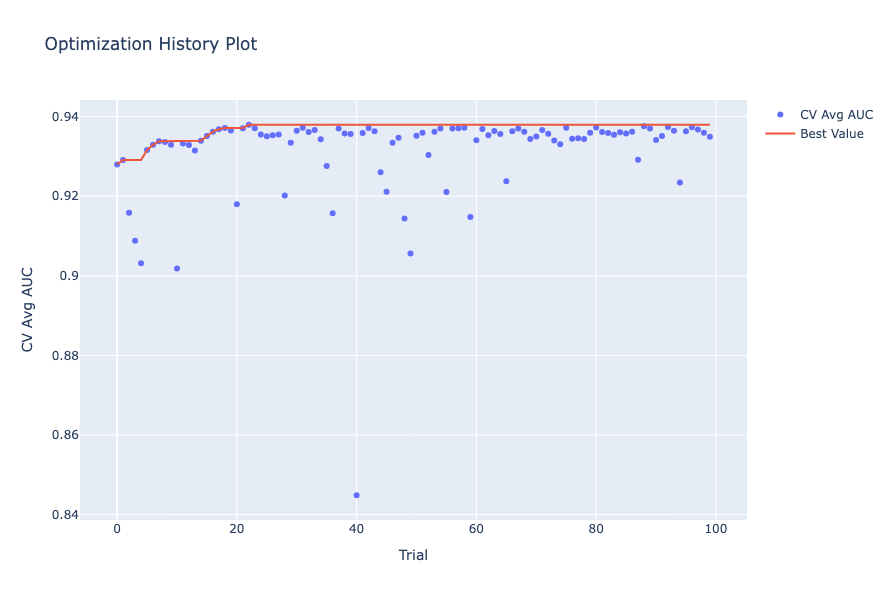

In [704]:
fig = optuna.visualization.plot_optimization_history(study, target_name='CV Avg AUC')

fig.update_layout(
    autosize=True,
    width=800,
    height=600
)
fig.show()

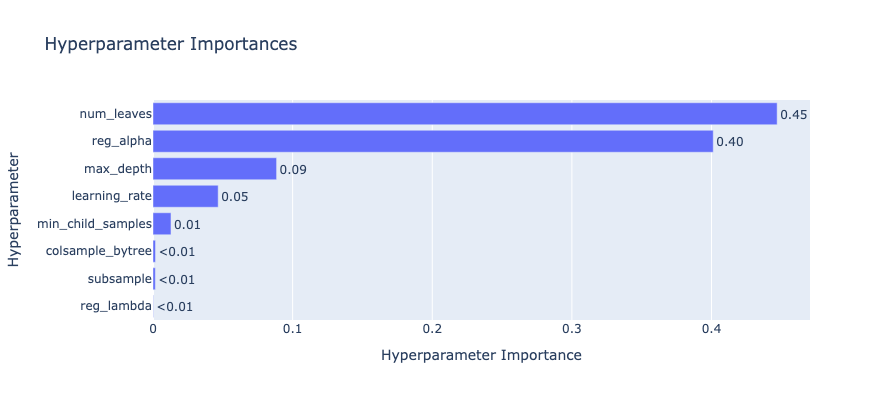

In [705]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(
    autosize=True,
    width=900,
    height=400
)
fig.show()

In [706]:
study.best_params

{'learning_rate': 0.12166922279040863,
 'num_leaves': 37,
 'max_depth': 46,
 'min_child_samples': 11,
 'subsample': 0.9454185863148876,
 'colsample_bytree': 0.503449273730797,
 'reg_alpha': 0.07740865375398932,
 'reg_lambda': 0.027092898787545394}

In [707]:
# Train final model with best parameters
best_params = study.best_params
final_model = LGBMClassifier(
    objective='multiclass',
    class_weight='balanced',
    **best_params)
final_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3196
[LightGBM] [Info] Number of data points in the train set: 7079, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


LGBMClassifier(class_weight='balanced', colsample_bytree=0.503449273730797,
               learning_rate=0.12166922279040863, max_depth=46,
               min_child_samples=11, num_leaves=37, objective='multiclass',
               reg_alpha=0.07740865375398932, reg_lambda=0.027092898787545394,
               subsample=0.9454185863148876)

In [713]:
# Predict on the validation set
y_pred = final_model.predict(X_valid)
# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.96      0.97      0.96       649
    Diseased       0.83      0.85      0.84        47
       Pests       0.88      0.71      0.79        49
    Stressed       0.79      0.79      0.79        42

    accuracy                           0.94       787
   macro avg       0.86      0.83      0.84       787
weighted avg       0.94      0.94      0.94       787


Weighted F1 Score: 0.9367969014223471


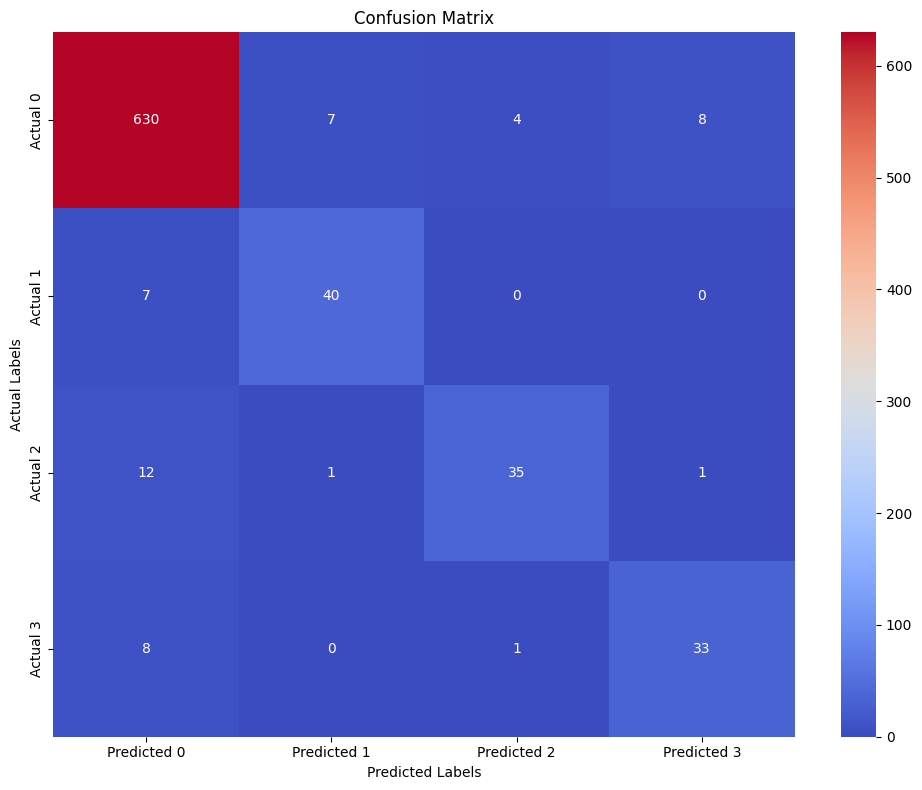

In [715]:
plot_confusion_matrix(y_valid, y_pred)